In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

In [ ]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd
from collections import defaultdict

torch.set_default_dtype(torch.float32)

In [ ]:
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## Declare classes

In [4]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100], outputs=10):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], outputs)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class DropoutNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(1-700/784)
    
    def forward(self, x):
        out = x
        out = self.dropout(out)
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[10]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]
        self.out_act = torch.nn.Sigmoid()
        
    def forward(self, data):
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out
    
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

In [ ]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256, 128], test_nodes=100, device='cuda:0'):
        super().__init__()
        self.device = device
        
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.hidden2 = torch.nn.Linear(layers[1], layers[2])
        self.out = torch.nn.Linear(layers[2], self.out_size)
        
        self.dropout = torch.nn.Dropout()
        
#         self.relu = torch.nn.ReLU()
        self.relu = torch.relu
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        
        self._retrained = True
        self._test_nets = None
        
    def to(self, device):
        super().to(device)
        self.device = device
        self.test_mask = self._create_mask(self.test_nodes)
        return self
        
    def forward(self, data, mask=None):
        """ Get a hypernet prediction. 
        During training we use a single target network per sample. 
        During eval, we create a network for each test mask and average their results
        
        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            self._retrained = True
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)

            
            # If we have a few identical masks in a row
            # we only need to calculate target network
            # for the first one
            recalculate = [True]*len(mask)
            for i in range(1, len(mask)):
                if torch.equal(mask[i-1], mask[i]):
                    recalculate[i] = False
                    
            weights = self.craft_network(mask)
            mask = mask.to(torch.bool)
            
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(data)):
                if recalculate[i]:
                    nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i]]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask
                nets = self._get_test_nets()
            else:
                nets = self.__craft_nets(mask)
            mask = mask.to(torch.bool)

            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(mask)):
                nn = nets[i]
                masked_data = data[:, mask[i]]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

    def _get_test_nets(self):
        if self._retrained:
            nets = self.__craft_nets(self.test_mask)
            self._test_nets = nets
            self._retrained = False
        return self._test_nets
    
    def __craft_nets(self, mask):
        nets = []
        weights = self.craft_network(mask.to(torch.float32))
        for i in range(len(mask)):
            nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
            nets.append(nn)
        return nets
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden2(out)
        out = self.relu(out)

        out = self.out(out)
        return out

In [ ]:
hypernet = Hypernetwork(mask_size=20, node_hidden_size=10).to("cuda")

In [ ]:
hypernet.eval()
# print(hypernet(inputs).shape)
# print(hypernet.out_size)

Hypernetwork(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=320, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Load data

In [ ]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [ ]:
def get_dataset(size=60000, masked=False, mask_no=200, mask_size=700, shared_mask=False, batch_size=32, test_batch_size=32):
    mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
    mods = transforms.Compose(mods)
    
    trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
    testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)
    if masked:
        trainset = MaskedDataset(trainset, mask_no, mask_size)
        testset = MaskedDataset(testset, mask_no, mask_size)
        if shared_mask:
            testset.masks = trainset.masks
        
    indices = torch.arange(size)
    trainset = data_utils.Subset(trainset, indices)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)
    return trainloader, testloader

In [ ]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, masks, mask_size):
        inputs = dataset[0][0].shape[0]
        self.mask_size = mask_size
        self.dataset = dataset
        self.template = np.zeros(inputs)
        self.masks = self._create_mask(masks)
        self.masks_indices = np.random.choice(np.arange(masks), len(dataset))
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32)
        return mask
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        mask = self.masks[self.masks_indices[idx]]
        return image, label, mask
    
masked_trainset = MaskedDataset(trainset, 20, 500)
masked_testset = MaskedDataset(testset, 20, 500)

In [ ]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                         shuffle=False)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=1)
# testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
#                                          shuffle=False, num_workers=1)

## Craft model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

## Dense network benchmark

In [594]:
def train_regular(network, optimizer, criterion, loaders, size, epochs, device='cuda:0', name="dense-net", test_every=10):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
    experiment.add_tag(name)
    experiment.log_parameter("training_size", size)
    experiment.log_parameter("max_epochs", epochs)
    experiment.log_parameter("check_val_every_n_epoch", 5)
    
    trainloader, testloader = loaders
    train_loss = []
    test_loss = []
    test_accs = []
    with trange(epochs) as t:
        for epoch in t:
            total_loss = 0
            running_loss = 0.0
            correct = 0
            total = 0
            network = network.train()
            for i, data in enumerate(trainloader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = network(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                correct += (outputs.argmax(1)==labels).float().sum()
                total += outputs.shape[0]
                running_loss += loss.item()
                train_loss.append(loss.item())
                if i>0 and i % 100 == 0:
                    total_loss += running_loss/100
                    running_loss = 0.0
                    correct = 0
                    total=0

            total_loss = 0
            correct = 0
            denom = 0
            network = network.eval()
            if epoch%test_every==0:
                for i, data in enumerate(testloader):
                    images, labels = data
                    denom += len(labels)
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = network(images)
                    _, predicted = torch.max(outputs.data, 1)
                    correct += (predicted == labels).sum().item()
                    total_loss += criterion(outputs, labels).item()

                test_loss.append(total_loss/i)
                test_accs.append(correct/denom*100)

                t.set_postfix(test_acc=correct/denom*100, loss=total_loss/i)
                experiment.log_metric("test_accuracy", correct/denom*100, step=epoch)    
                experiment.log_metric("test_loss", test_loss[-1], step=epoch)
                
    experiment.end()
    return max(test_accs), test_loss[-1]

In [582]:
epochs = 150

results = defaultdict(list)
for i in range(10):
    for size in [100, 500]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = SimpleNetwork(784).cuda()
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size)

        results[size].append(train_regular(hypernet, optimizer, trainloader, size))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/306bc9bb27df4aa6b5b4d9fd7a25bedf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.34it/s]


Test acc: 20.630000000000003, loss: 2.518429676691691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Test acc: 24.72, loss: 2.4935288429260254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.12it/s]


Test acc: 28.93, loss: 2.4707190725538464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


Test acc: 35.91, loss: 2.4467842313978405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84it/s]


Test acc: 41.42, loss: 2.4228619469536676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82it/s]


Test acc: 44.11, loss: 2.398759947882758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.55it/s]


Test acc: 46.800000000000004, loss: 2.3733049498664007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


Test acc: 49.21, loss: 2.3469742139180503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]


Test acc: 52.39, loss: 2.3202365239461265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]


Test acc: 54.900000000000006, loss: 2.2967343860202365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77it/s]


Test acc: 56.410000000000004, loss: 2.2736108038160534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Test acc: 57.31, loss: 2.2526112927330866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73it/s]


Test acc: 58.01, loss: 2.2336977852715387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.14it/s]


Test acc: 59.64, loss: 2.2135785023371377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]


Test acc: 61.3, loss: 2.195326566696167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42it/s]


Test acc: 61.9, loss: 2.1799534956614175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]


Test acc: 62.01, loss: 2.1660465399424234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.31it/s]


Test acc: 62.870000000000005, loss: 2.1525820361243353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


Test acc: 64.31, loss: 2.139264053768582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76it/s]


Test acc: 66.19, loss: 2.1276189618640475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.30it/s]


Test acc: 66.89, loss: 2.119515339533488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


Test acc: 67.0, loss: 2.1111869149737887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77it/s]


Test acc: 66.56, loss: 2.1040508614646063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63it/s]


Test acc: 66.09, loss: 2.0994722180896335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40it/s]


Test acc: 66.02, loss: 2.095656991004944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]


Test acc: 66.52, loss: 2.0909047391679554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.34it/s]


Test acc: 67.03, loss: 2.085976587401496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16it/s]


Test acc: 66.97, loss: 2.0818394157621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.69it/s]


Test acc: 66.88, loss: 2.0776401493284435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


Test acc: 66.92, loss: 2.0744444264305963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92it/s]


Test acc: 66.53999999999999, loss: 2.069970303111606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.09it/s]


Test acc: 65.94, loss: 2.0667322476704917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]


Test acc: 66.3, loss: 2.063555743959215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77it/s]


Test acc: 66.25, loss: 2.0608825418684216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81it/s]


Test acc: 66.24, loss: 2.058918515841166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.84it/s]


Test acc: 66.57, loss: 2.05785153971778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82it/s]


Test acc: 66.64999999999999, loss: 2.0563999149534435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]


Test acc: 67.01, loss: 2.052305989795261


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.15it/s]


Test acc: 67.82000000000001, loss: 2.0480935441123114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87it/s]


Test acc: 68.23, loss: 2.0460146135754056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.14it/s]


Test acc: 68.44, loss: 2.0443150334888034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.02it/s]


Test acc: 68.36, loss: 2.043009983168708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]


Test acc: 68.17999999999999, loss: 2.0427196158303156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.80it/s]


Test acc: 67.63, loss: 2.042676462067498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Test acc: 67.17, loss: 2.042891409662035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63it/s]


Test acc: 67.10000000000001, loss: 2.042835831642151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Test acc: 67.07, loss: 2.0426791508992515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


Test acc: 67.09, loss: 2.0430977609422474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.23it/s]


Test acc: 66.99000000000001, loss: 2.043386975924174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]


Test acc: 67.02, loss: 2.043510185347663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62it/s]


Test acc: 67.01, loss: 2.0420438713497586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.38it/s]


Test acc: 67.32000000000001, loss: 2.039604213502672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.09it/s]


Test acc: 67.53, loss: 2.0375395483440824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73it/s]


Test acc: 67.72, loss: 2.0353526539272733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76it/s]


Test acc: 67.95, loss: 2.033895969390869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.42it/s]


Test acc: 68.14, loss: 2.0330141252941556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.94it/s]


Test acc: 68.04, loss: 2.0330485900243125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.97it/s]


Test acc: 67.53, loss: 2.033737195862664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62it/s]


Test acc: 67.33, loss: 2.0350803004370794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87it/s]


Test acc: 67.57, loss: 2.036364939477709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


Test acc: 67.57, loss: 2.0373524692323475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


Test acc: 67.49000000000001, loss: 2.0379942258199057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73it/s]


Test acc: 67.43, loss: 2.037233140733507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.94it/s]


Test acc: 67.47999999999999, loss: 2.0360907316207886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]


Test acc: 67.49000000000001, loss: 2.035167376200358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.93it/s]


Test acc: 67.58, loss: 2.034600761201647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73it/s]


Test acc: 67.63, loss: 2.033856511116028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53it/s]


Test acc: 67.80000000000001, loss: 2.0326700475480823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


Test acc: 67.97, loss: 2.0323237313164606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77it/s]


Test acc: 68.06, loss: 2.0322386158837213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]


Test acc: 68.0, loss: 2.031879107157389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]


Test acc: 67.84, loss: 2.0313110219107733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]


Test acc: 67.96, loss: 2.0307628048790827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]


Test acc: 67.97999999999999, loss: 2.0306827227274575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.99it/s]


Test acc: 67.96, loss: 2.0309870772891574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


Test acc: 67.86999999999999, loss: 2.0310484568277993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


Test acc: 67.93, loss: 2.0308804909388223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]


Test acc: 68.01, loss: 2.0308825969696045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.03it/s]


Test acc: 68.0, loss: 2.030637409951952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


Test acc: 67.94, loss: 2.0305579900741577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


Test acc: 67.97999999999999, loss: 2.0308577749464245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62it/s]


Test acc: 68.06, loss: 2.0310726828045316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.39it/s]


Test acc: 68.28999999999999, loss: 2.03029023276435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


Test acc: 68.17999999999999, loss: 2.029283218913608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.48it/s]


Test acc: 68.05, loss: 2.028715451558431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.69it/s]


Test acc: 67.9, loss: 2.028549737400479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.37it/s]


Test acc: 67.88, loss: 2.027956896358066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Test acc: 67.83, loss: 2.027403791745504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Test acc: 67.84, loss: 2.026627699534098


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


Test acc: 67.9, loss: 2.0264258914523654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.18it/s]


Test acc: 68.08999999999999, loss: 2.026447150442335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82it/s]


Test acc: 68.07, loss: 2.027082178327772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76it/s]


Test acc: 67.97, loss: 2.027772002749973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]


Test acc: 68.11, loss: 2.0281724664900036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]


Test acc: 68.21000000000001, loss: 2.0271922482384577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89it/s]


Test acc: 68.35, loss: 2.024978624449836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.90it/s]


Test acc: 68.45, loss: 2.0235576099819608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.35it/s]


Test acc: 68.57, loss: 2.023168060514662


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87it/s]


Test acc: 68.57, loss: 2.0231597423553467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.85it/s]


Test acc: 68.49, loss: 2.0236256387498646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.51it/s]


Test acc: 68.38, loss: 2.0242875019709268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.40it/s]


Test acc: 68.27, loss: 2.0244975487391152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


Test acc: 68.24, loss: 2.0247049596574573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.29it/s]


Test acc: 68.26, loss: 2.0242380830976696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.41it/s]


Test acc: 68.24, loss: 2.0240383545557656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.41it/s]


Test acc: 68.26, loss: 2.024082448747423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


Test acc: 68.4, loss: 2.0243322054545083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]


Test acc: 68.5, loss: 2.024373730023702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


Test acc: 68.54, loss: 2.024129774835375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]


Test acc: 68.41000000000001, loss: 2.0236592160330877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.49it/s]


Test acc: 68.44, loss: 2.0232378244400024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.51it/s]


Test acc: 68.47999999999999, loss: 2.022766258981493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89it/s]


Test acc: 68.43, loss: 2.0223793851004706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.93it/s]


Test acc: 68.33, loss: 2.0227549738354154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.20it/s]


Test acc: 68.23, loss: 2.0233338011635675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


Test acc: 68.16, loss: 2.0242128902011447


  0%|                                                                                                                                       | 0/4 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f12fee765e0>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.31it/s]


Test acc: 68.16, loss: 2.024197777112325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.91it/s]


Test acc: 68.16, loss: 2.0242616335550943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.14it/s]


Test acc: 68.24, loss: 2.0243845648235745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.39it/s]


Test acc: 68.27, loss: 2.0245056019888983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.44it/s]


Test acc: 68.25, loss: 2.024786803457472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76it/s]


Test acc: 68.22, loss: 2.0246518188052707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.82it/s]


Test acc: 68.36, loss: 2.0238161749309964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


Test acc: 68.34, loss: 2.0228444602754383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60it/s]


Test acc: 68.39, loss: 2.0224062866634793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.94it/s]


Test acc: 68.4, loss: 2.0222087966071234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.26it/s]


Test acc: 68.4, loss: 2.0220605929692588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]


Test acc: 68.39, loss: 2.0220543411042957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.26it/s]


Test acc: 68.44, loss: 2.022036976284451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.71it/s]


Test acc: 68.47999999999999, loss: 2.0220076507992215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.30it/s]


Test acc: 68.45, loss: 2.0224340756734214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]


Test acc: 68.43, loss: 2.022979007826911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]


KeyboardInterrupt: 

In [237]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df
test_acc_df.mean(axis=0)

Test accuracy


100    69.216
500    85.017
dtype: float64

In [239]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df
test_loss_df.mean(axis=0)

Test loss


100    86.294047
500    49.862424
dtype: float64

## Dropout network benchmark
We need another baseline to check whether improved results aren't purely because of ensemble

In [595]:
epochs = 150

results = defaultdict(list)
for i in range(10):
    for size in [100, 500]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = DropoutNetwork(784).cuda()
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size)

        results[size].append(train_regular(hypernet, optimizer, trainloader, size, "dropout network"))

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3634aeb8b05b48da97c989575649e44b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [13]         : (0.2047099769115448, 2.368307590484619)
COMET INFO:     test_accuracy [7] : (26.61, 68.93)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.44 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in

Test acc: 24.759999999999998, loss: 2.469302256902059


  4%|█████                                                                                                                        | 6/150 [00:05<02:36,  1.09s/it]

Test acc: 49.8, loss: 2.0379945039749146


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 60.9, loss: 1.6525352001190186


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:17,  1.02s/it]

Test acc: 61.519999999999996, loss: 1.4559994406170316


 14%|█████████████████▎                                                                                                          | 21/150 [00:16<02:11,  1.02s/it]

Test acc: 65.63, loss: 1.292446427875095


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:05,  1.01s/it]

Test acc: 66.23, loss: 1.218977451324463


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:01,  1.02s/it]

Test acc: 67.65, loss: 1.1682823697725933


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:27<01:56,  1.02s/it]

Test acc: 67.61, loss: 1.1645982133017645


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:31<01:50,  1.01s/it]

Test acc: 67.62, loss: 1.1487749285168118


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:45,  1.01s/it]

Test acc: 68.27, loss: 1.1410482856962416


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:38<01:41,  1.02s/it]

Test acc: 67.71000000000001, loss: 1.15336185031467


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:42<01:36,  1.02s/it]

Test acc: 68.10000000000001, loss: 1.1390841205914815


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:46<01:31,  1.02s/it]

Test acc: 68.77, loss: 1.1276411281691656


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:25,  1.02s/it]

Test acc: 68.33, loss: 1.1486561364597745


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:53<01:21,  1.03s/it]

Test acc: 68.22, loss: 1.1626091003417969


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:57<01:16,  1.03s/it]

Test acc: 68.78, loss: 1.1605928474002414


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:11,  1.03s/it]

Test acc: 68.94, loss: 1.1455781658490498


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:04<01:06,  1.03s/it]

Test acc: 68.97999999999999, loss: 1.1494543817308214


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:08<01:00,  1.02s/it]

Test acc: 68.74, loss: 1.1814845469262865


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:12<00:55,  1.02s/it]

Test acc: 68.89, loss: 1.1874777608447604


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.02s/it]

Test acc: 68.69, loss: 1.1948262850443523


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:19<00:44,  1.02s/it]

Test acc: 68.66, loss: 1.204047163327535


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:23<00:40,  1.03s/it]

Test acc: 68.65, loss: 1.203433546755049


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:27<00:34,  1.02s/it]

Test acc: 68.62, loss: 1.2125374674797058


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:30<00:29,  1.02s/it]

Test acc: 68.67999999999999, loss: 1.2188032004568312


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:34<00:24,  1.02s/it]

Test acc: 68.78999999999999, loss: 1.216756092177497


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:38<00:19,  1.01s/it]

Test acc: 68.78999999999999, loss: 1.2206823031107585


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:41<00:14,  1.02s/it]

Test acc: 68.47999999999999, loss: 1.238395591576894


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:45<00:09,  1.02s/it]

Test acc: 68.57, loss: 1.2398571636941698


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:49<00:04,  1.04s/it]

Test acc: 68.67, loss: 1.2420747809939914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:50<00:00,  1.35it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e22009531e6a40588a80bc3338f93cf4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.0036110191140323877, 2.3638226985931396)
COMET INFO:     test_accuracy [30] : (24.759999999999998, 68.97999999999999)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.44 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     n

Test acc: 55.83, loss: 2.0578052467770047


  4%|█████                                                                                                                        | 6/150 [00:06<02:46,  1.15s/it]

Test acc: 79.03999999999999, loss: 0.8053759137789408


  7%|█████████                                                                                                                   | 11/150 [00:10<02:33,  1.11s/it]

Test acc: 82.37, loss: 0.6311421758598752


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:26,  1.09s/it]

Test acc: 83.57, loss: 0.5777942736943563


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:21,  1.10s/it]

Test acc: 84.06, loss: 0.5576632453335656


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:16,  1.10s/it]

Test acc: 84.39999999999999, loss: 0.5543864932325151


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:26<02:10,  1.09s/it]

Test acc: 84.48, loss: 0.5570125612947676


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:30<02:04,  1.09s/it]

Test acc: 84.3, loss: 0.5669697390662299


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:34<01:59,  1.09s/it]

Test acc: 84.64, loss: 0.5707108908229404


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:38<01:53,  1.10s/it]

Test acc: 84.72, loss: 0.5763112107912699


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:42<01:47,  1.09s/it]

Test acc: 84.78, loss: 0.5855660670333438


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:46<01:42,  1.09s/it]

Test acc: 84.89, loss: 0.5897772676414914


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:50<01:38,  1.11s/it]

Test acc: 84.74000000000001, loss: 0.602826906575097


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:34,  1.12s/it]

Test acc: 84.43, loss: 0.6190371811389923


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:26,  1.10s/it]

Test acc: 84.86, loss: 0.614667812983195


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03<01:22,  1.11s/it]

Test acc: 84.89999999999999, loss: 0.6245815224117703


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:07<01:16,  1.10s/it]

Test acc: 84.77, loss: 0.6298643946647644


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:11<01:11,  1.11s/it]

Test acc: 84.61999999999999, loss: 0.6399616996447245


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:15<01:04,  1.10s/it]

Test acc: 84.67, loss: 0.6452943550215827


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:19<00:59,  1.11s/it]

Test acc: 84.92, loss: 0.645811872349845


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:23<00:53,  1.10s/it]

Test acc: 84.95, loss: 0.6540253195497725


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:27<00:48,  1.09s/it]

Test acc: 84.84, loss: 0.6595029566023085


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:31<00:42,  1.09s/it]

Test acc: 84.78999999999999, loss: 0.6735930012332069


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:35<00:37,  1.09s/it]

Test acc: 84.77, loss: 0.6765306757556068


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:39<00:31,  1.10s/it]

Test acc: 84.92, loss: 0.6776935557524363


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:43<00:26,  1.09s/it]

Test acc: 84.88, loss: 0.6839379502667321


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:48<00:20,  1.09s/it]

Test acc: 84.86, loss: 0.6887605686982473


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:52<00:15,  1.11s/it]

Test acc: 84.88, loss: 0.6981028914451599


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:56<00:09,  1.11s/it]

Test acc: 84.92, loss: 0.6969261368115743


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:00<00:04,  1.11s/it]

Test acc: 84.75, loss: 0.7083458734883202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:02<00:00,  1.23it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/61080037908c4e1ea73c45a9954c19a2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0010162737453356385, 2.3263165950775146)
COMET INFO:     test_accuracy [30] : (55.83, 84.95)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.44 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 :

Test acc: 23.189999999999998, loss: 2.459844059414334


  4%|█████                                                                                                                        | 6/150 [00:05<02:35,  1.08s/it]

Test acc: 48.11, loss: 2.004093064202203


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 59.550000000000004, loss: 1.6598944531546698


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:16,  1.02s/it]

Test acc: 64.4, loss: 1.4042418201764424


 14%|█████████████████▎                                                                                                          | 21/150 [00:16<02:10,  1.01s/it]

Test acc: 65.63, loss: 1.2917159861988492


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:05,  1.02s/it]

Test acc: 65.94, loss: 1.22701977358924


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:01,  1.02s/it]

Test acc: 68.08, loss: 1.1731276777055528


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:27<01:55,  1.01s/it]

Test acc: 67.36, loss: 1.1873706314298842


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:31<01:51,  1.02s/it]

Test acc: 67.75999999999999, loss: 1.1821427212821112


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:46,  1.03s/it]

Test acc: 67.54, loss: 1.181684050295088


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:41,  1.03s/it]

Test acc: 68.37, loss: 1.1612470282448664


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:42<01:36,  1.03s/it]

Test acc: 68.17999999999999, loss: 1.1792128086090088


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:46<01:31,  1.02s/it]

Test acc: 67.5, loss: 1.2090599139531453


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:26,  1.03s/it]

Test acc: 68.25, loss: 1.1834741764598422


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:53<01:21,  1.04s/it]

Test acc: 68.64, loss: 1.1779385209083557


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:57<01:16,  1.03s/it]

Test acc: 68.66, loss: 1.1895009875297546


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:11,  1.04s/it]

Test acc: 69.04, loss: 1.188064091735416


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:05<01:06,  1.03s/it]

Test acc: 69.04, loss: 1.1843928959634569


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:08<01:01,  1.03s/it]

Test acc: 68.72, loss: 1.2081614865197077


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:12<00:55,  1.03s/it]

Test acc: 69.01, loss: 1.2118298014005024


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.02s/it]

Test acc: 68.96, loss: 1.2182070083088345


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:20<00:45,  1.04s/it]

Test acc: 68.89, loss: 1.2278160717752244


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:23<00:39,  1.02s/it]

Test acc: 68.94, loss: 1.227045112186008


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:27<00:34,  1.02s/it]

Test acc: 68.8, loss: 1.2432982458008661


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:31<00:29,  1.02s/it]

Test acc: 68.72, loss: 1.2522128025690715


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:34<00:24,  1.02s/it]

Test acc: 68.78999999999999, loss: 1.2491899596320257


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:38<00:19,  1.02s/it]

Test acc: 68.99, loss: 1.252380026711358


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:42<00:14,  1.04s/it]

Test acc: 68.94, loss: 1.2657851709259882


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:45<00:09,  1.02s/it]

Test acc: 68.87, loss: 1.2719436287879944


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:49<00:04,  1.03s/it]

Test acc: 69.04, loss: 1.2658765779601202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:51<00:00,  1.35it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5fb6ba1f7f014e628ebb3d6d22f05544
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.0048591080121695995, 2.29911208152771)
COMET INFO:     test_accuracy [30] : (23.189999999999998, 69.04)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.47 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook       

Test acc: 54.86, loss: 2.0933871269226074


  4%|█████                                                                                                                        | 6/150 [00:06<02:48,  1.17s/it]

Test acc: 78.5, loss: 0.8224274085627662


  7%|█████████                                                                                                                   | 11/150 [00:10<02:32,  1.10s/it]

Test acc: 82.50999999999999, loss: 0.6385534008344015


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:27,  1.10s/it]

Test acc: 84.03, loss: 0.5787634683979882


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:22,  1.10s/it]

Test acc: 84.34, loss: 0.5626908110247718


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:16,  1.10s/it]

Test acc: 84.59, loss: 0.5586109790537093


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:26<02:10,  1.10s/it]

Test acc: 84.46000000000001, loss: 0.5626434087753296


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:30<02:04,  1.09s/it]

Test acc: 84.45, loss: 0.5702217949761285


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:34<02:00,  1.10s/it]

Test acc: 84.63000000000001, loss: 0.5782117512491014


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:54,  1.10s/it]

Test acc: 84.61, loss: 0.5889005959033966


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:50,  1.11s/it]

Test acc: 84.81, loss: 0.590466148323483


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:45,  1.12s/it]

Test acc: 84.67, loss: 0.6031481557422214


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:39,  1.12s/it]

Test acc: 84.64, loss: 0.6097297138637967


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:33,  1.11s/it]

Test acc: 84.78, loss: 0.6152525544166565


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:27,  1.10s/it]

Test acc: 84.68, loss: 0.6291458772288429


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03<01:21,  1.10s/it]

Test acc: 84.76, loss: 0.6347306668758392


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:07<01:16,  1.10s/it]

Test acc: 84.47, loss: 0.6491238706641727


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:11<01:10,  1.10s/it]

Test acc: 84.85000000000001, loss: 0.6498866677284241


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16<01:05,  1.11s/it]

Test acc: 84.63000000000001, loss: 0.6601325637764401


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20<00:59,  1.11s/it]

Test acc: 84.89, loss: 0.6630179517798953


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24<00:55,  1.12s/it]

Test acc: 84.69, loss: 0.6720921827687157


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:28<00:48,  1.11s/it]

Test acc: 84.98, loss: 0.672956258058548


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:32<00:43,  1.11s/it]

Test acc: 84.87, loss: 0.6834108432133993


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:36<00:37,  1.12s/it]

Test acc: 84.97, loss: 0.6878241135014428


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:40<00:32,  1.11s/it]

Test acc: 84.92, loss: 0.6909990310668945


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:45<00:26,  1.12s/it]

Test acc: 84.92, loss: 0.7006790207491981


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:49<00:21,  1.12s/it]

Test acc: 84.74000000000001, loss: 0.7077672978242239


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53<00:15,  1.13s/it]

Test acc: 84.91, loss: 0.7123002343707614


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:57<00:10,  1.12s/it]

Test acc: 84.88, loss: 0.7200493249628279


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:01<00:04,  1.12s/it]

Test acc: 84.83000000000001, loss: 0.7275066673755646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.21it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/957e48fa649d4e1a8f0f30d3adae175c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0004434219154063612, 2.3735404014587402)
COMET INFO:     test_accuracy [30] : (54.86, 84.98)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.49 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 :

Test acc: 23.93, loss: 2.439933326509264


  4%|█████                                                                                                                        | 6/150 [00:05<02:38,  1.10s/it]

Test acc: 45.01, loss: 1.9566381110085382


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 61.980000000000004, loss: 1.5644247002071805


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:17,  1.02s/it]

Test acc: 66.16, loss: 1.3405134081840515


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:12,  1.03s/it]

Test acc: 64.5, loss: 1.2730835676193237


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:06,  1.02s/it]

Test acc: 66.99000000000001, loss: 1.2134126491016812


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:01,  1.02s/it]

Test acc: 68.62, loss: 1.1413680712382


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:56,  1.02s/it]

Test acc: 67.63, loss: 1.1522959801885817


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:31<01:52,  1.03s/it]

Test acc: 68.60000000000001, loss: 1.1280414991908603


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:47,  1.03s/it]

Test acc: 67.75, loss: 1.1311254964934454


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:41,  1.02s/it]

Test acc: 68.41000000000001, loss: 1.1287824379073248


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:43<01:37,  1.04s/it]

Test acc: 68.2, loss: 1.128211988343133


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:46<01:31,  1.03s/it]

Test acc: 68.54, loss: 1.127659969859653


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:25,  1.02s/it]

Test acc: 68.78, loss: 1.1078181266784668


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:21,  1.03s/it]

Test acc: 69.01, loss: 1.1181022061241999


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:57<01:15,  1.03s/it]

Test acc: 68.87, loss: 1.1314927538235982


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:11,  1.03s/it]

Test acc: 69.21000000000001, loss: 1.1199957860840692


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:05<01:05,  1.02s/it]

Test acc: 69.42, loss: 1.1196808616320293


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:01,  1.03s/it]

Test acc: 68.78, loss: 1.1389164725939434


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:12<00:55,  1.02s/it]

Test acc: 69.08, loss: 1.1511619422170851


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.03s/it]

Test acc: 68.88, loss: 1.162454154756334


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:20<00:45,  1.03s/it]

Test acc: 69.08, loss: 1.1598130000962152


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:24<00:39,  1.02s/it]

Test acc: 69.33, loss: 1.1585645410749648


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:27<00:34,  1.02s/it]

Test acc: 69.45, loss: 1.1584691339068942


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:31<00:29,  1.02s/it]

Test acc: 69.33, loss: 1.1712702247831557


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:35<00:24,  1.03s/it]

Test acc: 69.1, loss: 1.1828384266959295


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:38<00:19,  1.03s/it]

Test acc: 69.11, loss: 1.1882594029108684


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:42<00:14,  1.04s/it]

Test acc: 69.14, loss: 1.1906137135293748


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:46<00:09,  1.02s/it]

Test acc: 69.25, loss: 1.1912871268060472


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:50<00:04,  1.05s/it]

Test acc: 69.35, loss: 1.1905939910146925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:51<00:00,  1.34it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3ca01d90eac74c0c9f04040135ef0536
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.0045983558520674706, 2.3194260597229004)
COMET INFO:     test_accuracy [30] : (23.93, 69.45)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.51 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 :

Test acc: 54.59, loss: 2.0510560274124146


  3%|████▏                                                                                                                        | 5/150 [00:04<01:32,  1.57it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  4%|█████                                                                                                                        | 6/150 [00:06

Test acc: 79.23, loss: 0.8113670017984178


  7%|████████▎                                                                                                                   | 10/150 [00:08<01:31,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  7%|█████████                                                                                                                   | 11/150 [00:11

Test acc: 82.43, loss: 0.6393423279126486


 10%|████████████▍                                                                                                               | 15/150 [00:13<01:27,  1.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 11%|█████████████▏                                                                                                              | 16/150 [00:15

Test acc: 83.82, loss: 0.5837206178241305


 13%|████████████████▌                                                                                                           | 20/150 [00:17<01:24,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 14%|█████████████████▎                                                                                                          | 21/150 [00:20

Test acc: 84.36, loss: 0.5626867347293429


 17%|████████████████████▋                                                                                                       | 25/150 [00:22<01:21,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 17%|█████████████████████▍                                                                                                      | 26/150 [00:24

Test acc: 84.3, loss: 0.5612618625164032


 20%|████████████████████████▊                                                                                                   | 30/150 [00:26<01:18,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 21%|█████████████████████████▋                                                                                                  | 31/150 [00:29

Test acc: 84.17999999999999, loss: 0.5663494103484683


 23%|████████████████████████████▉                                                                                               | 35/150 [00:31<01:15,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 24%|█████████████████████████████▊                                                                                              | 36/150 [00:33

Test acc: 84.85000000000001, loss: 0.5651367141140832


 27%|█████████████████████████████████                                                                                           | 40/150 [00:35<01:12,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:38

Test acc: 84.45, loss: 0.5771884951326582


 30%|█████████████████████████████████████▏                                                                                      | 45/150 [00:40<01:09,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 31%|██████████████████████████████████████                                                                                      | 46/150 [00:42

Test acc: 84.77, loss: 0.5788820154137082


 33%|█████████████████████████████████████████▎                                                                                  | 50/150 [00:44<01:06,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:47

Test acc: 84.66, loss: 0.5883159306314256


 37%|█████████████████████████████████████████████▍                                                                              | 55/150 [00:49<01:02,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:51

Test acc: 84.85000000000001, loss: 0.5969118542141385


 40%|█████████████████████████████████████████████████▌                                                                          | 60/150 [00:53<00:59,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:56

Test acc: 84.91, loss: 0.6044115887747871


 43%|█████████████████████████████████████████████████████▋                                                                      | 65/150 [00:57<00:55,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [01:00

Test acc: 84.84, loss: 0.6133795976638794


 47%|█████████████████████████████████████████████████████████▊                                                                  | 70/150 [01:02<00:52,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [01:05

Test acc: 84.86, loss: 0.622057792213228


 50%|██████████████████████████████████████████████████████████████                                                              | 75/150 [01:06<00:49,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:09

Test acc: 84.93, loss: 0.6266053252749972


 53%|██████████████████████████████████████████████████████████████████▏                                                         | 80/150 [01:11<00:45,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:13

Test acc: 85.02, loss: 0.632079670826594


 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 85/150 [01:15<00:42,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:18

Test acc: 84.76, loss: 0.6434153483973609


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 90/150 [01:20<00:39,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:22

Test acc: 85.06, loss: 0.6507555113898383


 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 95/150 [01:24<00:36,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:27

Test acc: 84.99, loss: 0.6549070013893975


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 100/150 [01:29<00:32,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:31

Test acc: 84.76, loss: 0.6622830364439223


 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 105/150 [01:33<00:29,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:36

Test acc: 84.77, loss: 0.6713222331470914


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 110/150 [01:38<00:26,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:40

Test acc: 85.1, loss: 0.6708712180455526


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▎                            | 115/150 [01:42<00:22,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:45

Test acc: 84.97, loss: 0.6751395497057173


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 120/150 [01:47<00:19,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:49

Test acc: 84.82, loss: 0.6878340509202745


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 125/150 [01:51<00:16,  1.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:54

Test acc: 84.82, loss: 0.692174944612715


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 130/150 [01:56<00:12,  1.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:58

Test acc: 84.93, loss: 0.696239838997523


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 135/150 [02:00<00:09,  1.52it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [02:03

Test acc: 85.0, loss: 0.7040684190061357


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 140/150 [02:05<00:06,  1.53it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [02:07

Test acc: 84.89999999999999, loss: 0.7064006394810147


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145/150 [02:09<00:03,  1.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:12

Test acc: 85.0, loss: 0.7119802567693923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:14<00:00,  1.12it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/455946375dc947ae89b652370ae3052a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0004837527812924236, 2.3456478118896484)
COMET INFO:     test_accuracy [30] : (54.59, 85.1)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.53 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 

Test acc: 26.119999999999997, loss: 2.4384202692243786


  3%|████▏                                                                                                                        | 5/150 [00:04<01:24,  1.71it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  4%|█████                                                                                                                        | 6/150 [00:06

Test acc: 50.82, loss: 1.9523201253679063


  7%|████████▎                                                                                                                   | 10/150 [00:08<01:22,  1.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  7%|█████████                                                                                                                   | 11/150 [00:10

Test acc: 59.11, loss: 1.5646292633480496


 10%|████████████▍                                                                                                               | 15/150 [00:12<01:19,  1.70it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 11%|█████████████▏                                                                                                              | 16/150 [00:14

Test acc: 64.71000000000001, loss: 1.3628392948044672


 13%|████████████████▌                                                                                                           | 20/150 [00:16<01:16,  1.71it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 14%|█████████████████▎                                                                                                          | 21/150 [00:19

Test acc: 65.46, loss: 1.2634628878699408


 17%|████████████████████▋                                                                                                       | 25/150 [00:20<01:12,  1.71it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 17%|█████████████████████▍                                                                                                      | 26/150 [00:23

Test acc: 65.52, loss: 1.2228808601697285


 20%|████████████████████████▊                                                                                                   | 30/150 [00:24<01:09,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 21%|█████████████████████████▋                                                                                                  | 31/150 [00:27

Test acc: 68.62, loss: 1.1120113333066304


 23%|████████████████████████████▉                                                                                               | 35/150 [00:28<01:06,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 24%|█████████████████████████████▊                                                                                              | 36/150 [00:31

Test acc: 68.36, loss: 1.1173793607287936


 27%|█████████████████████████████████                                                                                           | 40/150 [00:32<01:03,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:35

Test acc: 68.05, loss: 1.1387848787837558


 30%|█████████████████████████████████████▏                                                                                      | 45/150 [00:36<01:00,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39

Test acc: 68.56, loss: 1.1075783040788438


 33%|█████████████████████████████████████████▎                                                                                  | 50/150 [00:41<00:57,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43

Test acc: 68.92, loss: 1.112208816740248


 37%|█████████████████████████████████████████████▍                                                                              | 55/150 [00:45<00:54,  1.75it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47

Test acc: 69.14, loss: 1.1021745138698154


 40%|█████████████████████████████████████████████████▌                                                                          | 60/150 [00:49<00:52,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51

Test acc: 69.42, loss: 1.1093356145752802


 43%|█████████████████████████████████████████████████████▋                                                                      | 65/150 [00:53<00:48,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55

Test acc: 69.88, loss: 1.1020956370565627


 47%|█████████████████████████████████████████████████████████▊                                                                  | 70/150 [00:57<00:46,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59

Test acc: 69.52000000000001, loss: 1.107361012034946


 50%|██████████████████████████████████████████████████████████████                                                              | 75/150 [01:01<00:43,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03

Test acc: 69.75, loss: 1.1173199348979526


 53%|██████████████████████████████████████████████████████████████████▏                                                         | 80/150 [01:05<00:40,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:07

Test acc: 69.96, loss: 1.1253050963083904


 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 85/150 [01:09<00:37,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12

Test acc: 69.64, loss: 1.1253404551082187


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 90/150 [01:13<00:34,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16

Test acc: 69.66, loss: 1.1240203645494249


 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 95/150 [01:17<00:31,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20

Test acc: 69.89999999999999, loss: 1.130181954966651


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 100/150 [01:21<00:28,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24

Test acc: 69.84, loss: 1.147330681482951


 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 105/150 [01:25<00:25,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:28

Test acc: 69.34, loss: 1.1621870133611891


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 110/150 [01:30<00:23,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:32

Test acc: 69.77, loss: 1.157811125119527


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▎                            | 115/150 [01:34<00:20,  1.72it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:36

Test acc: 69.94, loss: 1.157093518310123


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 120/150 [01:38<00:17,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:40

Test acc: 69.78999999999999, loss: 1.1651939418580797


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 125/150 [01:42<00:14,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:44

Test acc: 69.78999999999999, loss: 1.1711424390474956


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 130/150 [01:46<00:11,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:48

Test acc: 69.95, loss: 1.1717362602551777


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 135/150 [01:50<00:08,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53

Test acc: 69.89, loss: 1.1811564498477511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 140/150 [01:54<00:05,  1.74it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:57

Test acc: 70.03, loss: 1.178949236869812


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145/150 [01:58<00:02,  1.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:01

Test acc: 69.83, loss: 1.182022425863478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:02<00:00,  1.22it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/13406ad2dfb6404c9d5ec96658ff5df0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.004349726252257824, 2.3387398719787598)
COMET INFO:     test_accuracy [30] : (26.119999999999997, 70.03)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.57 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook      

Test acc: 56.11000000000001, loss: 2.019610775841607


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  1%|█▋                                                                                                                           | 2/150 [00:03<04:10,  1.69s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydm

Test acc: 78.39, loss: 0.8115302721659342


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  5%|█████▊                                                                                                                       | 7/150 [00:09<03:13,  1.36s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e13d7790>
Traceback (most recent call last):
  File "/home/wwydm

Test acc: 82.14, loss: 0.6431777742173936


 11%|█████████████▏                                                                                                              | 16/150 [00:19<02:40,  1.20s/it]

Test acc: 83.28, loss: 0.5945260028044382


 14%|█████████████████▎                                                                                                          | 21/150 [00:23<02:25,  1.12s/it]

Test acc: 83.94, loss: 0.5718625154760149


 17%|█████████████████████▍                                                                                                      | 26/150 [00:27<02:17,  1.11s/it]

Test acc: 84.11, loss: 0.5672446754243639


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:31<02:13,  1.12s/it]

Test acc: 84.28, loss: 0.5668729378117455


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:35<02:06,  1.11s/it]

Test acc: 84.44, loss: 0.5705240236388313


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:39<02:00,  1.10s/it]

Test acc: 84.07, loss: 0.5858014358414544


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:44<01:55,  1.11s/it]

Test acc: 84.38, loss: 0.588765001959271


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:48<01:49,  1.11s/it]

Test acc: 84.26, loss: 0.5971953007909987


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:52<01:44,  1.11s/it]

Test acc: 84.46000000000001, loss: 0.6040680077340868


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:56<01:38,  1.11s/it]

Test acc: 84.43, loss: 0.6112808982531229


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [01:00<01:32,  1.10s/it]

Test acc: 84.48, loss: 0.6233222716384463


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [01:04<01:28,  1.11s/it]

Test acc: 84.6, loss: 0.6263802117771573


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:08<01:22,  1.11s/it]

Test acc: 84.58, loss: 0.6366640660497878


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:12<01:16,  1.11s/it]

Test acc: 84.56, loss: 0.6421229673756493


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:17<01:11,  1.12s/it]

Test acc: 84.50999999999999, loss: 0.6536262995666928


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:21<01:05,  1.12s/it]

Test acc: 84.78, loss: 0.6548994117312961


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:25<01:00,  1.12s/it]

Test acc: 84.71, loss: 0.663096073600981


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:29<00:54,  1.11s/it]

Test acc: 84.53, loss: 0.6730666789743636


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:33<00:48,  1.10s/it]

Test acc: 84.61999999999999, loss: 0.6775138245688545


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:37<00:43,  1.11s/it]

Test acc: 84.6, loss: 0.6827198399437798


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:41<00:37,  1.10s/it]

Test acc: 84.49, loss: 0.6944207217958238


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:45<00:32,  1.11s/it]

Test acc: 84.7, loss: 0.6943967276149325


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:50<00:26,  1.11s/it]

Test acc: 84.71, loss: 0.6990408798058828


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:54<00:20,  1.11s/it]

Test acc: 84.87, loss: 0.7035890519618988


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:58<00:15,  1.11s/it]

Test acc: 84.54, loss: 0.7177555296156142


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [02:02<00:09,  1.10s/it]

Test acc: 84.69, loss: 0.7221058971352048


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:06<00:04,  1.12s/it]

Test acc: 84.50999999999999, loss: 0.7327045434051089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:08<00:00,  1.17it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/48cd91298b904a5a917fd27410499fc0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0008813192835077643, 2.36491322517395)
COMET INFO:     test_accuracy [30] : (56.11000000000001, 84.87)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.61 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook        

Test acc: 28.46, loss: 2.453501489427355


  4%|█████                                                                                                                        | 6/150 [00:05<02:37,  1.09s/it]

Test acc: 47.28, loss: 1.9959430827034845


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 61.57, loss: 1.6436033381356134


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:18,  1.03s/it]

Test acc: 64.98, loss: 1.4183242056104872


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:13,  1.03s/it]

Test acc: 68.96, loss: 1.2721275223626032


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:07,  1.03s/it]

Test acc: 67.84, loss: 1.2157815893491108


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:01,  1.02s/it]

Test acc: 68.91000000000001, loss: 1.139635251628028


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:56,  1.02s/it]

Test acc: 69.05, loss: 1.1461092034975688


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:31<01:51,  1.02s/it]

Test acc: 68.46, loss: 1.1541937390963237


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:47,  1.03s/it]

Test acc: 69.48, loss: 1.1487438215149774


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:41,  1.02s/it]

Test acc: 69.14, loss: 1.1503625843260024


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:42<01:35,  1.02s/it]

Test acc: 68.46, loss: 1.1780929035610623


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:46<01:31,  1.03s/it]

Test acc: 68.25, loss: 1.1932579676310222


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:27,  1.04s/it]

Test acc: 68.44, loss: 1.1948822736740112


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:22,  1.04s/it]

Test acc: 68.7, loss: 1.1957889927758112


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:57<01:17,  1.04s/it]

Test acc: 68.27, loss: 1.2089873486095004


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:10,  1.03s/it]

Test acc: 68.84, loss: 1.1969015532069736


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:05<01:05,  1.03s/it]

Test acc: 68.77, loss: 1.1901217963960435


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:01,  1.04s/it]

Test acc: 68.84, loss: 1.1994063258171082


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:12<00:55,  1.03s/it]

Test acc: 68.60000000000001, loss: 1.2237473328908284


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.03s/it]

Test acc: 68.62, loss: 1.2380429837438796


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:20<00:45,  1.04s/it]

Test acc: 68.82000000000001, loss: 1.2345853249231975


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:23<00:40,  1.03s/it]

Test acc: 68.61, loss: 1.2350109153323703


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:27<00:34,  1.03s/it]

Test acc: 68.85, loss: 1.245125651359558


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:31<00:30,  1.04s/it]

Test acc: 68.83, loss: 1.251436260011461


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:35<00:24,  1.04s/it]

Test acc: 68.69, loss: 1.2578524152437847


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:38<00:19,  1.04s/it]

Test acc: 68.73, loss: 1.2647972702980042


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:42<00:14,  1.03s/it]

Test acc: 68.7, loss: 1.272341979874505


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:46<00:09,  1.03s/it]

Test acc: 68.95, loss: 1.2757596837149725


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:50<00:04,  1.04s/it]

Test acc: 69.03, loss: 1.2726514471901789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:51<00:00,  1.34it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/4eb7c28eaa414947b37d0429e1564706
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.007573484443128109, 2.3754398822784424)
COMET INFO:     test_accuracy [30] : (28.46, 69.48)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.65 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 

Test acc: 55.300000000000004, loss: 1.9960987567901611


  4%|█████                                                                                                                        | 6/150 [00:06<02:47,  1.17s/it]

Test acc: 79.56, loss: 0.7915693720181783


  7%|█████████                                                                                                                   | 11/150 [00:10<02:34,  1.11s/it]

Test acc: 83.03, loss: 0.629959374666214


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:28,  1.11s/it]

Test acc: 83.78999999999999, loss: 0.5826884508132935


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:21,  1.10s/it]

Test acc: 84.49, loss: 0.56446682744556


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:15,  1.09s/it]

Test acc: 84.76, loss: 0.5584998395707872


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:26<02:11,  1.10s/it]

Test acc: 84.43, loss: 0.5708765519989861


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:30<02:06,  1.11s/it]

Test acc: 84.34, loss: 0.5814821885691749


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:34<02:00,  1.10s/it]

Test acc: 84.08, loss: 0.5926924447218577


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:55,  1.11s/it]

Test acc: 84.27, loss: 0.5998997290929159


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:49,  1.11s/it]

Test acc: 84.39, loss: 0.6045862601863013


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:43,  1.11s/it]

Test acc: 84.68, loss: 0.6102726889981164


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:38,  1.11s/it]

Test acc: 84.50999999999999, loss: 0.619643810722563


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:33,  1.11s/it]

Test acc: 84.58, loss: 0.6269527342584398


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:28,  1.12s/it]

Test acc: 84.63000000000001, loss: 0.6374707619349161


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03<01:21,  1.10s/it]

Test acc: 84.58, loss: 0.649650106827418


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:07<01:16,  1.11s/it]

Test acc: 84.52, loss: 0.6541876660452949


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12<01:11,  1.11s/it]

Test acc: 84.41, loss: 0.6624761554929945


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16<01:04,  1.10s/it]

Test acc: 84.7, loss: 0.6653245588143667


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20<00:59,  1.11s/it]

Test acc: 84.28999999999999, loss: 0.6830596890714433


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24<00:53,  1.09s/it]

Test acc: 84.61999999999999, loss: 0.6839054524898529


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:28<00:48,  1.11s/it]

Test acc: 84.77, loss: 0.6898722979757521


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:32<00:43,  1.10s/it]

Test acc: 84.54, loss: 0.6942928499645658


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:36<00:37,  1.10s/it]

Test acc: 84.68, loss: 0.6991630958186256


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:40<00:32,  1.11s/it]

Test acc: 84.63000000000001, loss: 0.7078108853764005


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:44<00:26,  1.11s/it]

Test acc: 84.58, loss: 0.7091567582554288


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:49<00:21,  1.12s/it]

Test acc: 84.8, loss: 0.7191549936930338


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53<00:15,  1.12s/it]

Test acc: 84.83000000000001, loss: 0.7225289146105448


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:57<00:10,  1.13s/it]

Test acc: 84.84, loss: 0.7277563611666361


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:01<00:04,  1.11s/it]

Test acc: 84.47, loss: 0.7375404801633623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.22it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3bacf41e7bf24965bcc7218ee11174d7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.000740140036214143, 2.3984358310699463)
COMET INFO:     test_accuracy [30] : (55.300000000000004, 84.84)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.66 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook      

Test acc: 18.709999999999997, loss: 2.4634615580240884


  4%|█████                                                                                                                        | 6/150 [00:05<02:36,  1.09s/it]

Test acc: 49.58, loss: 1.9854192733764648


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 60.6, loss: 1.6084023714065552


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:18,  1.03s/it]

Test acc: 64.1, loss: 1.392587423324585


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:13,  1.03s/it]

Test acc: 67.9, loss: 1.2580828600459628


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:07,  1.03s/it]

Test acc: 65.21000000000001, loss: 1.229804429743025


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:03,  1.04s/it]

Test acc: 68.7, loss: 1.1357733209927876


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:57,  1.03s/it]

Test acc: 68.58, loss: 1.1176531977123685


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:32<01:52,  1.03s/it]

Test acc: 67.34, loss: 1.142447868982951


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:46,  1.03s/it]

Test acc: 68.74, loss: 1.0997986793518066


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:41,  1.03s/it]

Test acc: 69.12, loss: 1.1036768092049494


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:43<01:37,  1.03s/it]

Test acc: 69.02000000000001, loss: 1.0948714349004958


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:46<01:32,  1.04s/it]

Test acc: 69.48, loss: 1.0870402918921576


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:26,  1.03s/it]

Test acc: 69.02000000000001, loss: 1.086404542128245


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:22,  1.04s/it]

Test acc: 69.17, loss: 1.1045769055684407


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:58<01:16,  1.04s/it]

Test acc: 68.86, loss: 1.1319478419091966


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:11,  1.04s/it]

Test acc: 69.26, loss: 1.125052551428477


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:05<01:05,  1.03s/it]

Test acc: 69.01, loss: 1.1283229059643216


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:00,  1.03s/it]

Test acc: 69.19999999999999, loss: 1.1328403155008953


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:13<00:55,  1.03s/it]

Test acc: 69.36, loss: 1.124198807610406


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.03s/it]

Test acc: 69.23, loss: 1.1371961699591742


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:20<00:45,  1.03s/it]

Test acc: 68.97, loss: 1.1446065637800429


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:24<00:40,  1.04s/it]

Test acc: 69.12, loss: 1.146190835369958


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:28<00:35,  1.04s/it]

Test acc: 69.36, loss: 1.1486870845158894


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:31<00:29,  1.03s/it]

Test acc: 69.34, loss: 1.1602109736866422


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:35<00:24,  1.02s/it]

Test acc: 69.44, loss: 1.1656315326690674


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:39<00:19,  1.04s/it]

Test acc: 69.24, loss: 1.1728886034753587


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:43<00:14,  1.04s/it]

Test acc: 69.41000000000001, loss: 1.1707858840624492


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:46<00:09,  1.04s/it]

Test acc: 69.17999999999999, loss: 1.1790286236339145


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:50<00:04,  1.03s/it]

Test acc: 69.25, loss: 1.190039853254954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:52<00:00,  1.34it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/f4ab5aa88aa54b1789f9873f02336749
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.005955463275313377, 2.3175601959228516)
COMET INFO:     test_accuracy [30] : (18.709999999999997, 69.48)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.68 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook      

Test acc: 54.72, loss: 2.083745108710395


  4%|█████                                                                                                                        | 6/150 [00:06<02:49,  1.18s/it]

Test acc: 79.58, loss: 0.7993586526976691


  7%|█████████                                                                                                                   | 11/150 [00:10<02:34,  1.11s/it]

Test acc: 83.04, loss: 0.6303766700956557


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:28,  1.11s/it]

Test acc: 83.78, loss: 0.5730525619453855


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:21,  1.10s/it]

Test acc: 84.54, loss: 0.5532508856720395


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:16,  1.10s/it]

Test acc: 84.59, loss: 0.5507465865876939


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:26<02:10,  1.10s/it]

Test acc: 84.84, loss: 0.5497359136740366


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:30<02:05,  1.10s/it]

Test acc: 84.72, loss: 0.5594393312931061


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:35<02:00,  1.10s/it]

Test acc: 84.93, loss: 0.5651653044753604


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:55,  1.11s/it]

Test acc: 84.78999999999999, loss: 0.5721772412459055


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:50,  1.11s/it]

Test acc: 84.94, loss: 0.5797006719642215


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:46,  1.13s/it]

Test acc: 84.91, loss: 0.5873814158969455


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:40,  1.13s/it]

Test acc: 85.09, loss: 0.5922660330931345


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:34,  1.12s/it]

Test acc: 85.21, loss: 0.5982919567161136


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:28,  1.12s/it]

Test acc: 85.02, loss: 0.6075922416316138


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:04<01:22,  1.12s/it]

Test acc: 85.11, loss: 0.6155824495686425


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:08<01:16,  1.11s/it]

Test acc: 84.84, loss: 0.6268754104773203


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12<01:10,  1.11s/it]

Test acc: 85.04, loss: 0.6357318162918091


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16<01:04,  1.10s/it]

Test acc: 84.88, loss: 0.6414141489399804


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20<00:59,  1.10s/it]

Test acc: 85.13, loss: 0.6440488431188796


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24<00:53,  1.10s/it]

Test acc: 84.97, loss: 0.6526118881172605


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:28<00:48,  1.11s/it]

Test acc: 85.02, loss: 0.6552345322238075


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:32<00:42,  1.10s/it]

Test acc: 85.03, loss: 0.6605122453636594


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:37<00:37,  1.11s/it]

Test acc: 85.26, loss: 0.663416584332784


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:41<00:32,  1.11s/it]

Test acc: 84.61999999999999, loss: 0.6801847683058845


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:45<00:26,  1.12s/it]

Test acc: 85.0, loss: 0.6778184572855631


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:49<00:21,  1.11s/it]

Test acc: 85.22999999999999, loss: 0.6793365975220998


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53<00:15,  1.11s/it]

Test acc: 85.24000000000001, loss: 0.6839372482564714


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:57<00:10,  1.12s/it]

Test acc: 85.09, loss: 0.6889011164506277


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:01<00:04,  1.12s/it]

Test acc: 85.17, loss: 0.6978062589963278


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.21it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/f270b8c2c21d4d31bb339d9afe5bb53a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.001085570896975696, 2.418789863586426)
COMET INFO:     test_accuracy [30] : (54.72, 85.26)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.70 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1

Test acc: 21.58, loss: 2.4590164290534124


  4%|█████                                                                                                                        | 6/150 [00:05<02:39,  1.11s/it]

Test acc: 54.6, loss: 2.0558560291926065


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 59.78, loss: 1.6600888702604506


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:17,  1.03s/it]

Test acc: 63.870000000000005, loss: 1.4112724860509236


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:13,  1.04s/it]

Test acc: 65.31, loss: 1.286593536535899


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:08,  1.03s/it]

Test acc: 66.97, loss: 1.2012670967313979


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:03,  1.04s/it]

Test acc: 67.36, loss: 1.1591174470053778


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:58,  1.04s/it]

Test acc: 68.02, loss: 1.1499049332406786


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:32<01:53,  1.04s/it]

Test acc: 68.27, loss: 1.1440537240770128


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:49,  1.05s/it]

Test acc: 67.95, loss: 1.122706823878818


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:44,  1.05s/it]

Test acc: 68.21000000000001, loss: 1.1285575098461575


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:43<01:37,  1.04s/it]

Test acc: 68.39, loss: 1.129180861843957


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:47<01:32,  1.04s/it]

Test acc: 68.39, loss: 1.1315113835864596


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:26,  1.04s/it]

Test acc: 68.58999999999999, loss: 1.153089463710785


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:22,  1.05s/it]

Test acc: 68.78999999999999, loss: 1.1354573435253568


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:58<01:17,  1.04s/it]

Test acc: 68.47999999999999, loss: 1.1472025712331135


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:02<01:11,  1.04s/it]

Test acc: 68.17, loss: 1.1762495438257854


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:06<01:06,  1.04s/it]

Test acc: 68.42, loss: 1.1680776874224346


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:00,  1.03s/it]

Test acc: 68.65, loss: 1.1602868636449177


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:13<00:55,  1.04s/it]

Test acc: 68.64, loss: 1.1720816161897447


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:17<00:50,  1.03s/it]

Test acc: 68.58999999999999, loss: 1.1805651519033644


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:21<00:45,  1.04s/it]

Test acc: 68.4, loss: 1.1797567672199674


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:24<00:41,  1.06s/it]

Test acc: 68.62, loss: 1.179365787241194


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:28<00:35,  1.05s/it]

Test acc: 68.67999999999999, loss: 1.1893689499961004


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:32<00:30,  1.05s/it]

Test acc: 68.58999999999999, loss: 1.1965780787997775


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:36<00:25,  1.06s/it]

Test acc: 68.75, loss: 1.1976253588994343


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:39<00:19,  1.04s/it]

Test acc: 68.44, loss: 1.2151643633842468


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:43<00:14,  1.04s/it]

Test acc: 68.37, loss: 1.2299195726712544


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:47<00:09,  1.05s/it]

Test acc: 68.44, loss: 1.2338092393345303


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:51<00:04,  1.04s/it]

Test acc: 68.65, loss: 1.2351855238278706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:52<00:00,  1.33it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5311c73d17d04375828abbdc9c15cb57
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.005346362944692373, 2.362257957458496)
COMET INFO:     test_accuracy [30] : (21.58, 68.78999999999999)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.72 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook        

Test acc: 56.56, loss: 2.0111423995759754


  4%|█████                                                                                                                        | 6/150 [00:06<02:49,  1.18s/it]

Test acc: 79.94, loss: 0.7877691288789114


  7%|█████████                                                                                                                   | 11/150 [00:10<02:35,  1.12s/it]

Test acc: 83.25, loss: 0.6177311109171973


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:29,  1.12s/it]

Test acc: 84.03, loss: 0.564633180697759


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:24,  1.12s/it]

Test acc: 84.36, loss: 0.552566279967626


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:18,  1.11s/it]

Test acc: 84.54, loss: 0.5516302784283956


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:27<02:13,  1.12s/it]

Test acc: 84.34, loss: 0.5552068021562364


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:31<02:09,  1.14s/it]

Test acc: 84.67, loss: 0.5554198622703552


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:35<02:03,  1.13s/it]

Test acc: 85.03, loss: 0.5569534003734589


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:56,  1.12s/it]

Test acc: 84.97, loss: 0.5673580865065256


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:52,  1.13s/it]

Test acc: 85.06, loss: 0.5733929210238986


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:48<01:45,  1.12s/it]

Test acc: 85.27, loss: 0.5756926536560059


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:52<01:40,  1.13s/it]

Test acc: 85.13, loss: 0.5861906773514218


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:56<01:34,  1.13s/it]

Test acc: 85.1, loss: 0.5959345135423872


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [01:00<01:28,  1.13s/it]

Test acc: 85.04, loss: 0.6050336791409386


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:04<01:22,  1.12s/it]

Test acc: 85.21, loss: 0.6103144884109497


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:08<01:17,  1.12s/it]

Test acc: 85.04, loss: 0.6208080152670542


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12<01:11,  1.12s/it]

Test acc: 85.11, loss: 0.6265739036930932


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:17<01:06,  1.12s/it]

Test acc: 85.14, loss: 0.6334197686778175


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:21<00:59,  1.11s/it]

Test acc: 85.2, loss: 0.6394442882802751


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:25<00:55,  1.12s/it]

Test acc: 85.27, loss: 0.6403309669759538


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:29<00:49,  1.13s/it]

Test acc: 85.28999999999999, loss: 0.6439084178871579


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:33<00:44,  1.13s/it]

Test acc: 85.44, loss: 0.649351610077752


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:37<00:38,  1.12s/it]

Test acc: 85.32, loss: 0.6576824751165178


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:42<00:32,  1.11s/it]

Test acc: 85.45, loss: 0.6590822272830539


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:46<00:27,  1.13s/it]

Test acc: 85.49, loss: 0.6616202625963423


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:50<00:21,  1.12s/it]

Test acc: 85.46000000000001, loss: 0.6678353316254086


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:54<00:15,  1.11s/it]

Test acc: 85.42, loss: 0.6743080781565772


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:58<00:09,  1.11s/it]

Test acc: 85.46000000000001, loss: 0.6808512806892395


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:02<00:04,  1.11s/it]

Test acc: 85.39, loss: 0.6859584417608049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:04<00:00,  1.20it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/714a3e59491b4c4a914cf3abe391f164
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0009572846465744078, 2.331214189529419)
COMET INFO:     test_accuracy [30] : (56.56, 85.49)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.73 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 

Test acc: 24.42, loss: 2.4922964572906494


  4%|█████                                                                                                                        | 6/150 [00:05<02:37,  1.10s/it]

Test acc: 46.239999999999995, loss: 2.05251587761773


  7%|█████████                                                                                                                   | 11/150 [00:09<02:24,  1.04s/it]

Test acc: 57.29, loss: 1.671106219291687


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:18,  1.03s/it]

Test acc: 63.160000000000004, loss: 1.427187403043111


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:13,  1.04s/it]

Test acc: 64.89, loss: 1.2841455075475905


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:08,  1.04s/it]

Test acc: 66.13, loss: 1.231598224904802


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:04,  1.05s/it]

Test acc: 67.9, loss: 1.1552261114120483


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:59,  1.05s/it]

Test acc: 67.7, loss: 1.1558709343274434


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:32<01:53,  1.04s/it]

Test acc: 66.81, loss: 1.168552663591173


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:46,  1.02s/it]

Test acc: 68.25, loss: 1.1387613548172846


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:40,  1.02s/it]

Test acc: 68.23, loss: 1.144700288772583


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:43<01:36,  1.03s/it]

Test acc: 68.27, loss: 1.1414905389149983


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:47<01:32,  1.04s/it]

Test acc: 68.99, loss: 1.1359582940737407


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:50<01:26,  1.03s/it]

Test acc: 68.87, loss: 1.1341666049427457


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:20,  1.02s/it]

Test acc: 68.28999999999999, loss: 1.1535710824860468


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:58<01:16,  1.04s/it]

Test acc: 68.67, loss: 1.155233018928104


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:01<01:11,  1.04s/it]

Test acc: 68.95, loss: 1.1469368669721816


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:05<01:06,  1.04s/it]

Test acc: 68.89999999999999, loss: 1.1577653023931715


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:01,  1.04s/it]

Test acc: 68.86, loss: 1.1678516334957547


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:13<00:56,  1.04s/it]

Test acc: 68.85, loss: 1.166114052136739


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:16<00:50,  1.03s/it]

Test acc: 68.89, loss: 1.1709507902463276


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:20<00:45,  1.04s/it]

Test acc: 69.03, loss: 1.1701606379614935


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:24<00:40,  1.04s/it]

Test acc: 68.95, loss: 1.180397543642256


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:28<00:35,  1.03s/it]

Test acc: 69.08999999999999, loss: 1.1739125516679552


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:31<00:30,  1.04s/it]

Test acc: 69.07, loss: 1.172878815068139


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:35<00:24,  1.04s/it]

Test acc: 69.16, loss: 1.18661187754737


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:39<00:19,  1.03s/it]

Test acc: 69.12, loss: 1.2038896414968703


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:43<00:14,  1.04s/it]

Test acc: 69.16, loss: 1.2058510184288025


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:46<00:09,  1.03s/it]

Test acc: 69.06, loss: 1.2118856641981337


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:50<00:04,  1.04s/it]

Test acc: 69.0, loss: 1.1959151029586792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:52<00:00,  1.34it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/23717a6b8b514472b531aca88b87e100
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.006805510260164738, 2.3634254932403564)
COMET INFO:     test_accuracy [30] : (24.42, 69.16)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.75 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 

Test acc: 51.67, loss: 2.076922959751553


  4%|█████                                                                                                                        | 6/150 [00:06<02:47,  1.17s/it]

Test acc: 79.9, loss: 0.8080679112010531


  7%|█████████                                                                                                                   | 11/150 [00:10<02:34,  1.11s/it]

Test acc: 83.02000000000001, loss: 0.6251185867521498


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:28,  1.11s/it]

Test acc: 84.44, loss: 0.5676340195867751


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:23,  1.11s/it]

Test acc: 84.47, loss: 0.5543101827303568


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:19,  1.12s/it]

Test acc: 84.64, loss: 0.5495373176203834


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:27<02:12,  1.12s/it]

Test acc: 84.63000000000001, loss: 0.5525255997975668


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:31<02:08,  1.12s/it]

Test acc: 84.77, loss: 0.5580736266242133


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:35<02:02,  1.12s/it]

Test acc: 84.71, loss: 0.5659377889500724


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:56,  1.12s/it]

Test acc: 84.75, loss: 0.5739520556396909


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:51,  1.13s/it]

Test acc: 84.65, loss: 0.5833282735612657


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:45,  1.12s/it]

Test acc: 84.71, loss: 0.5880746874544356


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:40,  1.12s/it]

Test acc: 84.78999999999999, loss: 0.5944204164875878


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:56<01:34,  1.12s/it]

Test acc: 85.04, loss: 0.5987408128049638


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [01:00<01:27,  1.10s/it]

Test acc: 84.82, loss: 0.6097994214958615


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:04<01:21,  1.10s/it]

Test acc: 84.94, loss: 0.6191940903663635


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:08<01:16,  1.11s/it]

Test acc: 84.98, loss: 0.6255859633286794


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12<01:11,  1.11s/it]

Test acc: 84.76, loss: 0.6430035597748227


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16<01:05,  1.11s/it]

Test acc: 85.14, loss: 0.6409278843137953


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20<01:00,  1.12s/it]

Test acc: 85.06, loss: 0.6492155757215288


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24<00:54,  1.11s/it]

Test acc: 84.93, loss: 0.6589533686637878


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:29<00:48,  1.11s/it]

Test acc: 85.1, loss: 0.6624248756302727


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:33<00:43,  1.12s/it]

Test acc: 84.81, loss: 0.6754818061987559


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:37<00:38,  1.12s/it]

Test acc: 85.04, loss: 0.6769078903728061


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:41<00:32,  1.11s/it]

Test acc: 84.94, loss: 0.6810362107223935


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:45<00:26,  1.11s/it]

Test acc: 85.00999999999999, loss: 0.6869506670369042


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:49<00:21,  1.11s/it]

Test acc: 84.82, loss: 0.6967442962858412


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53<00:15,  1.11s/it]

Test acc: 85.11, loss: 0.6954756842719184


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:58<00:10,  1.13s/it]

Test acc: 85.05, loss: 0.6996792852878571


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:02<00:04,  1.11s/it]

Test acc: 85.18, loss: 0.7055580483542548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:04<00:00,  1.21it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/574b656dfba443f6a76d2f038aa2d612
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.001099504646845162, 2.2701916694641113)
COMET INFO:     test_accuracy [30] : (51.67, 85.18)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.77 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 

Test acc: 30.470000000000002, loss: 2.4376708931393094


  4%|█████                                                                                                                        | 6/150 [00:05<02:39,  1.11s/it]

Test acc: 43.56, loss: 2.0007031096352472


  7%|█████████                                                                                                                   | 11/150 [00:09<02:26,  1.05s/it]

Test acc: 60.92999999999999, loss: 1.6092703739802043


 11%|█████████████▏                                                                                                              | 16/150 [00:13<02:19,  1.04s/it]

Test acc: 63.5, loss: 1.4314195977316961


 14%|█████████████████▎                                                                                                          | 21/150 [00:17<02:13,  1.04s/it]

Test acc: 65.64, loss: 1.306573662492964


 17%|█████████████████████▍                                                                                                      | 26/150 [00:20<02:08,  1.04s/it]

Test acc: 66.93, loss: 1.2062206930584378


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:24<02:03,  1.04s/it]

Test acc: 67.14, loss: 1.1839187277687921


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:28<01:58,  1.04s/it]

Test acc: 68.47, loss: 1.145690467622545


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:32<01:53,  1.04s/it]

Test acc: 67.65, loss: 1.1568710406621296


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:35<01:47,  1.03s/it]

Test acc: 68.39, loss: 1.1570179594887628


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:39<01:43,  1.04s/it]

Test acc: 68.16, loss: 1.1665178537368774


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:43<01:38,  1.05s/it]

Test acc: 68.54, loss: 1.1528958479563396


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:47<01:31,  1.03s/it]

Test acc: 68.81, loss: 1.1567164195908441


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:51<01:27,  1.04s/it]

Test acc: 69.0, loss: 1.1616525716251798


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:54<01:22,  1.04s/it]

Test acc: 68.86, loss: 1.1663030518425836


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [00:58<01:16,  1.04s/it]

Test acc: 68.67, loss: 1.1803323030471802


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:02<01:11,  1.04s/it]

Test acc: 69.21000000000001, loss: 1.1642274392975702


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:06<01:06,  1.05s/it]

Test acc: 68.97999999999999, loss: 1.1645916369226244


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:09<01:01,  1.04s/it]

Test acc: 69.22, loss: 1.1720394094785054


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:13<00:56,  1.04s/it]

Test acc: 69.17999999999999, loss: 1.1832475463549297


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:17<00:51,  1.04s/it]

Test acc: 69.07, loss: 1.1841643121507432


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:21<00:45,  1.04s/it]

Test acc: 69.14, loss: 1.191163354449802


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:24<00:40,  1.04s/it]

Test acc: 69.33, loss: 1.1948079864184062


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:28<00:35,  1.03s/it]

Test acc: 69.35, loss: 1.1985634101761713


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:32<00:29,  1.03s/it]

Test acc: 69.07, loss: 1.2082247866524591


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:36<00:24,  1.03s/it]

Test acc: 68.51, loss: 1.233228908644782


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:39<00:19,  1.03s/it]

Test acc: 68.72, loss: 1.2350606322288513


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:43<00:14,  1.03s/it]

Test acc: 68.81, loss: 1.236290991306305


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:47<00:09,  1.03s/it]

Test acc: 68.84, loss: 1.2405491140153673


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [01:50<00:04,  1.03s/it]

Test acc: 69.24, loss: 1.241711974143982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:52<00:00,  1.33it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e32c56cc7eb9472aab41a034f045d5ce
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.006273828446865082, 2.282503128051758)
COMET INFO:     test_accuracy [30] : (30.470000000000002, 69.35)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.78 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook       

Test acc: 51.800000000000004, loss: 2.0871410104963513


  4%|█████                                                                                                                        | 6/150 [00:06<02:49,  1.18s/it]

Test acc: 79.60000000000001, loss: 0.7997232245074378


  7%|█████████                                                                                                                   | 11/150 [00:10<02:35,  1.12s/it]

Test acc: 83.16, loss: 0.6214885380533006


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:29,  1.12s/it]

Test acc: 84.09, loss: 0.5676210423310598


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:23,  1.11s/it]

Test acc: 84.17999999999999, loss: 0.5570885174804263


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:17,  1.11s/it]

Test acc: 84.37, loss: 0.5506205641561084


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:27<02:12,  1.11s/it]

Test acc: 84.67, loss: 0.5477610329786936


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:31<02:07,  1.12s/it]

Test acc: 84.44, loss: 0.5583262095848719


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:35<02:00,  1.10s/it]

Test acc: 84.77, loss: 0.5617904845211241


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:39<01:54,  1.10s/it]

Test acc: 84.74000000000001, loss: 0.5691304720110364


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:43<01:49,  1.11s/it]

Test acc: 84.73, loss: 0.5817511644628313


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:43,  1.10s/it]

Test acc: 84.67, loss: 0.5882417195373111


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:38,  1.10s/it]

Test acc: 84.91, loss: 0.5923596521218618


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:32,  1.10s/it]

Test acc: 84.66, loss: 0.6052533487478892


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:27,  1.10s/it]

Test acc: 84.89999999999999, loss: 0.6088389489385817


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03<01:22,  1.11s/it]

Test acc: 84.86, loss: 0.615380542145835


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:08<01:16,  1.11s/it]

Test acc: 84.78999999999999, loss: 0.6234793166319529


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:12<01:11,  1.12s/it]

Test acc: 84.84, loss: 0.6271180543634627


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:16<01:06,  1.13s/it]

Test acc: 84.88, loss: 0.6332519286208682


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:20<01:00,  1.12s/it]

Test acc: 85.05, loss: 0.6396625538667043


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:24<00:54,  1.11s/it]

Test acc: 84.91, loss: 0.6456558605035146


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:28<00:48,  1.10s/it]

Test acc: 84.97, loss: 0.6485539310508304


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:33<00:42,  1.10s/it]

Test acc: 84.7, loss: 0.6615357100963593


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:37<00:37,  1.11s/it]

Test acc: 84.96000000000001, loss: 0.663523534933726


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:41<00:32,  1.11s/it]

Test acc: 85.1, loss: 0.6649790936046176


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:45<00:26,  1.11s/it]

Test acc: 84.88, loss: 0.6738715999656253


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:49<00:20,  1.09s/it]

Test acc: 84.99, loss: 0.6789784895049201


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:53<00:15,  1.11s/it]

Test acc: 84.94, loss: 0.6869977480835385


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:57<00:09,  1.11s/it]

Test acc: 85.0, loss: 0.6866977247926924


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:01<00:04,  1.11s/it]

Test acc: 85.17, loss: 0.6918471488687727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.21it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/414ebae66f674e76a11014b4490c6ebf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0008745667873881757, 2.3207850456237793)
COMET INFO:     test_accuracy [30] : (51.800000000000004, 85.17)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.80 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook     

Test acc: 29.830000000000002, loss: 2.446869214375814


  4%|█████                                                                                                                        | 6/150 [00:06<02:42,  1.13s/it]

Test acc: 52.53, loss: 1.9983465274175007


  7%|█████████                                                                                                                   | 11/150 [00:10<02:43,  1.17s/it]

Test acc: 56.84, loss: 1.6375347640779283


 11%|█████████████▏                                                                                                              | 16/150 [00:14<02:36,  1.17s/it]

Test acc: 62.74999999999999, loss: 1.390387667549981


 14%|█████████████████▎                                                                                                          | 21/150 [00:18<02:30,  1.17s/it]

Test acc: 64.63, loss: 1.256758862071567


 17%|█████████████████████▍                                                                                                      | 26/150 [00:22<02:24,  1.16s/it]

Test acc: 66.75999999999999, loss: 1.181628167629242


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:26<02:18,  1.17s/it]

Test acc: 67.71000000000001, loss: 1.1564554572105408


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:30<02:12,  1.17s/it]

Test acc: 67.31, loss: 1.1487935384114583


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:34<02:05,  1.15s/it]

Test acc: 67.86, loss: 1.1294255057970684


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:38<02:00,  1.16s/it]

Test acc: 68.83, loss: 1.0916597644488018


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:42<01:53,  1.14s/it]

Test acc: 68.56, loss: 1.116311377949185


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:47<01:48,  1.15s/it]

Test acc: 68.67, loss: 1.1267661783430312


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:51<01:41,  1.14s/it]

Test acc: 69.02000000000001, loss: 1.1144414477878146


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [00:55<01:37,  1.16s/it]

Test acc: 68.93, loss: 1.1134474674860637


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [00:59<01:32,  1.17s/it]

Test acc: 68.92, loss: 1.1218443777826097


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:03<01:26,  1.17s/it]

Test acc: 68.77, loss: 1.1325153509775798


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:07<01:19,  1.15s/it]

Test acc: 69.13, loss: 1.132058839003245


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:11<01:13,  1.16s/it]

Test acc: 69.01, loss: 1.1398626102341547


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:15<01:07,  1.14s/it]

Test acc: 69.14, loss: 1.141277896033393


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:19<01:02,  1.16s/it]

Test acc: 69.08999999999999, loss: 1.1507992810673184


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:23<00:56,  1.15s/it]

Test acc: 69.19, loss: 1.1553913487328424


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:27<00:50,  1.15s/it]

Test acc: 69.22, loss: 1.15903330511517


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:31<00:45,  1.16s/it]

Test acc: 69.0, loss: 1.1768223245938618


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:36<00:39,  1.16s/it]

Test acc: 69.1, loss: 1.1677542196379767


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:40<00:33,  1.15s/it]

Test acc: 69.53, loss: 1.157889485359192


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:44<00:27,  1.15s/it]

Test acc: 69.59, loss: 1.1629134549034967


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:48<00:21,  1.15s/it]

Test acc: 69.46, loss: 1.1808732151985168


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [01:52<00:16,  1.16s/it]

Test acc: 69.43, loss: 1.1872198912832472


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [01:56<00:10,  1.15s/it]

Test acc: 69.55, loss: 1.1818787124421861


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:00<00:04,  1.17s/it]

Test acc: 69.64, loss: 1.184993498855167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:02<00:00,  1.23it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e6762b5adc734426b387eef409319fd6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [61]          : (0.006828052923083305, 2.2676024436950684)
COMET INFO:     test_accuracy [30] : (29.830000000000002, 69.64)
COMET INFO:   Parameters:
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.82 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook      

Test acc: 50.529999999999994, loss: 2.0386417309443154


  4%|█████                                                                                                                        | 6/150 [00:07<03:09,  1.32s/it]

Test acc: 79.61, loss: 0.786693102783627


  7%|█████████                                                                                                                   | 11/150 [00:11<02:53,  1.25s/it]

Test acc: 82.65, loss: 0.6242215732733408


 11%|█████████████▏                                                                                                              | 16/150 [00:16<02:47,  1.25s/it]

Test acc: 84.49, loss: 0.5623717606067657


 14%|█████████████████▎                                                                                                          | 21/150 [00:20<02:39,  1.24s/it]

Test acc: 84.75, loss: 0.5483215815491147


 17%|█████████████████████▍                                                                                                      | 26/150 [00:25<02:33,  1.24s/it]

Test acc: 84.87, loss: 0.5473474893305037


 21%|█████████████████████████▋                                                                                                  | 31/150 [00:29<02:28,  1.25s/it]

Test acc: 84.93, loss: 0.5563646190696292


 24%|█████████████████████████████▊                                                                                              | 36/150 [00:34<02:20,  1.23s/it]

Test acc: 84.85000000000001, loss: 0.5645516713460287


 27%|█████████████████████████████████▉                                                                                          | 41/150 [00:38<02:14,  1.23s/it]

Test acc: 84.97, loss: 0.5684149497085147


 31%|██████████████████████████████████████                                                                                      | 46/150 [00:42<02:08,  1.23s/it]

Test acc: 84.93, loss: 0.5824471248520745


 34%|██████████████████████████████████████████▏                                                                                 | 51/150 [00:47<02:03,  1.24s/it]

Test acc: 85.08, loss: 0.5869940254423354


 37%|██████████████████████████████████████████████▎                                                                             | 56/150 [00:51<01:55,  1.23s/it]

Test acc: 84.88, loss: 0.5977978110313416


 41%|██████████████████████████████████████████████████▍                                                                         | 61/150 [00:56<01:51,  1.25s/it]

Test acc: 85.0, loss: 0.6091505620214674


 44%|██████████████████████████████████████████████████████▌                                                                     | 66/150 [01:01<01:44,  1.24s/it]

Test acc: 85.06, loss: 0.6140840119785733


 47%|██████████████████████████████████████████████████████████▋                                                                 | 71/150 [01:05<01:38,  1.24s/it]

Test acc: 84.91, loss: 0.6225206818845537


 51%|██████████████████████████████████████████████████████████████▊                                                             | 76/150 [01:10<01:31,  1.24s/it]

Test acc: 85.28, loss: 0.6234491467475891


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 81/150 [01:14<01:25,  1.24s/it]

Test acc: 85.15, loss: 0.6371884842713674


 57%|███████████████████████████████████████████████████████████████████████                                                     | 86/150 [01:19<01:19,  1.24s/it]

Test acc: 85.19, loss: 0.6461720301045312


 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 91/150 [01:23<01:13,  1.24s/it]

Test acc: 85.05, loss: 0.6511558062500424


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 96/150 [01:28<01:06,  1.24s/it]

Test acc: 85.04, loss: 0.6575134363439348


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 101/150 [01:32<01:00,  1.24s/it]

Test acc: 85.11999999999999, loss: 0.6654285556740231


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 106/150 [01:37<00:54,  1.24s/it]

Test acc: 85.32, loss: 0.6721979777018229


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 111/150 [01:41<00:48,  1.24s/it]

Test acc: 85.16, loss: 0.679588387409846


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 116/150 [01:46<00:42,  1.24s/it]

Test acc: 85.04, loss: 0.6849871906969283


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 121/150 [01:50<00:36,  1.25s/it]

Test acc: 85.21, loss: 0.6920252972178988


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 126/150 [01:54<00:29,  1.24s/it]

Test acc: 85.24000000000001, loss: 0.6922969056500329


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 131/150 [01:59<00:23,  1.24s/it]

Test acc: 85.3, loss: 0.6954533523983426


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/150 [02:04<00:17,  1.25s/it]

Test acc: 85.15, loss: 0.711073613829083


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141/150 [02:08<00:11,  1.24s/it]

Test acc: 85.32, loss: 0.7121312320232391


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146/150 [02:12<00:04,  1.23s/it]

Test acc: 85.24000000000001, loss: 0.7181683447625902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:14<00:00,  1.11it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5b8f15128d784e40b95ebd0070c8b42f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [240]         : (0.0008072296623140574, 2.3899049758911133)
COMET INFO:     test_accuracy [30] : (50.529999999999994, 85.32)
COMET INFO:   Parameters:
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (2.83 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook     

In [596]:
print("Test accuralcy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df
test_acc_df.mean(axis=0)

Test accuracy


100    69.340
500    85.116
dtype: float64

In [597]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df
test_loss_df.mean(axis=0)

Test loss


100    1.220107
500    0.711742
dtype: float64

## Bayesian hyperparam search

In [ ]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "categorical", "values": ["64"]},
        "l2": {"type": "categorical", "values": ["128", "256", "512", "1024"]},
#         "l3": {"type": "categorical", "values": ["8", "64", "256", "512"]},
        "learning_rate": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
    },
    "spec": {
    "metric": "loss",
    "objective": "minimize",
    },
}

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
criterion = torch.nn.CrossEntropyLoss()

for experiment in opt.get_experiments(project_name="hypernetwork"):
    experiment.add_tag("optimization")

    test_batch_size = 64

    trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=1)
    
    hypernet = Hypernetwork(mask_size=500, layers=[
            int(experiment.get_parameter("l1")), 
            int(experiment.get_parameter("l2"))
    ]).cuda()
    
    
    optimizer = torch.optim.SGD(hypernet.parameters(), weight_decay=0.01, momentum=0.5, lr=experiment.get_parameter("learning_rate"))
    train_loop(hypernet, optimizer, 20)
    experiment.end()

COMET INFO: COMET_OPTIMIZER_ID=98d87b811c484380ab84654ddcfb78bc
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '98d87b811c484380ab84654ddcfb78bc', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '98d87b811c484380ab84654ddcfb78bc', 'parameters': {'l1': {'type': 'categorical', 'values': ['64']}, 'l2': {'type': 'categorical', 'values': ['128', '256', '512', '1024']}, 'learning_rate': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 26017589702, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.ml E

Test acc: 76.85
Test acc: 77.92999999999999
Test acc: 77.9
Test acc: 78.57
Test acc: 79.56
Test acc: 79.14
Test acc: 79.5
Test acc: 80.27
Test acc: 80.04
Test acc: 80.08
Test acc: 78.71000000000001


## Unbounded hypernet benchmark

In [171]:
def train_loop(hypernet, optimizer, trainloader, data_size, epochs):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork", display_summary_level=0)
    experiment.add_tag("training")
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", data_size)

    train_loss = []
    test_loss = []
    test_accs = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            denom += len(labels)
            
            outputs = hypernet(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        test_accs.append(correct/denom*100)
        experiment.log_metric("test_accuracy", correct/len(testset)*100, step=epoch)
    experiment.end()    
    return max(test_accs), min(test_loss)

In [172]:
batch_size = 32
test_batch_size = 128

In [176]:
from collections import defaultdict
epochs = 50

results = defaultdict(list)

for i in range(10):
#     for size in [60000, 6000, 1000, 500, 100]:
    for size in [500, 100]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=50).cuda()    
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size)

        res = train_loop(hypernet, optimizer, trainloader, size, epochs)
        results[size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2d4d139123744208a76eaeb95758d0d3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 47.980000000000004, loss: 1.841661654985868


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 62.96000000000001, loss: 1.3305203288029401


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 65.36, loss: 1.1917045888228295


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 65.93, loss: 1.1109006458368056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 70.22, loss: 1.0564384414599493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s]


Test acc: 71.89999999999999, loss: 0.9453736665921334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 72.43, loss: 0.9477420621193372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 73.46000000000001, loss: 0.9173717972559806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.36it/s]


Test acc: 72.96000000000001, loss: 0.8941861635599381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 73.5, loss: 0.9197316714204274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 74.11, loss: 0.8708002467950186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 74.88, loss: 0.8557129775484403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.00it/s]


Test acc: 73.92, loss: 0.8829274807985013


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.89it/s]


Test acc: 74.38, loss: 0.8315017834687845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.24it/s]


Test acc: 76.95, loss: 0.8193841037841944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 76.03999999999999, loss: 0.8421598655673174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.00it/s]


Test acc: 77.45, loss: 0.8022141727881554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 77.77, loss: 0.7773875233072501


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 77.59, loss: 0.7741039590193675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 78.77, loss: 0.816990339412139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 76.14999999999999, loss: 0.8235717224769104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 78.14, loss: 0.8041399083076379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 78.4, loss: 0.741837199872885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 78.69, loss: 0.8708054016415889


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 77.63, loss: 0.7539659719436597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 78.77, loss: 0.8115193771246152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.94it/s]


Test acc: 78.72, loss: 0.8295969747197933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 80.32000000000001, loss: 0.7372283688149391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 80.08, loss: 0.7522252810498079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.62it/s]


Test acc: 80.46, loss: 0.7001966671683849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.25it/s]


Test acc: 79.81, loss: 0.7749990788407815


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.25it/s]


Test acc: 78.53, loss: 0.7730865724002703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 81.11, loss: 0.7217052918023024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


Test acc: 80.47999999999999, loss: 0.7646613182165684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 80.46, loss: 0.7160188941619335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


Test acc: 81.2, loss: 0.7528040188436325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 79.79, loss: 0.7315279421133872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 79.5, loss: 0.7200503689356339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 80.53, loss: 0.784211303656682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 80.35, loss: 0.7374178139636149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 78.62, loss: 0.762225591410429


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 80.39, loss: 0.8251998411157192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 81.24, loss: 0.8282872431744368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 79.62, loss: 0.7205409489763088


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.34it/s]


Test acc: 81.78999999999999, loss: 0.7447829221685728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 81.52000000000001, loss: 0.7257464521397383


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s]


Test acc: 80.83, loss: 0.7948985452262255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 81.13, loss: 0.7895505266884962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.02it/s]


Test acc: 80.78999999999999, loss: 0.7888710697491964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 81.95, loss: 0.7432684978613486


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 36.26 KB/327.56 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2131cd57bb1d4c539ebb9096cb818291

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 14.219999999999999, loss: 2.291915569549952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 20.06, loss: 2.2225681176552405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 39.62, loss: 2.118461229862311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 42.34, loss: 2.0080020122039013


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 49.97, loss: 1.8708336765949543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 42.69, loss: 1.7411073675522437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 52.400000000000006, loss: 1.6263279196543572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 52.26, loss: 1.5578713753284552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 53.23, loss: 1.5230719508268895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 54.72, loss: 1.4770087492771637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 57.64, loss: 1.46719164114732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 57.54, loss: 1.4656857664768512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 59.3, loss: 1.4431238846901135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 60.06, loss: 1.4141487846007714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 58.08, loss: 1.3646693160900703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 60.38, loss: 1.326793332130481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


Test acc: 61.69, loss: 1.3400958019953508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 54.54, loss: 1.4617528426341522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 55.910000000000004, loss: 1.4158029372875507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 63.22, loss: 1.2947505911191304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 61.199999999999996, loss: 1.2835952502030592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 59.050000000000004, loss: 1.296530401859528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 59.06, loss: 1.2909445938391564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Test acc: 61.08, loss: 1.2825930202618623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 62.739999999999995, loss: 1.2830260541194525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 63.28, loss: 1.2978497330959027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 63.4, loss: 1.3010954711681757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 63.629999999999995, loss: 1.3240116101044874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 63.27, loss: 1.3220304258358784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 63.370000000000005, loss: 1.2823023016636188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 63.63999999999999, loss: 1.2688154723399725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


Test acc: 64.02, loss: 1.3160699968918776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 64.29, loss: 1.4130861717156875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 62.150000000000006, loss: 1.5595806485567338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 59.3, loss: 1.6303332998202398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 58.089999999999996, loss: 1.6259013597781842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Test acc: 61.09, loss: 1.5040993965589082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 62.23, loss: 1.4031037818162868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 61.57, loss: 1.3068749193961804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 61.79, loss: 1.2739895146626692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 62.99, loss: 1.2724888286529443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 65.31, loss: 1.2916048004841194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 65.84, loss: 1.4308261011655514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 63.07000000000001, loss: 1.626757766191776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 61.919999999999995, loss: 1.7073367696542006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 62.67, loss: 1.6376128838612483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 63.019999999999996, loss: 1.5726455419491498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 64.58, loss: 1.4705639164417217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 65.4, loss: 1.4699584272427437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 64.48, loss: 1.51246534822843


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/dc730d2a93094cbe8aa50dff495b22b9

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.23it/s]


Test acc: 50.39, loss: 1.8768621270473187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


Test acc: 58.330000000000005, loss: 1.3362822035948436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 66.02, loss: 1.1690996961715894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 69.5, loss: 1.0478617151578267


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 69.22, loss: 1.0434219982379522


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 71.54, loss: 0.9581641444028952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 72.26, loss: 0.9534750508192258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 70.58, loss: 0.9498911637526292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 73.65, loss: 0.8676889798580072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.24it/s]


Test acc: 73.50999999999999, loss: 0.9037386828508133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.17it/s]


Test acc: 74.49, loss: 0.855945973442151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 74.05000000000001, loss: 0.8780919569425094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 75.36, loss: 0.8417523180445036


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 74.03, loss: 0.8424359693741187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 76.18, loss: 0.8632826400108826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 74.72999999999999, loss: 0.8461929552066021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 75.01, loss: 0.8506492571188853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 73.77, loss: 0.9117651730775833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 76.29, loss: 0.8117240738028135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.46it/s]


Test acc: 75.39, loss: 0.8454966092338929


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 77.28, loss: 0.8068202304152342


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.96it/s]


Test acc: 77.32, loss: 0.8561054640091382


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 78.93, loss: 0.7783092890794461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 78.4, loss: 0.7876394740664042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 78.83, loss: 0.7814460881054401


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.09it/s]


Test acc: 78.14, loss: 0.7640315811985579


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 79.74, loss: 0.7358080563254845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 78.47, loss: 0.8104310864821459


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 79.69000000000001, loss: 0.7735994833593185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 77.86, loss: 0.8833759153882662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 77.82, loss: 0.8468343791289207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 79.65, loss: 0.7479743390129163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 77.66, loss: 0.8293185249353067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 79.75, loss: 0.8176750045938369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 80.28, loss: 0.747631233663131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.04it/s]


Test acc: 80.43, loss: 0.7653980910395964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.27it/s]


Test acc: 79.24, loss: 0.7684724392035068


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


Test acc: 81.02000000000001, loss: 0.7489482878874509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 80.7, loss: 0.7696169298619796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 79.73, loss: 0.824170535000471


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.18it/s]


Test acc: 80.56, loss: 0.7921478341405208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 80.97999999999999, loss: 0.7841954934291351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 81.17999999999999, loss: 0.7303218260789529


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 79.80000000000001, loss: 0.8413205698896677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.95it/s]


Test acc: 79.24, loss: 0.8369613037659571


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.48it/s]


Test acc: 80.5, loss: 0.808823920117739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 81.11, loss: 0.8216738240459026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Test acc: 80.36999999999999, loss: 0.803926769644022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 80.95, loss: 0.8124668827423682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 81.38, loss: 0.789683098021226


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 28.26 KB/330.50 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/7f9d017680074502b3f1c2a4b04199ea

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 18.12, loss: 2.269268411856431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 33.14, loss: 2.1772806155375943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 46.160000000000004, loss: 2.068796523106404


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 49.08, loss: 1.9346886384181488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 49.17, loss: 1.7752500986441588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 50.62, loss: 1.6628485719362895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 53.190000000000005, loss: 1.6062793609423516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 51.870000000000005, loss: 1.5917532581549425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 50.99, loss: 1.563991088133592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Test acc: 56.48, loss: 1.5458057278241866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 57.46, loss: 1.5315047762332819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 58.69, loss: 1.4708197957430131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 60.629999999999995, loss: 1.4053249343847618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 58.709999999999994, loss: 1.4274093630986335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 59.03, loss: 1.3898716079883087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 59.08, loss: 1.3877225464735277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 60.45, loss: 1.3741054725952637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 60.69, loss: 1.3258138849185064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 61.629999999999995, loss: 1.3330844419124799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Test acc: 59.419999999999995, loss: 1.431891021056053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 58.57, loss: 1.4235983177637443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 62.51, loss: 1.2855345117740142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 63.260000000000005, loss: 1.2781067391236622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 61.8, loss: 1.363865695702724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 62.27, loss: 1.3796372719300098


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 62.760000000000005, loss: 1.32658044115091


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 62.019999999999996, loss: 1.3122651042082372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 61.739999999999995, loss: 1.3859147452391112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 62.019999999999996, loss: 1.4336535739593017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 63.190000000000005, loss: 1.3650811650814154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 63.63999999999999, loss: 1.3532075492235331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Test acc: 63.21, loss: 1.4011452022271278


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 62.53999999999999, loss: 1.4946914185316136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 61.809999999999995, loss: 1.5148607247915022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 60.0, loss: 1.5466901996196845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 60.62, loss: 1.4858191173810225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 61.42999999999999, loss: 1.4098562728136013


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 63.849999999999994, loss: 1.3527174041821406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 64.36, loss: 1.3389016966789196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 63.23, loss: 1.3810424285057263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 62.23, loss: 1.4012937049070995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 62.239999999999995, loss: 1.3564258477626703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 62.629999999999995, loss: 1.3626423195386543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 62.88, loss: 1.4247613342908712


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 62.78, loss: 1.5320756397186182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 62.46000000000001, loss: 1.5600236088801653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 61.85000000000001, loss: 1.597687271160957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 63.62, loss: 1.527471389525976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 65.09, loss: 1.4722704260777204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 65.16999999999999, loss: 1.4877615043750176


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/41a76953845e41c9acf80cfef88af768

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.75it/s]


Test acc: 53.15, loss: 1.7372922882055626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.58it/s]


Test acc: 64.45, loss: 1.2591082407877996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.83it/s]


Test acc: 63.62, loss: 1.1603387823471656


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.91it/s]


Test acc: 68.22, loss: 1.026636926791607


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.07it/s]


Test acc: 69.69, loss: 1.001490736236939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 71.44, loss: 0.9541871708173019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 72.23, loss: 0.9404550038087063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 72.69, loss: 0.9100478222736945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.55it/s]


Test acc: 74.42, loss: 0.8709005530063922


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 73.05, loss: 0.8993043964489912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 75.18, loss: 0.848237333389429


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 73.64, loss: 0.8676084979222372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 75.41, loss: 0.8636347261758951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 77.06, loss: 0.8066456199456484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 77.22, loss: 0.7986281391901847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.10it/s]


Test acc: 76.81, loss: 0.8104139388753817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.36it/s]


Test acc: 77.86, loss: 0.8139636826056701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.40it/s]


Test acc: 78.14, loss: 0.7976438821508334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.27it/s]


Test acc: 76.82, loss: 0.8231066125325668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 76.68, loss: 0.784846370609907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.97it/s]


Test acc: 78.97999999999999, loss: 0.7790813950391916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 78.64999999999999, loss: 0.7547760886641649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.14it/s]


Test acc: 79.33, loss: 0.7134924890139164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.99it/s]


Test acc: 78.79, loss: 0.7818667135941677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 16.00it/s]


Test acc: 79.0, loss: 0.7668556674168661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 79.11, loss: 0.7885494446143125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.30it/s]


Test acc: 77.52, loss: 0.7843610485776876


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.12it/s]


Test acc: 78.46, loss: 0.8167342421336051


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.62it/s]


Test acc: 78.57, loss: 0.7946962083761508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 79.78, loss: 0.7790582737861536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 79.75999999999999, loss: 0.7318366352373209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 80.13, loss: 0.7348379359031335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 80.42, loss: 0.7472202796966602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 81.27, loss: 0.7277883791770691


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 81.73, loss: 0.7210073774823775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 80.23, loss: 0.7462376167949958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 80.92, loss: 0.7533281170404874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 79.85, loss: 0.7678621699794744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 80.69, loss: 0.8121220691081805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 81.65, loss: 0.6996042739886504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


Test acc: 81.22, loss: 0.7814564880652305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.76it/s]


Test acc: 80.36, loss: 0.8262710126164632


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.58it/s]


Test acc: 80.12, loss: 0.6986702069258078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.68it/s]


Test acc: 81.92, loss: 0.6857120178830929


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.63it/s]


Test acc: 81.08999999999999, loss: 0.7520620055878774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.95it/s]


Test acc: 80.12, loss: 0.7852170173174295


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.75it/s]


Test acc: 81.11, loss: 0.7674755442600983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.75it/s]


Test acc: 81.15, loss: 0.7946662619136847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.72it/s]


Test acc: 81.54, loss: 0.7382028140127659


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32it/s]


Test acc: 82.87, loss: 0.6978994275514896


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/52c7bac0740e4d599ab5206e375fec50

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Test acc: 17.080000000000002, loss: 2.2163493572137294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 26.229999999999997, loss: 2.113501203365815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Test acc: 37.96, loss: 2.0013668720538798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 43.51, loss: 1.894059249987969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 52.62, loss: 1.7488335615549333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 53.89000000000001, loss: 1.6430059228187952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 55.7, loss: 1.573016651165791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 57.19, loss: 1.5305329744632428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 55.86, loss: 1.5165002177923153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 56.46, loss: 1.4935031900039086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Test acc: 57.599999999999994, loss: 1.430093323573088


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Test acc: 57.099999999999994, loss: 1.3965033766550896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 58.3, loss: 1.3678330267087007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 60.029999999999994, loss: 1.3276781974694667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 61.7, loss: 1.3023319909205804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 63.28, loss: 1.315132961059228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 62.31, loss: 1.35885896667456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 62.260000000000005, loss: 1.3623792827129364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 62.45, loss: 1.3961251500325325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 63.129999999999995, loss: 1.3711663163625276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 62.970000000000006, loss: 1.3142311893976653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 62.49, loss: 1.3443415348346417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 60.419999999999995, loss: 1.4396528494663727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 61.160000000000004, loss: 1.4374717749082124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Test acc: 62.78, loss: 1.3803825943897932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 64.35, loss: 1.324945853306697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 62.29, loss: 1.4061166078616412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 63.36000000000001, loss: 1.3935400545597076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 63.22, loss: 1.4905783537870798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 59.870000000000005, loss: 1.533173375404798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 61.44, loss: 1.3951563093906794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 61.27, loss: 1.404861331750185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 63.49, loss: 1.3614705961484175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 62.99, loss: 1.458590676387151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Test acc: 63.370000000000005, loss: 1.6839377551506727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 62.01, loss: 1.7258948958837068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 61.529999999999994, loss: 1.4657709170610478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Test acc: 62.660000000000004, loss: 1.386866222589444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 62.2, loss: 1.4117380869694245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 60.69, loss: 1.4571454945283058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 61.12, loss: 1.5324138219539936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 63.89, loss: 1.6427440436986775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 65.91, loss: 1.7918524084947047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 66.24, loss: 1.84891781440148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 63.65, loss: 1.7349515408277512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 62.96000000000001, loss: 1.7011317908763885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


Test acc: 63.0, loss: 1.7603375926995888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 62.849999999999994, loss: 1.728689092856187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 62.82, loss: 1.6594961331440852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 62.62, loss: 1.546031462840545


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/61698c824c12485aa3eb5405ecfbd3a8

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.41it/s]


Test acc: 55.86, loss: 1.8212105998626122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 67.7, loss: 1.212423950433731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.28it/s]


Test acc: 66.8, loss: 1.0686932779275453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.25it/s]


Test acc: 66.10000000000001, loss: 1.103615660697986


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 70.62, loss: 0.9780692324424402


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 71.2, loss: 0.948543193248602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.20it/s]


Test acc: 73.31, loss: 0.890570424306087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.18it/s]


Test acc: 73.34, loss: 0.8926012076628513


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 75.02, loss: 0.862805073077862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 74.22, loss: 0.8585712044284894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 75.92, loss: 0.8205794008114399


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 76.57000000000001, loss: 0.7914903880311892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.24it/s]


Test acc: 76.83, loss: 0.7993038959610157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.91it/s]


Test acc: 77.75999999999999, loss: 0.7664853521646597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 77.36, loss: 0.7771667933616883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 77.47, loss: 0.7929786506753701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 77.98, loss: 0.7479411002535087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 78.60000000000001, loss: 0.7707763308515916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.03it/s]


Test acc: 77.84, loss: 0.7522296859667852


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 78.33, loss: 0.7416178119870332


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 78.72, loss: 0.7753923649971302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 79.23, loss: 0.7467068926646159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.69it/s]


Test acc: 78.71000000000001, loss: 0.7725572801935368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.23it/s]


Test acc: 79.4, loss: 0.743292262347845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 79.39, loss: 0.7616657846822188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 79.27, loss: 0.7101478912891486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 80.06, loss: 0.790067865489385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 78.71000000000001, loss: 0.7293638443717589


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 80.96, loss: 0.7048251248705082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 80.16, loss: 0.7228456904681829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 80.97, loss: 0.7174156575630872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 80.39, loss: 0.7392146659012024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 80.23, loss: 0.6970961099633803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.91it/s]


Test acc: 80.81, loss: 0.7220390026385968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 80.72, loss: 0.7897537782406195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 81.49, loss: 0.7512998045063936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.90it/s]


Test acc: 79.78, loss: 0.8032849752941192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 82.09, loss: 0.7330644937853018


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 79.77, loss: 0.7647406867681406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 80.99, loss: 0.8649944708897517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 79.82000000000001, loss: 0.8239138712867712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 81.75, loss: 0.7470374536246825


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 80.5, loss: 0.809403487505057


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 81.64, loss: 0.752747426334864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 81.49, loss: 0.7448483229829714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.88it/s]


Test acc: 81.06, loss: 0.801457416648284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.08it/s]


Test acc: 82.23, loss: 0.7741314449753517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.40it/s]


Test acc: 82.1, loss: 0.7583689137529104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.19it/s]


Test acc: 81.0, loss: 0.7973826970809546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 81.49, loss: 0.7868813442496153


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 108.26 KB/336.55 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/075d67ed957b4c4e87b3e5a2468734cd

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 27.79, loss: 2.2360445719498854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 27.71, loss: 2.1488695496167893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 32.95, loss: 2.0533669208868957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 39.81, loss: 1.9226116155966735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 41.24, loss: 1.8535159184382513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 46.57, loss: 1.750048930828388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 50.62, loss: 1.617180864016215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Test acc: 54.11, loss: 1.5109080993212187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 51.0, loss: 1.4643512658583813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 58.879999999999995, loss: 1.3972749328001952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 56.95, loss: 1.4176694338138287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 51.88, loss: 1.4987148978771307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 49.85, loss: 1.5247923044057994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


Test acc: 52.459999999999994, loss: 1.4417572579322717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 59.75, loss: 1.3323559424816034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 58.85, loss: 1.3634630953654265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 58.51, loss: 1.3541112045447032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 58.599999999999994, loss: 1.3579497184508886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 57.89, loss: 1.3815113955583327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 57.76, loss: 1.433234962897423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Test acc: 57.42, loss: 1.464133423108321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 59.830000000000005, loss: 1.3660879738819904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 62.49, loss: 1.3063261745831904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


Test acc: 62.93, loss: 1.314801139709277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 62.31, loss: 1.3914916759882219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 61.53999999999999, loss: 1.4292202607179298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 61.050000000000004, loss: 1.4254462214616628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


Test acc: 59.809999999999995, loss: 1.4927343153036559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 59.45, loss: 1.5575585136046777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 59.730000000000004, loss: 1.5803413780835958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 61.71, loss: 1.5006216351802533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 63.23, loss: 1.4613117438096266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 64.48, loss: 1.4490976738624084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 62.8, loss: 1.5510081152121227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 61.96, loss: 1.6404341619748335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 63.91, loss: 1.5427236641064668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 60.38, loss: 1.8350083392400007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 59.46, loss: 1.7840857215416737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 59.58, loss: 1.5397311731790886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 55.75, loss: 1.4813365668822558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 55.559999999999995, loss: 1.4968674030059423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 58.309999999999995, loss: 1.5902314086755116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 61.47, loss: 1.6486386603269823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 62.67, loss: 1.6976096209807274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 63.660000000000004, loss: 1.735244285601836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 63.14999999999999, loss: 1.821560168495545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 62.93, loss: 1.8613610351696992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 63.4, loss: 1.7094004796101496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 64.66, loss: 1.542368478499926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 65.49000000000001, loss: 1.3943675359090169


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 36.26 KB/337.81 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c47f2a2d11e8479ab9822ce11a743dff

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 48.06, loss: 1.8444190117029042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 65.48, loss: 1.2647256392699022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 62.44, loss: 1.1721912393203149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 68.03, loss: 1.016251801298215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 70.7, loss: 1.0113387222473438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 71.03, loss: 0.9386612062270825


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 74.28, loss: 0.8943959799332496


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.92it/s]


Test acc: 73.05, loss: 0.9080625644479042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Test acc: 73.27, loss: 0.8720415391218967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 74.22999999999999, loss: 0.8649325181658452


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 73.83, loss: 0.8625543912251791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 74.51, loss: 0.8546111071721102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 74.35000000000001, loss: 0.8406350700519024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.13it/s]


Test acc: 75.19, loss: 0.8115705202023188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 75.13, loss: 0.8449575688976508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 76.18, loss: 0.8311165995322741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 76.92, loss: 0.8066597462464602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 76.91, loss: 0.7828976643773226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 78.25, loss: 0.768787831832201


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.94it/s]


Test acc: 79.60000000000001, loss: 0.8017158449078218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.14it/s]


Test acc: 78.33, loss: 0.761453611155351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 77.91, loss: 0.7809004162748655


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 79.10000000000001, loss: 0.8060867268687639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 78.91, loss: 0.7676667886284682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 77.88000000000001, loss: 0.8985060029304944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 77.92, loss: 0.7500282405660703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 77.84, loss: 0.9006368685991336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 78.99000000000001, loss: 0.7721051841210096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.09it/s]


Test acc: 79.34, loss: 0.8076353495319685


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 79.86999999999999, loss: 0.822007132646365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.70it/s]


Test acc: 80.45, loss: 0.7613550315682704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


Test acc: 78.99000000000001, loss: 0.7961780216831428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 79.83, loss: 0.7568859187647318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s]


Test acc: 80.49, loss: 0.7688879080307789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 80.49, loss: 0.8122231426338354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 81.06, loss: 0.8130463479230037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


Test acc: 80.17999999999999, loss: 0.8879449247167661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 80.69, loss: 0.82130488103781


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 81.8, loss: 0.7916415237272397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 81.07, loss: 0.8334698922550067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 80.0, loss: 0.9091174705670431


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 81.35, loss: 0.8168123779961696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.71it/s]


Test acc: 80.87, loss: 0.8695560609683012


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.91it/s]


Test acc: 81.28999999999999, loss: 0.8412613138938562


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.44it/s]


Test acc: 81.17999999999999, loss: 0.8264479125157381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 80.95, loss: 0.8139470003736324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 80.14, loss: 0.9072420800534579


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 81.46, loss: 0.816309122989575


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 80.2, loss: 0.8275248689147142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 80.67, loss: 0.8236226723171197


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ace44a2f4543477bb6893a2d08c314d7

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 32.46, loss: 2.1995566808260403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 37.63, loss: 2.1307627772673583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 41.75, loss: 2.0537689114228272


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Test acc: 42.04, loss: 1.9655327537120917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 41.57, loss: 1.8820092036173894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 46.57, loss: 1.738409236455575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 51.49, loss: 1.6562787493069966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 57.66, loss: 1.5704440229978316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 56.120000000000005, loss: 1.514428742420979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Test acc: 55.400000000000006, loss: 1.4801958065766554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 54.93, loss: 1.4646431115957408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 53.75, loss: 1.4357124444765923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 55.58, loss: 1.4061413674782484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 57.14, loss: 1.4065369978929176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 55.84, loss: 1.436083232745146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 57.60999999999999, loss: 1.3762857516606648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 58.77, loss: 1.3634128517065294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 58.489999999999995, loss: 1.3419291071402721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 59.089999999999996, loss: 1.3331019488664775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Test acc: 61.53999999999999, loss: 1.3105802834033966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 62.27, loss: 1.3707328515175061


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 63.32, loss: 1.4552021890114515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 64.32, loss: 1.3519241374272566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 61.59, loss: 1.4060275638714814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 62.17, loss: 1.3362233218474266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 65.06, loss: 1.2652794084487817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 64.81, loss: 1.3632522103114006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Test acc: 63.65, loss: 1.4085208578751638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 63.260000000000005, loss: 1.353052250085733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 61.38, loss: 1.3905217762176807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 61.45, loss: 1.3412716808991554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 63.71, loss: 1.275635996308082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 63.75999999999999, loss: 1.2819871875720146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 62.93, loss: 1.3454394745521057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 64.0, loss: 1.3196409612129896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


Test acc: 65.82000000000001, loss: 1.2307259788115819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


Test acc: 65.63, loss: 1.198070404621271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 65.82000000000001, loss: 1.2091005719625032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 65.77, loss: 1.2841747517769153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 65.12, loss: 1.4945293836868727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


Test acc: 64.47, loss: 1.7793981104325025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 64.89, loss: 1.8180993038874407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 60.29, loss: 1.7154889947328813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 63.71, loss: 1.4369062918883104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


Test acc: 65.16, loss: 1.3717050751050313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 64.60000000000001, loss: 1.393573780472462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 64.53, loss: 1.4607598980267842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 66.03999999999999, loss: 1.5289078511488743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 66.41, loss: 1.5974892630026891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 64.88000000000001, loss: 1.7858804823496404


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/86ecfda474ef46fab08737b4be0cd609

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 54.08, loss: 1.864512367126269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 65.27, loss: 1.26800188040122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.18it/s]


Test acc: 66.67999999999999, loss: 1.1396780770558577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 68.17, loss: 1.0339268060066762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 70.21, loss: 1.0226742724577587


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 69.91000000000001, loss: 0.9904661205334541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.96it/s]


Test acc: 71.36, loss: 0.9456605089780612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 73.64, loss: 0.8769092636230664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


Test acc: 73.76, loss: 0.8684378400062903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 75.16000000000001, loss: 0.850932930333492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 74.85000000000001, loss: 0.8433131663463055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 75.88000000000001, loss: 0.8264287475209969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 76.9, loss: 0.8216782216078196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 74.81, loss: 0.8737373718848596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 76.37, loss: 0.8323408623154347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.40it/s]


Test acc: 76.84, loss: 0.8268698807328175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 77.59, loss: 0.8076233561986532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.25it/s]


Test acc: 77.3, loss: 0.8470506868683375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.25it/s]


Test acc: 77.32, loss: 0.7910142531379675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 78.39, loss: 0.7725535348439828


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.32it/s]


Test acc: 78.18, loss: 0.7592356703602351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 79.54, loss: 0.7888845528165499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 79.67999999999999, loss: 0.7455573809834627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 79.66, loss: 0.7624086861809095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.27it/s]


Test acc: 78.31, loss: 0.7680591167165682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 79.92, loss: 0.73519710986278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.26it/s]


Test acc: 79.17, loss: 0.7709264501165121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.88it/s]


Test acc: 79.89, loss: 0.8188192890240595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 78.62, loss: 0.81887392164805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 80.41, loss: 0.7685503858404282


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 79.97, loss: 0.7362459374543948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 81.15, loss: 0.7402022208731908


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.35it/s]


Test acc: 80.76, loss: 0.7291847881980431


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 79.14999999999999, loss: 0.8488898865687542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 81.39, loss: 0.752421034929844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 79.86999999999999, loss: 0.7765387955766457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 81.61, loss: 0.7360295516749223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 80.82000000000001, loss: 0.7524058813085923


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 80.9, loss: 0.7532993197823182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 79.63, loss: 0.7915034944621416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 81.46, loss: 0.7325757720913643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.55it/s]


Test acc: 80.85, loss: 0.7367456561097732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.29it/s]


Test acc: 79.5, loss: 0.8163902981159015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s]


Test acc: 79.67, loss: 0.796537286004959


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 80.51, loss: 0.7996276433651264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 81.19, loss: 0.7837875547508398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 80.12, loss: 0.8218128064121956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 81.5, loss: 0.7936265808649552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 80.96, loss: 0.8456236782173315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.26it/s]


Test acc: 81.28, loss: 0.8619389398357807


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d05c8eadb1764701a675cb23e98c5081

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 19.34, loss: 2.1815170416465173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 29.04, loss: 2.0360559011117005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 42.08, loss: 1.857903289489257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 51.849999999999994, loss: 1.7052732217006195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 55.74, loss: 1.6190354151603503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 57.4, loss: 1.5112134279348912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 55.65, loss: 1.439465045928955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 52.449999999999996, loss: 1.4275198792799926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 57.69, loss: 1.3485310268707764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 60.33, loss: 1.359158925521068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Test acc: 60.550000000000004, loss: 1.35191398476943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 62.31, loss: 1.2761969887293303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Test acc: 61.59, loss: 1.2421898887707636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 61.91, loss: 1.231732875872881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 62.739999999999995, loss: 1.2569284920509045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 60.6, loss: 1.3270778541381543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 61.01, loss: 1.3563169829356365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Test acc: 59.48, loss: 1.404016728584583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 58.95, loss: 1.4700170571987445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 58.96, loss: 1.5290468426851125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 61.91, loss: 1.360892150646601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 64.24, loss: 1.2707351927573864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 66.36999999999999, loss: 1.2021251790798628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 64.05999999999999, loss: 1.2205761143794427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 64.0, loss: 1.2702676409330123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 63.6, loss: 1.3495646913846333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 60.73, loss: 1.5048093979175274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 61.06, loss: 1.4796279240877201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


Test acc: 61.58, loss: 1.4838345157794464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 63.800000000000004, loss: 1.402983118326236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 64.85, loss: 1.3382040369204986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 64.56, loss: 1.3422939441142938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


Test acc: 64.08, loss: 1.4240543861419728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 64.05999999999999, loss: 1.4899729222823412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 63.470000000000006, loss: 1.5949963491696577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 64.99000000000001, loss: 1.6780765358454142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 65.09, loss: 1.6086468669848564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 64.84, loss: 1.5328784115039384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 64.3, loss: 1.5200503873519409


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 63.63999999999999, loss: 1.5887162326238093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 62.68, loss: 1.643407138112264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 61.92999999999999, loss: 1.6624826513803923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 61.23, loss: 1.6631340101743355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 63.41, loss: 1.5967585375675788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 65.38000000000001, loss: 1.5268106445288048


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 63.019999999999996, loss: 1.5106431440665171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 63.849999999999994, loss: 1.521724087687639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 65.2, loss: 1.5855594315590003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 65.3, loss: 1.6447634544128027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 65.24, loss: 1.7091092306834001


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8be7f379c0794c08a37fae7b95382e17

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 47.410000000000004, loss: 1.7964450380741022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.09it/s]


Test acc: 63.61, loss: 1.318555815097613


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 65.71000000000001, loss: 1.1791410614282658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.62it/s]


Test acc: 68.81, loss: 1.014969458946815


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 69.96, loss: 0.9790985217461219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 70.06, loss: 1.002704626474625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 70.00999999999999, loss: 0.998018680092616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 71.50999999999999, loss: 0.949677960612835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 72.0, loss: 0.9177422729822305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 72.19, loss: 0.9047851787927823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 73.05, loss: 0.891562710969876


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Test acc: 72.96000000000001, loss: 0.9039901229433525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.38it/s]


Test acc: 74.28, loss: 0.8653949609933755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.53it/s]


Test acc: 75.48, loss: 0.8275999982769673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 75.11, loss: 0.84145966057594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 76.66, loss: 0.7860318219814545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 76.37, loss: 0.8536782526434996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.23it/s]


Test acc: 76.2, loss: 0.7924353774541464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 77.17, loss: 0.8674726390685791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 76.46, loss: 0.7900018930817262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.85it/s]


Test acc: 77.88000000000001, loss: 0.7660841200596247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 77.81, loss: 0.8218918362489114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.13it/s]


Test acc: 77.33, loss: 0.75061129205502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 79.09, loss: 0.7942777331440877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.94it/s]


Test acc: 77.8, loss: 0.7637008122908764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 78.68, loss: 0.7371026120888882


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 78.14, loss: 0.7915027151123072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 79.09, loss: 0.797527418877834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.26it/s]


Test acc: 79.10000000000001, loss: 0.8238121061944045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 80.01, loss: 0.7290732079209425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 78.99000000000001, loss: 0.8282558388817005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 80.69, loss: 0.7278863224081504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 79.52, loss: 0.7934590048896961


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 80.77, loss: 0.7492551921078792


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


Test acc: 81.63, loss: 0.8012175946854628


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.70it/s]


Test acc: 79.47, loss: 0.7601692578158318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.11it/s]


Test acc: 81.15, loss: 0.7020439279194062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 80.46, loss: 0.7771262017389139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 81.86, loss: 0.8648465921481451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 77.94, loss: 0.8037120128671328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 80.74, loss: 0.7785614618124106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 80.07, loss: 0.7709424510025061


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.86it/s]


Test acc: 80.63, loss: 0.8290261116165382


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 79.88, loss: 0.8202127953752493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 81.11, loss: 0.7457082039461687


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.91it/s]


Test acc: 80.95, loss: 0.7829908772538869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 81.76, loss: 0.7365044816755332


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.36it/s]


Test acc: 82.12, loss: 0.719483303431517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.41it/s]


Test acc: 81.51, loss: 0.7516341218008444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.12it/s]


Test acc: 81.75, loss: 0.7850813176005315


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 28.26 KB/345.89 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/1995285859c0413685135baa024eb991

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 22.31, loss: 2.2653472943183703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 35.6, loss: 2.159329808675326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 40.550000000000004, loss: 2.0261343656442103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 40.35, loss: 1.9255432303135211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 44.72, loss: 1.847985131618304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 51.39, loss: 1.7709115651937632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 52.800000000000004, loss: 1.6991022076362219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 52.739999999999995, loss: 1.6356554963649848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 51.0, loss: 1.5762664889677978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 51.59, loss: 1.4916265117816436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 53.580000000000005, loss: 1.4366327256728442


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 57.589999999999996, loss: 1.379700550666222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 57.709999999999994, loss: 1.379853069018095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 56.79, loss: 1.3834692239761353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 59.150000000000006, loss: 1.3244253251797113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 62.4, loss: 1.2764396300682654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 63.5, loss: 1.2571365718658154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 60.78, loss: 1.3030615754616566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 59.8, loss: 1.348217676083247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 60.050000000000004, loss: 1.3685825650508587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 60.199999999999996, loss: 1.3478546478809454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 62.93, loss: 1.2640010393582857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Test acc: 63.690000000000005, loss: 1.2438880235720904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 63.349999999999994, loss: 1.2600353795748491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 64.24, loss: 1.2845144860255413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Test acc: 61.09, loss: 1.3848749643717058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 59.81999999999999, loss: 1.3946075118505037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 61.01, loss: 1.3323916685886872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 60.919999999999995, loss: 1.3480155070622761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 59.540000000000006, loss: 1.4771953446742816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 60.68, loss: 1.549151416008289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 61.9, loss: 1.4811856968280597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 63.31, loss: 1.4125005870293348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 63.849999999999994, loss: 1.3857218600236452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 64.64, loss: 1.3582996156735299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 64.83, loss: 1.3897752391222196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Test acc: 65.36, loss: 1.4399629437770598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 64.27000000000001, loss: 1.5360782245794933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 63.44, loss: 1.5550727744897206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 60.79, loss: 1.7444362403490605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 59.0, loss: 1.8421586629671929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 58.91, loss: 1.7068071036766737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 61.8, loss: 1.4081716377001543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 63.739999999999995, loss: 1.3454034404876904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 64.68, loss: 1.4006085686194591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 65.27, loss: 1.482685625553131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Test acc: 64.88000000000001, loss: 1.5609560425464923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 64.78, loss: 1.643334292066403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 65.09, loss: 1.7340391404353654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 65.53, loss: 1.7568361155497723


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c936e43f6c2a4423a6c11a2b9dc045bb

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.10it/s]


Test acc: 50.13999999999999, loss: 1.7455198489702666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 58.620000000000005, loss: 1.2886449763408074


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 66.79, loss: 1.2515195898520641


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 65.05, loss: 1.1170744647582371


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 70.57, loss: 1.011556789661065


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 71.83, loss: 0.9490924080212911


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 71.98, loss: 0.9398916997970679


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.60it/s]


Test acc: 70.6, loss: 0.9555289512261366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 73.36, loss: 0.8785439072511135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.39it/s]


Test acc: 72.7, loss: 0.9269282783453281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 74.3, loss: 0.8691545988504703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 74.15, loss: 0.9111504103892889


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 75.13, loss: 0.8656154347535892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 75.58, loss: 0.8742708766307586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 75.48, loss: 0.8461122438311577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.11it/s]


Test acc: 76.25999999999999, loss: 0.8336332940902466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 76.51, loss: 0.8288558221016175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 75.92, loss: 0.8557654275343969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 77.66, loss: 0.8287760013571153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.12it/s]


Test acc: 78.06, loss: 0.8092531273380305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.88it/s]


Test acc: 77.09, loss: 0.8055010252656081


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.07it/s]


Test acc: 78.7, loss: 0.7735237846007714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Test acc: 78.3, loss: 0.7837672627125031


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 79.47999999999999, loss: 0.7768451930620731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 77.89, loss: 0.7856536026184375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.33it/s]


Test acc: 77.59, loss: 0.79137116842545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 79.17, loss: 0.7935814371284766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 78.64999999999999, loss: 0.7779130908923272


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 79.55, loss: 0.790876221198302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 79.22, loss: 0.7810394813617071


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 79.86, loss: 0.7984683922468088


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 79.85, loss: 0.7435006266221021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.39it/s]


Test acc: 79.52, loss: 0.7723589975100297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 80.36999999999999, loss: 0.7804370306623287


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 80.24, loss: 0.7621197093946811


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 80.08, loss: 0.838325728304111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 77.53999999999999, loss: 0.7584313969963636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 80.08, loss: 0.7463821105850048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.24it/s]


Test acc: 80.58, loss: 0.844955860517728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.41it/s]


Test acc: 80.03, loss: 0.7824469849658318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 80.54, loss: 0.8040282328923544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s]


Test acc: 80.67, loss: 0.7759271770333632


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 80.64, loss: 0.7536072527559904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 82.23, loss: 0.7389812264113854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Test acc: 80.95, loss: 0.7818106242861503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.88it/s]


Test acc: 79.75, loss: 0.8533191342766469


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 81.15, loss: 0.8186774158324951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 79.10000000000001, loss: 0.8331985754462389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.42it/s]


Test acc: 81.07, loss: 0.8138211815594099


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.62it/s]


Test acc: 80.56, loss: 0.8198612709649098


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a49c8eb1bc624cab8990b5076a413d87

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 22.84, loss: 2.2629238336514206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 31.290000000000003, loss: 2.186535440958463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 40.29, loss: 2.033981829117506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 42.230000000000004, loss: 1.9043931288596911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 44.37, loss: 1.8297303166144934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Test acc: 46.86, loss: 1.7772129422579057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 48.089999999999996, loss: 1.7225209520413325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 50.03999999999999, loss: 1.6539209561470227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 51.07000000000001, loss: 1.6176711534842467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 51.190000000000005, loss: 1.6111299670659578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 53.14, loss: 1.5711327745364263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 55.19, loss: 1.51584781286044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 57.32000000000001, loss: 1.4712600264793787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 57.29, loss: 1.476915147060003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 59.95, loss: 1.3874046687896435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 57.18, loss: 1.3987286587556202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Test acc: 56.46, loss: 1.4289317176892207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 57.46, loss: 1.40496765038906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Test acc: 57.79, loss: 1.4620691109926274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 57.36, loss: 1.5465150735317132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 58.720000000000006, loss: 1.450830524548506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 58.97, loss: 1.386629893229558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 56.55, loss: 1.4474324072018647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 59.099999999999994, loss: 1.3980231292736836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 60.760000000000005, loss: 1.3871537210085454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 61.919999999999995, loss: 1.3778456908005934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 63.2, loss: 1.3547473228894746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 64.41, loss: 1.3463188448013403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 62.38, loss: 1.4615355072877345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 59.84, loss: 1.5407553200538342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 61.08, loss: 1.4934103756378858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Test acc: 60.96, loss: 1.5227007980530078


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 62.370000000000005, loss: 1.4382144621549509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 64.41, loss: 1.3894894822285726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 64.1, loss: 1.4398951182762783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 63.6, loss: 1.4148335372790313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 63.0, loss: 1.3721411128838856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 61.150000000000006, loss: 1.467162052790324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 61.82, loss: 1.5220665675707352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 63.63999999999999, loss: 1.5364253780780694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 63.019999999999996, loss: 1.6720536183088253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 61.040000000000006, loss: 1.8213360412762716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 59.599999999999994, loss: 1.7875855236481397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 61.21, loss: 1.5434702107539544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 61.370000000000005, loss: 1.443953315416972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 59.440000000000005, loss: 1.5403308532176874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 60.49, loss: 1.5644577076801887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 61.45, loss: 1.5090867013503344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Test acc: 58.699999999999996, loss: 1.542242237390616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 60.27, loss: 1.6180095573266347


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 100.26 KB/349.98 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/00cd82c527aa4c8baceed97f555248fd

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.42it/s]


Test acc: 53.72, loss: 1.8275634936797314


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 68.2, loss: 1.1977966129779816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 68.21000000000001, loss: 1.0536320851399348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 68.10000000000001, loss: 1.0357693861692379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.13it/s]


Test acc: 71.06, loss: 1.0272476145854363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.64it/s]


Test acc: 72.41, loss: 0.9533462016246258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.68it/s]


Test acc: 72.26, loss: 0.9310946758740988


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.59it/s]


Test acc: 74.22, loss: 0.8799267499110638


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.01it/s]


Test acc: 73.44000000000001, loss: 0.9298483079824692


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 73.54, loss: 0.8526402828403008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 75.33, loss: 0.8752895479018872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 76.3, loss: 0.8367287151706524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 74.72, loss: 0.8224987062888268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.56it/s]


Test acc: 74.87, loss: 0.9081012514921335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.86it/s]


Test acc: 76.13, loss: 0.8076043975276824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 76.5, loss: 0.7914570619662603


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 77.3, loss: 0.7889037768428142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.53it/s]


Test acc: 76.33, loss: 0.8116907429618713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 77.35, loss: 0.8026636382326101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 78.03, loss: 0.7715294057360063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 78.69, loss: 0.7688129120148145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.26it/s]


Test acc: 78.09, loss: 0.7778289287518232


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 78.47, loss: 0.7590062400469413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.38it/s]


Test acc: 79.29, loss: 0.7177943657988157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 79.86999999999999, loss: 0.748959903151561


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.24it/s]


Test acc: 79.59, loss: 0.7296935946513445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 80.58, loss: 0.8075366695530903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 79.0, loss: 0.7292440875600545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 80.43, loss: 0.7470468927461368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


Test acc: 79.52, loss: 0.7590545607874026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 79.36, loss: 0.8057928435886518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.40it/s]


Test acc: 79.23, loss: 0.7799817055272751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 80.38, loss: 0.8153487567145091


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 80.78, loss: 0.7568415159789416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 78.8, loss: 0.8031892002775118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 80.66, loss: 0.7537035324061528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 79.91, loss: 0.7753643603661121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 80.83, loss: 0.8553653974563648


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 81.57, loss: 0.8144144130249819


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 80.23, loss: 0.7629605233669281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 80.45, loss: 0.7139682902548558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 81.25, loss: 0.8097302266038381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 82.21000000000001, loss: 0.7451336417251673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.35it/s]


Test acc: 81.53, loss: 0.7515679198579911


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.24it/s]


Test acc: 80.85, loss: 0.803665803028987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 82.1, loss: 0.7589879689308313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 81.3, loss: 0.773133903550796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 81.82000000000001, loss: 0.8625227221502707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 82.14, loss: 0.6857612485495898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 81.27, loss: 0.8537325444511878


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0a51c9fb27a54866870fab8979dcf9ea

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Test acc: 20.580000000000002, loss: 2.2419588535259933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 29.13, loss: 2.1657058673027234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 38.72, loss: 2.0526729623476663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 46.23, loss: 1.9428141499177003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 48.559999999999995, loss: 1.7977306369023445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 52.42, loss: 1.6590201258659363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 49.919999999999995, loss: 1.6407143886272724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 54.43, loss: 1.5741007312750206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 59.650000000000006, loss: 1.4634619431617932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 58.24, loss: 1.4523494526361809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 58.03, loss: 1.4524832704128363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Test acc: 56.510000000000005, loss: 1.4581721730721302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 58.56, loss: 1.442469100921582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 56.08, loss: 1.4907443569256709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 53.910000000000004, loss: 1.4949843791814952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


Test acc: 57.550000000000004, loss: 1.4212072522212298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 61.77, loss: 1.3488646631057446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 61.839999999999996, loss: 1.3314490440564277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 61.160000000000004, loss: 1.345829223975157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 58.120000000000005, loss: 1.3917517425158086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 59.58, loss: 1.3697819862610254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 60.88, loss: 1.3505108516949873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 62.59, loss: 1.3211701351862688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 63.94, loss: 1.2859628865352044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 62.12, loss: 1.3580820996027727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 61.38, loss: 1.3062193890412648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Test acc: 63.89, loss: 1.2534326368417494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 64.39, loss: 1.2202377571509435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 63.739999999999995, loss: 1.2493578921525905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 64.25999999999999, loss: 1.3368556251128514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 66.63, loss: 1.2582750641382658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


Test acc: 66.85, loss: 1.274775715974661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 62.89, loss: 1.4016714546924982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 60.49, loss: 1.546509861181944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 62.25000000000001, loss: 1.5639815040123768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 64.94, loss: 1.4559885993217812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 65.99000000000001, loss: 1.3911276494081204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 66.9, loss: 1.330811613263228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 67.54, loss: 1.2581319606457002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 65.21000000000001, loss: 1.309141918634757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 64.75, loss: 1.3576169915688343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 65.52, loss: 1.3810181537499795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Test acc: 67.47, loss: 1.417057563097049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 67.35, loss: 1.4925267283733075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 65.10000000000001, loss: 1.636174663519248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 65.21000000000001, loss: 1.6900191650940821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 66.46, loss: 1.7215879303522599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 65.79, loss: 1.6796578489817107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 66.62, loss: 1.5212119748959174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 66.36, loss: 1.434349699280201


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a3355d1d89b040808082bcafd2bb4c0b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 54.47, loss: 1.751630187034607


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.76it/s]


Test acc: 61.29, loss: 1.3479674863509643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 69.02000000000001, loss: 1.1092060819650307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 69.43, loss: 1.0565369175030634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 67.08, loss: 1.0598799937810652


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.90it/s]


Test acc: 70.45, loss: 0.9697107661228913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 69.85, loss: 1.0208090612521539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.87it/s]


Test acc: 72.13000000000001, loss: 0.9320970788980142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 73.15, loss: 0.9024672741309191


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31it/s]


Test acc: 74.87, loss: 0.8532391095008606


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.72it/s]


Test acc: 73.47, loss: 0.8834553884390073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.02it/s]


Test acc: 74.65, loss: 0.8480611109198668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.75it/s]


Test acc: 75.83, loss: 0.8190427007965553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.70it/s]


Test acc: 75.39, loss: 0.85626682276145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.08it/s]


Test acc: 74.83999999999999, loss: 0.8688505815389829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54it/s]


Test acc: 76.44, loss: 0.8487993608682584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.74it/s]


Test acc: 76.51, loss: 0.8084935868779818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.70it/s]


Test acc: 77.03, loss: 0.8284448759678082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.71it/s]


Test acc: 77.68, loss: 0.8063710595552738


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.75it/s]


Test acc: 77.78, loss: 0.780308587810932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46it/s]


Test acc: 76.31, loss: 0.8268118282923331


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.86it/s]


Test acc: 78.38000000000001, loss: 0.8005474249903972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.03it/s]


Test acc: 76.82, loss: 0.8424268783285067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.98it/s]


Test acc: 79.03, loss: 0.7491100854598559


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.14it/s]


Test acc: 77.49000000000001, loss: 0.7878590894815249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 78.28, loss: 0.8235263320115896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 80.28999999999999, loss: 0.7228057315716376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 78.11, loss: 0.8611395848103058


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 80.4, loss: 0.7490842132232128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 78.83, loss: 0.767051083728289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 79.41, loss: 0.805337208776902


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 79.41, loss: 0.7611832400927177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 79.99000000000001, loss: 0.816331724039255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.84it/s]


Test acc: 79.43, loss: 0.7562555525547419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.43it/s]


Test acc: 81.07, loss: 0.8045735970521585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 80.31, loss: 0.7457498108538297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 80.63, loss: 0.8243503469305161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 78.78, loss: 0.8464429036546977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Test acc: 77.74, loss: 0.9111502806727703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 80.67, loss: 0.820373265693585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 80.01, loss: 0.7382116549863265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 80.17999999999999, loss: 0.8432735262008814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 78.32000000000001, loss: 0.8800036780154094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 80.17, loss: 0.7855912630374615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 80.08999999999999, loss: 0.757699059179196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.76it/s]


Test acc: 80.21000000000001, loss: 0.8607128848059055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 80.19, loss: 0.8455925142535796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


Test acc: 80.93, loss: 0.745310854835388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 81.26, loss: 0.7778088744634237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.23it/s]


Test acc: 81.78999999999999, loss: 0.7555591580577385


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ab66a83dc90042778125dce582c7078c

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 34.36, loss: 2.1867294953419614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 37.65, loss: 2.0596473828340187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 39.89, loss: 1.9713222353886335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 40.61, loss: 1.9204974250915723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 44.800000000000004, loss: 1.8206732273101807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 52.559999999999995, loss: 1.6866429707942865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 53.010000000000005, loss: 1.5750794334289355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 49.85, loss: 1.520179488720038


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


Test acc: 54.790000000000006, loss: 1.4292886837934837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 57.550000000000004, loss: 1.3849030840091217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 59.199999999999996, loss: 1.3615965247154236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 60.56, loss: 1.3747424873021932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 59.34, loss: 1.3649143461997693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 57.84, loss: 1.3283252387474744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 61.019999999999996, loss: 1.2690228048043373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


Test acc: 63.23, loss: 1.242286396332276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 59.96, loss: 1.3274892133015852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 59.440000000000005, loss: 1.3676754771134791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


Test acc: 56.26, loss: 1.4002434695378327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 54.690000000000005, loss: 1.4049974924478776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 54.59, loss: 1.3886850820137904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 56.52, loss: 1.3771848648022382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 61.150000000000006, loss: 1.3424580250030909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 62.94, loss: 1.3459197389773834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


Test acc: 63.28, loss: 1.3270124984093201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 63.019999999999996, loss: 1.2928649622660418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 62.93, loss: 1.2924742087339745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


Test acc: 63.51, loss: 1.2915070370221748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 63.839999999999996, loss: 1.278720077031698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 61.86000000000001, loss: 1.256239876533166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 60.72, loss: 1.2659345467885335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 61.7, loss: 1.2713287740181654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 63.72, loss: 1.2820356694551616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 63.59, loss: 1.329005948243997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 63.28, loss: 1.3653428730292199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 64.3, loss: 1.4673596150599992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 64.51, loss: 1.5155709691536732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


Test acc: 65.27, loss: 1.5644579927126567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 65.28, loss: 1.5688090454309414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


Test acc: 65.19, loss: 1.4656696976759496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 64.23, loss: 1.4116315730871298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 64.09, loss: 1.3626395826920485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 65.06, loss: 1.3333007020828052


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 65.31, loss: 1.3415857775089068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 64.11, loss: 1.3853441232290022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 63.739999999999995, loss: 1.4563303708265989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 64.11, loss: 1.598199888681754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Test acc: 64.35, loss: 1.7620754899122777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 63.93, loss: 1.8758899126297388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 63.949999999999996, loss: 1.9939068036201673


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 20.26 KB/355.61 KB


In [179]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

Test accuracy


500    82.019
100    65.831
dtype: float64

In [181]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df.mean(axis=0)

Test loss


500    0.714213
100    1.260851
dtype: float64

## Bounded hypernet benchmark

In [14]:
def train_masked(hypernet, optimizer, trainloader, data_size, epochs, masks_no):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork", display_summary_level=0)
    experiment.add_tag("bounded-hypernet")
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", data_size)
    experiment.log_parameter("masks_no", masks_no)

    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels, masks = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            masks = masks.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs, masks)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
#                 experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels, masks = data
            images = images.cuda()
            labels = labels.cuda()
            masks = masks.cuda()
            
            denom += len(labels)
            
            outputs = hypernet(images, masks)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100, step=epoch)
        experiment.log_metric("test_loss", test_loss[-1], step=epoch)
        
    experiment.end()    
    return correct/len(testset)*100, test_loss[-1]

In [183]:
epochs = 50
masks_no = 200

results = defaultdict(list)

for i in range(10):
    for size in [500, 100]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=50).cuda()    
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size, True, masks_no, 700)

        res = train_masked(hypernet, optimizer, trainloader, size, epochs, masks_no)
        results[size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a4614c9d8f0446b59ec7b6a2da54d80b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 52.43, loss: 1.4960067868232727


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 61.36000000000001, loss: 1.321515550216039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.30it/s]


Test acc: 64.46, loss: 1.384091168642044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 67.32000000000001, loss: 2.015053364328849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.25it/s]


Test acc: 67.14, loss: 2.1834859553820047


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 69.69999999999999, loss: 2.181188397300549


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 68.15, loss: 2.7884532029812155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 71.07, loss: 2.9272240079366245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 68.85, loss: 3.542048937999285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 72.41, loss: 2.2657633397059564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.97it/s]


Test acc: 68.99, loss: 3.4161673150001426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 72.72999999999999, loss: 3.661291017364233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.36it/s]


Test acc: 69.23, loss: 4.219741435387196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 69.76, loss: 3.528013208355659


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 72.09, loss: 2.942581368562503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 69.38, loss: 3.3156328407617717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 71.34, loss: 3.4498638789623213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 71.34, loss: 3.8894407940216555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 71.57, loss: 3.913522821206313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 71.11, loss: 3.8006852704745073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.29it/s]


Test acc: 71.61, loss: 4.147710674848312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


Test acc: 72.42, loss: 4.4346403158628025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 72.03, loss: 4.886827002733182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 71.7, loss: 5.314762355425419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 71.47, loss: 5.603892154418505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 71.31, loss: 5.715899611894901


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


Test acc: 71.41999999999999, loss: 5.770814965168635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.01it/s]


Test acc: 71.58, loss: 5.879363663685628


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 71.78999999999999, loss: 5.856422590903747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.20it/s]


Test acc: 71.82, loss: 5.809343535930682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.30it/s]


Test acc: 72.04, loss: 5.8220462416991206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 72.14, loss: 5.866800007147667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 72.25, loss: 5.906410604715347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.18it/s]


Test acc: 72.25, loss: 5.904791551522719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.18it/s]


Test acc: 72.1, loss: 5.957050656661009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.22it/s]


Test acc: 72.05, loss: 6.026885741032087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 71.64, loss: 6.150274172807351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.46it/s]


Test acc: 71.47, loss: 6.297131395492798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 71.48, loss: 6.342056281291521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 71.48, loss: 6.372581471999486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 71.53, loss: 6.391287898406004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 71.63000000000001, loss: 6.391750232531474


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 71.8, loss: 6.389224828817905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 71.24000000000001, loss: 6.66589572872871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 71.17999999999999, loss: 6.827286636218046


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.40it/s]


Test acc: 71.52, loss: 6.776645657343742


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 72.07000000000001, loss: 6.559444249440462


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 72.46000000000001, loss: 6.471351597553644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 72.55, loss: 6.477175056934357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 72.64, loss: 6.5138003413493815


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f5a2135fd4e74010be65792225196942

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 26.36, loss: 2.4341047818844137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 33.800000000000004, loss: 2.481765704277234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 37.730000000000004, loss: 2.3992866843174667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 48.209999999999994, loss: 2.135288805533678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 48.84, loss: 2.047201517300728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 52.6, loss: 1.9846998697672136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 52.82, loss: 2.1964558959007263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 54.230000000000004, loss: 2.474040864369808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 55.28999999999999, loss: 2.7410060396561255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 52.370000000000005, loss: 3.4962486640000954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 50.9, loss: 4.293237168055314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 48.010000000000005, loss: 5.878588454845624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 47.14, loss: 5.694222596975473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 49.75, loss: 5.12853115491378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 51.39, loss: 4.76197386552126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 51.66, loss: 4.654797019102634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 53.33, loss: 4.498830161033532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 44.42, loss: 5.666103029862429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 43.25, loss: 6.462153101578737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 47.92, loss: 6.061022165494087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 50.07, loss: 5.837074564053462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 51.68000000000001, loss: 5.6567619274824095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 53.39, loss: 5.294061413178077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 53.0, loss: 5.190328565927652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 51.160000000000004, loss: 5.666861605949891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 52.1, loss: 5.602154025664697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 50.660000000000004, loss: 5.744042908534025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 47.18, loss: 6.409265548754961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 46.589999999999996, loss: 7.129387644621042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 46.93, loss: 7.675800300561464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 49.02, loss: 7.07791945261833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 51.1, loss: 6.487170451726669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 52.35999999999999, loss: 6.114887965031159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52it/s]


Test acc: 52.1, loss: 6.097310966406113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 52.01, loss: 6.1362932706490545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 52.739999999999995, loss: 5.676857673204863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 53.63, loss: 5.48665293210592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 55.379999999999995, loss: 5.04403005196498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


Test acc: 57.03, loss: 4.893685510525336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 57.620000000000005, loss: 4.966791865153191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 57.96, loss: 5.107608998433138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 57.85, loss: 5.23861753482085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 57.89, loss: 5.299688032040229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 58.089999999999996, loss: 5.357016551188933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 58.19, loss: 5.428835447017963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 58.24, loss: 5.481337192731026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 58.36, loss: 5.527057667573293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 58.46, loss: 5.551716602765596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Test acc: 58.53, loss: 5.573484896085201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 58.45, loss: 5.627782670351175


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/76acd39f28bf4965a235057b049d2898

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 52.18000000000001, loss: 1.4512166701830351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.13it/s]


Test acc: 59.589999999999996, loss: 1.7020657375836983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 64.35, loss: 1.833051861096651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.79it/s]


Test acc: 65.0, loss: 1.9168178141117096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 66.22, loss: 2.2189006874194512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.24it/s]


Test acc: 68.7, loss: 2.8178980411627355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.27it/s]


Test acc: 70.27, loss: 2.625264524649351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 69.65, loss: 3.331811328728994


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


Test acc: 67.42, loss: 3.3382631097084436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 66.67, loss: 3.997703586633389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 68.61, loss: 2.899788207350633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 68.17, loss: 3.4647808770338693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 69.67, loss: 4.42139623944576


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 70.41, loss: 4.782608203398875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 68.64, loss: 5.14766295445271


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 68.65, loss: 4.936961556092287


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 70.96000000000001, loss: 4.970740158588458


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.26it/s]


Test acc: 71.53, loss: 4.867987270538624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 69.17, loss: 5.062644381553699


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 67.21000000000001, loss: 3.3205910340333595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 69.6, loss: 3.4719689205670967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


Test acc: 70.02000000000001, loss: 4.768067877262067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 68.35, loss: 4.788061933639722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.42it/s]


Test acc: 70.59, loss: 4.229273159534503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


Test acc: 68.14, loss: 3.2880589740398602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 70.98, loss: 3.124063151769149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.98it/s]


Test acc: 67.85, loss: 5.9575422543745775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 67.77, loss: 4.936742712289859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 68.39, loss: 4.132517923911412


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 69.08999999999999, loss: 3.816205708644329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 66.07, loss: 3.6092646412360363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.47it/s]


Test acc: 70.7, loss: 4.36022121554766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.87it/s]


Test acc: 71.26, loss: 4.923171106057289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 68.75, loss: 3.871486634780199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 70.39, loss: 3.208898352124752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 70.42, loss: 4.31319363682698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.19it/s]


Test acc: 70.74000000000001, loss: 4.881639948258033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 70.91, loss: 5.1878157792947235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 71.2, loss: 5.3456405492929315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 71.25, loss: 5.580163344358787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 71.28999999999999, loss: 5.741497405828574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 71.16, loss: 5.837745881997622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.06it/s]


Test acc: 71.23, loss: 5.923935874914512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Test acc: 71.19, loss: 6.024325344807062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


Test acc: 71.24000000000001, loss: 6.075871880237873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 71.32, loss: 6.169605244428683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 71.32, loss: 6.276519319950006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 71.32, loss: 6.427476858481382


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 71.08, loss: 6.521560199749776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.63it/s]


Test acc: 70.39, loss: 6.741085686744788


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/cc4be4a4f12845b8a83f9389c65e7093

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 15.17, loss: 2.342511534690857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 30.270000000000003, loss: 2.2224213710198035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 40.089999999999996, loss: 1.9129817348260145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 46.43, loss: 1.886222740014394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 52.88, loss: 2.0368038293642874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 53.32, loss: 2.54110632951443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 54.09, loss: 3.1821823586256075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 52.300000000000004, loss: 3.8007389505704245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 47.449999999999996, loss: 3.9762526613015394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 49.519999999999996, loss: 3.5728117533219166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 54.39000000000001, loss: 3.6720906457839866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 55.64, loss: 4.12005366728856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 55.74, loss: 4.399586403981234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 56.879999999999995, loss: 4.099353310389397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 58.56, loss: 3.7092410937333717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 58.42, loss: 3.5775260894726486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 56.19, loss: 3.6973737562314057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 55.00000000000001, loss: 3.882188545587735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 59.11, loss: 3.8841332716819568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 60.160000000000004, loss: 3.932551541389563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 59.97, loss: 4.014337928631367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 59.67, loss: 4.086530387401581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Test acc: 59.660000000000004, loss: 4.167220385410847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


Test acc: 59.419999999999995, loss: 4.266917438079149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 58.58, loss: 4.675750429813679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 58.120000000000005, loss: 4.921334848189965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 58.34, loss: 4.921493330062964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 58.77, loss: 4.853429173811888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 60.709999999999994, loss: 4.523730161098333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Test acc: 60.550000000000004, loss: 4.524029341263649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 58.330000000000005, loss: 4.752717924423707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 58.5, loss: 4.787749296579605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 61.0, loss: 4.6821636611070385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 60.540000000000006, loss: 4.9506504367559385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 59.17, loss: 5.263545739345061


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Test acc: 58.620000000000005, loss: 5.51064798159477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 58.3, loss: 5.687678581629044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 58.75, loss: 5.704586247603099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 58.919999999999995, loss: 5.702195138503344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 59.160000000000004, loss: 5.694080811280471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 59.4, loss: 5.697080917847463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 59.46, loss: 5.716419256650484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 59.63, loss: 5.727186754727975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 59.74, loss: 5.731949957517477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 59.99, loss: 5.726315973660885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 60.17, loss: 5.723414142926534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 60.309999999999995, loss: 5.737519738001701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 60.089999999999996, loss: 5.822777141363193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 59.650000000000006, loss: 5.942193288069505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 59.47, loss: 6.027706659757174


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a7dcacc9b4e24da9b1be8a76c2654ced

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 63.470000000000006, loss: 1.288074219838167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 65.74, loss: 1.4092090061077704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 68.67, loss: 1.5767197903150167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.74it/s]


Test acc: 65.67, loss: 1.542108301550914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 69.84, loss: 2.2482231503877883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 66.79, loss: 3.1736009342548175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.38it/s]


Test acc: 69.22, loss: 2.386735676190792


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.24it/s]


Test acc: 69.76, loss: 3.45098630969341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.09it/s]


Test acc: 69.08999999999999, loss: 3.551137775946886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 66.27, loss: 3.0609198075074415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.41it/s]


Test acc: 70.49, loss: 2.9785860371895327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 71.99, loss: 3.8397494669143972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.16it/s]


Test acc: 72.41, loss: 3.6583318014939628


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57it/s]


Test acc: 70.03, loss: 4.093320010564266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 70.27, loss: 4.127525411355189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 72.18, loss: 3.644009042244691


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 69.21000000000001, loss: 4.777910256997133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 71.36, loss: 4.323663406647169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.38it/s]


Test acc: 72.41, loss: 4.345206306530879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 72.98, loss: 4.496754490412199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.99it/s]


Test acc: 70.92, loss: 4.843806378352336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 70.04, loss: 5.126489320626626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.02it/s]


Test acc: 69.08999999999999, loss: 4.210896537854121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.21it/s]


Test acc: 71.50999999999999, loss: 3.5996646690062986


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.87it/s]


Test acc: 72.05, loss: 4.257338749292569


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.18it/s]


Test acc: 72.3, loss: 4.614959902488268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.36it/s]


Test acc: 71.88, loss: 4.8601486675250225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 71.61, loss: 5.14752414287665


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.41it/s]


Test acc: 71.06, loss: 5.540470760602218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 70.89, loss: 5.844151966082744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s]


Test acc: 71.78, loss: 5.844196033783448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 71.39, loss: 6.039776950310438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.04it/s]


Test acc: 69.35, loss: 6.895858607231042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.82it/s]


Test acc: 69.94, loss: 6.704492640800965


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.44it/s]


Test acc: 70.76, loss: 6.864417829574683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 70.69, loss: 6.438560235194671


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 67.58, loss: 5.663236841177329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.71it/s]


Test acc: 66.45, loss: 4.315895763727335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 70.16, loss: 3.457804725720332


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 70.97, loss: 3.690762785000679


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 68.45, loss: 4.094752077108774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 70.87, loss: 4.569375533324021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.97it/s]


Test acc: 70.94, loss: 4.865763357816598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 68.92, loss: 4.43300599929614


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.30it/s]


Test acc: 66.74, loss: 3.778860941911355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.05it/s]


Test acc: 71.59, loss: 3.426721915984765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 71.88, loss: 4.891469416710047


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 72.15, loss: 4.243991451385694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.09it/s]


Test acc: 70.09, loss: 5.116938416774456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.19it/s]


Test acc: 69.82000000000001, loss: 4.487333033329401


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/9602e4f9daf74c75ac12cca4e8dd9ac7

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 25.15, loss: 2.5922542841006546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 31.869999999999997, loss: 2.428381730348636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 40.32, loss: 2.4745778303879957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 44.76, loss: 2.72516447917009


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 49.09, loss: 2.777014134786068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 50.49, loss: 3.1432318763855176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 53.43, loss: 3.6771545058641677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 52.61, loss: 4.716459376689715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 53.44, loss: 6.0486969107236614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 53.300000000000004, loss: 6.2808777674650536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 52.959999999999994, loss: 5.59514257693902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 57.15, loss: 4.873242063400073


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 56.38999999999999, loss: 4.684848336073069


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 48.71, loss: 5.682114931253286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 52.559999999999995, loss: 5.17457551528246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 52.61, loss: 4.975421599852733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 53.959999999999994, loss: 4.586025375586289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 55.779999999999994, loss: 4.320064327655694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 55.489999999999995, loss: 4.426656912534665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 55.04, loss: 4.550717230026539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 54.169999999999995, loss: 4.791262858953232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Test acc: 53.15, loss: 5.0955645854656515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 52.83, loss: 5.079108660037701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 52.78, loss: 4.972125984155214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 53.31, loss: 4.970967743641291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 54.269999999999996, loss: 4.845896907341786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 55.31, loss: 4.743237171417627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 55.93, loss: 4.683753562279237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 56.169999999999995, loss: 4.666903381164257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 56.52, loss: 4.679499049981435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 56.81, loss: 4.698711033050831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 57.199999999999996, loss: 4.730615620429699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 57.57, loss: 4.798901172784658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 57.69, loss: 4.852516360771962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 57.96, loss: 4.898632815250983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 57.98, loss: 4.9402443537345295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 57.82000000000001, loss: 5.0063421451128445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 57.47, loss: 5.117409652624374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 57.28, loss: 5.204908578823774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 57.42, loss: 5.234941763755603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 57.96, loss: 5.211054299122248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 58.14, loss: 5.228164243392455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 58.269999999999996, loss: 5.2624924427423725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 58.26, loss: 5.305928415212875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 58.269999999999996, loss: 5.3398185295936385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 58.29, loss: 5.367432015064435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Test acc: 58.41, loss: 5.38813623556724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 58.45, loss: 5.4071646409157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 58.51, loss: 5.412925561269124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 58.68, loss: 5.400221022275778


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d675e0e6000541e291273f50015e99ae

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.41it/s]


Test acc: 55.55, loss: 1.5452018426014826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.71it/s]


Test acc: 66.84, loss: 1.1837363491455715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 66.7, loss: 1.349918042237942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.44it/s]


Test acc: 70.64, loss: 1.5348218450179467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.08it/s]


Test acc: 72.32, loss: 1.8445819845566382


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.09it/s]


Test acc: 68.97999999999999, loss: 2.1629653863417797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 73.11, loss: 2.2019565957478986


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 66.58, loss: 3.650074835007007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.87it/s]


Test acc: 71.97, loss: 2.3217923977436166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 71.78999999999999, loss: 3.4517460568593097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.14it/s]


Test acc: 73.52, loss: 3.3922703174444346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.18it/s]


Test acc: 67.29, loss: 3.7684315603512983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 73.31, loss: 2.9283419939187856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 72.42, loss: 2.772410920033088


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.14it/s]


Test acc: 67.67, loss: 3.7291743457317352


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 72.22, loss: 3.1353314488362045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.26it/s]


Test acc: 72.2, loss: 3.14175960345146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.08it/s]


Test acc: 71.82, loss: 3.721478359439434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 70.97, loss: 4.12796566195977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 70.06, loss: 4.6182623238135605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.33it/s]


Test acc: 74.96000000000001, loss: 3.525243525321667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 74.00999999999999, loss: 3.8931142393595133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 69.24, loss: 3.8106791308292975


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 74.36, loss: 2.9978368893647804


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.90it/s]


Test acc: 73.45, loss: 3.612042708274646


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 73.64, loss: 4.617394393835312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 73.67, loss: 4.6772654217023115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 72.96000000000001, loss: 4.701203136872023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 72.63, loss: 5.0422257291965


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 67.64, loss: 6.311727941036224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.30it/s]


Test acc: 72.78, loss: 4.659236428065178


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 71.7, loss: 4.512203832467397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 70.19999999999999, loss: 4.024668615597945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s]


Test acc: 73.54, loss: 3.074600788645255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 70.93, loss: 3.103980317329749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 70.95, loss: 3.859060273720668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.49it/s]


Test acc: 73.72, loss: 3.884907989929884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 73.95, loss: 4.821851190848228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 71.57, loss: 3.8913527520803304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.10it/s]


Test acc: 72.23, loss: 3.735982500971892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 73.75, loss: 3.755099614079182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.24it/s]


Test acc: 72.67, loss: 4.684346392368659


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


Test acc: 71.96000000000001, loss: 3.182995726664861


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


Test acc: 73.3, loss: 3.252939535257144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 73.48, loss: 4.102793029485604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 73.26, loss: 4.685132033549822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.24it/s]


Test acc: 73.58, loss: 4.8942735516108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 73.75, loss: 4.970416050690871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.40it/s]


Test acc: 73.63, loss: 5.052328096750455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 73.64, loss: 5.1076998840539884


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/38a670755fc6444e843b601ed30e963d

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Test acc: 21.81, loss: 2.0923214692335863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 37.53, loss: 1.9808511657592578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Test acc: 40.03, loss: 2.04445359034416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 49.480000000000004, loss: 1.7136130348230019


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 45.04, loss: 1.872166789495028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 54.42, loss: 1.9623582309637315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 53.47, loss: 2.4473940141690083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 54.02, loss: 2.9593424812341347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 54.84, loss: 3.3714286791972623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 53.480000000000004, loss: 3.8884407541690726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 54.14, loss: 4.302210118526068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 51.9, loss: 5.204287136212374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 50.19, loss: 6.11688398092221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 47.88, loss: 7.030540767388466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 50.2, loss: 6.954083589407114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 50.970000000000006, loss: 5.501979146248255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 46.25, loss: 5.873620218191391


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


Test acc: 46.650000000000006, loss: 5.979537480916733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 46.760000000000005, loss: 5.965039748411912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 46.23, loss: 5.646018946782137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 46.04, loss: 5.378487369953057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Test acc: 46.760000000000005, loss: 5.323661396136651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 48.68, loss: 5.106139172346164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 50.06, loss: 5.044751387376052


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


Test acc: 50.99, loss: 5.093104139352456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 52.26, loss: 5.064141974999354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 53.11, loss: 5.024939602766281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Test acc: 53.63, loss: 4.9935538814618035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 54.13, loss: 4.984015081173334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 54.35, loss: 4.996649934695317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 54.72, loss: 5.026194844490442


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 54.86, loss: 5.097689610261184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 54.52, loss: 5.324137883308606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 53.37, loss: 5.792566126737839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 52.900000000000006, loss: 6.305051314525115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 52.78, loss: 6.7104338224117575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 52.61, loss: 6.9011577153817205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 52.22, loss: 7.0673473079999285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 51.849999999999994, loss: 7.0805161610627785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 51.89, loss: 7.067024869796557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Test acc: 51.980000000000004, loss: 7.059195388586093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 52.04, loss: 7.038497657347948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 52.12, loss: 7.017726346468314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 52.239999999999995, loss: 7.000905240193392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 52.26, loss: 6.997941003395961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Test acc: 52.239999999999995, loss: 7.001655467045613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 52.25, loss: 7.006423016389211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 52.26, loss: 7.016814016378843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 52.290000000000006, loss: 7.032521192844097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 52.31, loss: 7.0329167659466085


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 33.84 KB/380.95 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c74ec326d1634d9c8553ec06ac0f654b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.83it/s]


Test acc: 54.0, loss: 1.504894731900631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 56.38999999999999, loss: 1.4774407675633063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


Test acc: 70.98, loss: 1.2710708796213834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 69.6, loss: 1.489904604279078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.35it/s]


Test acc: 69.34, loss: 2.0117735965893817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Test acc: 72.56, loss: 1.9834190719784834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 72.02, loss: 2.4398855498203864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.89it/s]


Test acc: 75.0, loss: 2.554044524828593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.11it/s]


Test acc: 74.24, loss: 2.9810438412122235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 71.61, loss: 3.576389050636536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 68.71000000000001, loss: 3.6284749110539756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 74.66000000000001, loss: 3.0208184463091388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 73.32, loss: 4.009220448824076


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 72.92999999999999, loss: 3.908098342326971


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 73.64, loss: 3.79162196853222


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 70.28, loss: 4.4065084625513125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.37it/s]


Test acc: 73.71, loss: 2.7113333529768844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


Test acc: 74.1, loss: 2.7641659470704885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.40it/s]


Test acc: 74.22, loss: 3.7853580873746138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 73.35000000000001, loss: 3.8875589217895117


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 74.09, loss: 3.5613539792024174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 72.03, loss: 3.7398880200508313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.44it/s]


Test acc: 71.19, loss: 3.1591984515006724


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.00it/s]


Test acc: 71.41999999999999, loss: 3.7842384485098033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.11it/s]


Test acc: 69.13, loss: 5.27117400826552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 73.06, loss: 3.351156315742395


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.16it/s]


Test acc: 73.85000000000001, loss: 3.221677628465188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 73.25, loss: 3.778865431363766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 73.98, loss: 4.217563237135227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 74.7, loss: 4.233694400542822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 73.26, loss: 4.667815860265341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 73.56, loss: 4.909350097179413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 74.57000000000001, loss: 5.08748553502254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.33it/s]


Test acc: 75.03, loss: 5.17971392472585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 74.85000000000001, loss: 5.363486390083264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.45it/s]


Test acc: 74.17, loss: 5.6472054949173565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Test acc: 73.91, loss: 5.821941165587841


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.30it/s]


Test acc: 74.25, loss: 5.8367750102128735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 74.8, loss: 5.9146652939992075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 74.7, loss: 6.062184110665933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 72.13000000000001, loss: 6.75447257512655


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 70.52000000000001, loss: 6.355660878694975


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.33it/s]


Test acc: 67.39, loss: 2.4703136537319574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.96it/s]


Test acc: 69.84, loss: 3.146250700339293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.51it/s]


Test acc: 72.89999999999999, loss: 3.8370357637221995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.53it/s]


Test acc: 67.66, loss: 6.024523615837097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.28it/s]


Test acc: 70.97, loss: 2.562638365305387


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.55it/s]


Test acc: 68.52000000000001, loss: 7.044589918393355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 73.32, loss: 4.7980200953972645


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.06it/s]


Test acc: 70.17999999999999, loss: 5.459195427405528


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/bfa724a8e263499d93abee67179aea7d

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 25.72, loss: 2.2092950558051085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52it/s]


Test acc: 41.77, loss: 2.1482283977361827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


Test acc: 40.6, loss: 2.2967885717367515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 40.78, loss: 2.8697002667647142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 45.11, loss: 2.694712119224744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 51.99, loss: 2.3136118818552065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Test acc: 53.32, loss: 2.537162693647238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Test acc: 55.45, loss: 2.6118482167904196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


Test acc: 54.71, loss: 2.8402274633065248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 49.059999999999995, loss: 3.3108619925303335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 46.949999999999996, loss: 3.645580196991945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 49.919999999999995, loss: 3.578705940491114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 51.73, loss: 3.606532416282556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 53.63, loss: 3.8373833986429067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 52.68000000000001, loss: 4.563419471948575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 51.72, loss: 4.457475043260134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 51.03, loss: 4.578309717850807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


Test acc: 52.7, loss: 4.476621585014539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 54.22, loss: 4.490645416271993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 54.66, loss: 4.824640767696576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 53.55, loss: 5.338364544587257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 52.629999999999995, loss: 5.847671519487332


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 52.17, loss: 6.107215782006581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 51.790000000000006, loss: 6.202479290656554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 49.45, loss: 6.473563032272534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 47.52, loss: 6.743829875420301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 46.79, loss: 6.947947775706266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 46.51, loss: 7.097406297157972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


Test acc: 46.68, loss: 7.155825961858798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


Test acc: 50.99, loss: 6.984887471565833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 51.019999999999996, loss: 7.56964847827569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 50.21, loss: 8.222508028531687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 50.39, loss: 8.589318814950111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 51.9, loss: 7.648564890409127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 52.629999999999995, loss: 6.889492391011654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


Test acc: 49.86, loss: 6.91601900718151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 46.78, loss: 7.147378218479646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 48.05, loss: 7.002280235290527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Test acc: 51.300000000000004, loss: 6.59136732113667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63it/s]


Test acc: 52.68000000000001, loss: 6.357205390930176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 53.669999999999995, loss: 6.060557885047717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 54.04, loss: 6.002519421088389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 54.059999999999995, loss: 6.115964177327278


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 53.83, loss: 6.250375046179845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 53.92, loss: 6.33394916393818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 54.06999999999999, loss: 6.358288048169552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 54.0, loss: 6.379093101391425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 54.059999999999995, loss: 6.395977263267223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 54.14, loss: 6.3807096022825975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 54.26, loss: 6.375633909152104


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 105.84 KB/384.61 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/156f7d12589245fb88e4f8b5b274bbec

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.20it/s]


Test acc: 51.349999999999994, loss: 1.7218217330101209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 66.25999999999999, loss: 1.2777531219598575


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 65.3, loss: 1.4001247237126033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 70.23, loss: 1.6423066850656118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 69.93, loss: 2.439811626688028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 72.19, loss: 2.2001119286586075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 69.49, loss: 2.36215831606816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.16it/s]


Test acc: 71.32, loss: 2.4250066631879563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 71.73, loss: 2.978446375865203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.97it/s]


Test acc: 70.86, loss: 3.538304798113994


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 70.93, loss: 3.8272742346311226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.65it/s]


Test acc: 71.21, loss: 3.3511086801687875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 68.51, loss: 3.7113345028498235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 70.22, loss: 3.111922087577673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.19it/s]


Test acc: 72.85000000000001, loss: 3.134111539675639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 73.45, loss: 3.755104954808186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.09it/s]


Test acc: 73.05, loss: 4.189011340722059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.44it/s]


Test acc: 69.56, loss: 4.775349040826161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 68.28999999999999, loss: 4.870322235119649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 72.92, loss: 1.6759199475248654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.18it/s]


Test acc: 72.56, loss: 3.943373608856629


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.39it/s]


Test acc: 70.92, loss: 4.4888709141657905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


Test acc: 71.59, loss: 3.7076984613369675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 72.04, loss: 3.953642662901145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.11it/s]


Test acc: 72.6, loss: 3.6899567995315943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 72.06, loss: 3.9542180635990243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 69.86, loss: 4.656751109621464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 71.97, loss: 4.088866089016963


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.78it/s]


Test acc: 72.38, loss: 3.3789130544815307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 73.03, loss: 3.2381014556456833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 72.86, loss: 4.195354979389753


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 73.02, loss: 4.558422928055127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 73.11, loss: 4.684464858892636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.98it/s]


Test acc: 73.18, loss: 4.763370906695341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 73.17, loss: 4.895704630857859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.43it/s]


Test acc: 73.32, loss: 4.9562517954753


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.27it/s]


Test acc: 73.72, loss: 5.03831772124156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.40it/s]


Test acc: 73.79, loss: 5.1134219872645845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 73.79, loss: 5.15890687971543


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.23it/s]


Test acc: 73.67, loss: 5.238960146521911


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.74it/s]


Test acc: 73.5, loss: 5.363002604398972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s]


Test acc: 73.29, loss: 5.440596596934856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.14it/s]


Test acc: 73.44000000000001, loss: 5.437884905781502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.14it/s]


Test acc: 73.85000000000001, loss: 5.408402795975025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 73.02, loss: 5.878853757603046


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 72.59, loss: 6.1434583350633964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 72.63, loss: 6.216554604279689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 73.04, loss: 6.085878408681124


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.11it/s]


Test acc: 73.75, loss: 6.05504960547655


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 74.00999999999999, loss: 6.060337226742353


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0ea1835506844d2886de278c176c4fd0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Test acc: 16.1, loss: 2.300000866254171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 26.97, loss: 2.153525867523291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 35.010000000000005, loss: 2.0727335932927256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 45.31, loss: 2.223391357140663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


Test acc: 48.08, loss: 2.3116712600756912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 54.35, loss: 1.996540857431216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 56.21000000000001, loss: 1.985242253694779


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Test acc: 57.550000000000004, loss: 2.109184796993549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 57.91, loss: 2.293857300128692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 56.52, loss: 2.3438953910118494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


Test acc: 56.489999999999995, loss: 2.4642941607878757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Test acc: 54.98, loss: 2.8050212478026366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 54.7, loss: 3.098880171775818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 54.339999999999996, loss: 3.3619067057585106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 53.92, loss: 3.634750937804198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 54.800000000000004, loss: 3.706323742866516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 55.63, loss: 3.7754435539245605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 55.95, loss: 3.881169522419954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Test acc: 56.38999999999999, loss: 3.9847469864747462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 56.67, loss: 4.067995300659766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 57.02, loss: 4.022054148026002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 57.699999999999996, loss: 4.009891727031806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


Test acc: 57.66, loss: 4.105741809575986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 57.85, loss: 4.170148332913716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Test acc: 57.25, loss: 4.286020905543596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 57.35, loss: 4.2447186295802775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


Test acc: 57.230000000000004, loss: 4.341136374534705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 58.79, loss: 3.9935954152009425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 59.03, loss: 3.9892939726511636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 50.660000000000004, loss: 5.210133251471397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 49.47, loss: 5.263697935984685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 54.26, loss: 4.311211775510739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 55.75, loss: 4.108483279362703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 57.010000000000005, loss: 4.051299549066103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


Test acc: 57.699999999999996, loss: 4.108547883156018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


Test acc: 58.089999999999996, loss: 4.115372604284531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 58.040000000000006, loss: 4.1737969899788885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 56.49999999999999, loss: 4.475614929810549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 55.620000000000005, loss: 4.7870561342972975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 55.910000000000004, loss: 4.949436724185944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 56.3, loss: 5.151007996155665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 56.3, loss: 5.261089737598713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 56.16, loss: 5.342584362396827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 56.24, loss: 5.411795944739611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Test acc: 56.230000000000004, loss: 5.437857021123935


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 56.67, loss: 5.360037760856824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 57.199999999999996, loss: 5.171125311117906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 57.330000000000005, loss: 5.055472561946282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 57.48, loss: 5.007311978401282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 57.52, loss: 5.012738483074384


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/38b7bdd8be884fb5bcbb46c7e80cb24b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 51.349999999999994, loss: 1.7287961045900981


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 63.99, loss: 1.469093069052085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 67.55, loss: 1.372573427282847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 68.36, loss: 2.0824746180039186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 68.57, loss: 2.507122562863888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.38it/s]


Test acc: 66.69, loss: 2.1104351312686234


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 70.43, loss: 2.7120726941487727


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 71.61999999999999, loss: 3.1734261512756348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 66.67, loss: 4.525090216062008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


Test acc: 69.19999999999999, loss: 2.6889000855959377


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


Test acc: 71.44, loss: 3.694149137307436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 68.92, loss: 4.212243336133468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 71.08, loss: 3.218642141574468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 71.52, loss: 3.9425950806874495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 70.5, loss: 4.869505413831809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


Test acc: 70.83, loss: 5.5049305986135435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 69.92, loss: 5.2684080600738525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.36it/s]


Test acc: 70.89, loss: 5.069506049156189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.34it/s]


Test acc: 70.89999999999999, loss: 4.607129130607996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 71.17999999999999, loss: 4.41205801642858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 70.06, loss: 2.7712094141886783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.40it/s]


Test acc: 67.64, loss: 3.4088214223201456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.42it/s]


Test acc: 67.77, loss: 4.9391694237024355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 70.16, loss: 4.890073703649716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.05it/s]


Test acc: 72.00999999999999, loss: 3.586962038125747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.75it/s]


Test acc: 68.89999999999999, loss: 4.263105185368122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 67.7, loss: 4.040519009033839


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 71.06, loss: 4.238395630549162


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 68.84, loss: 4.125268292732728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 72.58, loss: 3.5397577236096063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 71.8, loss: 2.8837662698366704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 72.23, loss: 4.894781265503321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.08it/s]


Test acc: 72.25, loss: 5.713230104782642


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 72.32, loss: 5.975941051275302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.29it/s]


Test acc: 72.11, loss: 6.205799541412255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 71.98, loss: 6.33048811631325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 71.99, loss: 6.370797214599756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 72.06, loss: 6.426664690176646


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.20it/s]


Test acc: 72.15, loss: 6.463004484390601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 72.1, loss: 6.494491818623665


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s]


Test acc: 72.2, loss: 6.513687147543981


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 72.36, loss: 6.512244128263914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.13it/s]


Test acc: 72.03, loss: 6.688024232020745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 71.88, loss: 6.777794932707762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 72.04, loss: 6.791806717713674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.92it/s]


Test acc: 71.03, loss: 6.523380703650988


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 70.75, loss: 4.696725319593381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 71.75, loss: 5.102504724111313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 67.60000000000001, loss: 5.196670534519049


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 70.87, loss: 3.26022423345309


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 25.84 KB/388.49 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/73d800fb06024d7787a62faca07f1422

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 28.560000000000002, loss: 2.384805306410178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 24.79, loss: 2.2474204301834106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 40.46, loss: 2.0720574779388232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 46.69, loss: 2.0460456349910836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Test acc: 52.87, loss: 1.8321689779941852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 49.88, loss: 2.4876717573557143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 51.77, loss: 2.8267243046026964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 54.910000000000004, loss: 3.0990974459892664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 53.620000000000005, loss: 3.696593559705294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 52.949999999999996, loss: 3.9839151669771242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 52.11, loss: 4.240160358257783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Test acc: 52.89, loss: 3.8954621843802624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 50.67, loss: 3.977662580135541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 53.010000000000005, loss: 3.709102989771427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 54.300000000000004, loss: 3.5510578736280785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 53.13, loss: 3.68323544661204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 51.339999999999996, loss: 3.8843437142861195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 53.059999999999995, loss: 3.7398431163567762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Test acc: 56.38999999999999, loss: 3.5304228250796976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 58.77, loss: 3.508546465482467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 58.93000000000001, loss: 3.6667774197382803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 58.699999999999996, loss: 3.8715584874153137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 57.31, loss: 4.144990870585809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 56.48, loss: 4.468366806323711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 55.510000000000005, loss: 4.714694548875857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


Test acc: 55.02, loss: 4.8993621942324515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 54.92, loss: 5.0380937579350595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 54.98, loss: 5.1146351633927765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 54.96, loss: 5.193469489232088


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 54.65, loss: 5.264201729725569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Test acc: 54.53, loss: 5.335129539171855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 54.82, loss: 5.337310089514806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 54.669999999999995, loss: 5.375690452563457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 53.559999999999995, loss: 5.704346603307968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 53.1, loss: 6.0002436225230875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 52.800000000000004, loss: 6.222685138384501


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


Test acc: 52.66, loss: 6.426001266027108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 52.849999999999994, loss: 6.4647290614935065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 53.169999999999995, loss: 6.4781026030198126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 53.349999999999994, loss: 6.4544682915394125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 53.42, loss: 6.418752110921419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 53.59, loss: 6.3118988779874945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 53.18000000000001, loss: 6.277637377763406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 52.739999999999995, loss: 6.32504986341183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 52.25, loss: 6.39839427287762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


Test acc: 51.800000000000004, loss: 6.4726422138703175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


Test acc: 51.77, loss: 6.48934314189813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 51.9, loss: 6.4755160579314595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 52.05, loss: 6.43050019404827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 52.42, loss: 6.397081726636642


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/eff0981a17364090b9dafe3023acc9b1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 50.160000000000004, loss: 1.536864127868261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 56.269999999999996, loss: 1.4525575729516835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.28it/s]


Test acc: 67.07, loss: 1.3675860961278279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.57it/s]


Test acc: 69.47, loss: 1.56619804753707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 71.28999999999999, loss: 1.51272345162355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.66it/s]


Test acc: 72.39999999999999, loss: 2.2052989951693096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 70.57, loss: 2.526903584599495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.63it/s]


Test acc: 69.28999999999999, loss: 1.999131908783546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 68.25, loss: 3.5375563020889578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


Test acc: 70.15, loss: 3.9442302110867624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 71.11, loss: 3.1926762702373357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 71.07, loss: 3.3283161440720925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 72.87, loss: 3.003650708649403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 71.39, loss: 3.0318732991432533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.11it/s]


Test acc: 70.44, loss: 3.4051278951840525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 73.34, loss: 3.4157610417176514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 67.11, loss: 4.191685262398842


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s]


Test acc: 72.74000000000001, loss: 2.5933975244943914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 73.75, loss: 3.2231812370129123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 72.66, loss: 4.035744285736328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.60it/s]


Test acc: 74.29, loss: 3.9895180417941165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 74.06, loss: 4.506316836063679


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 71.72, loss: 4.334497025379767


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.11it/s]


Test acc: 70.17, loss: 3.880915900071462


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.14it/s]


Test acc: 71.08, loss: 3.709521424311858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.42it/s]


Test acc: 72.11, loss: 3.9736677293594065


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 71.92, loss: 4.942127538797183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 72.13000000000001, loss: 5.331538237822362


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 71.89999999999999, loss: 4.179820095881437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 70.03, loss: 3.822742060973094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 69.89, loss: 4.615662580881363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 67.38, loss: 5.73781062853642


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 68.46, loss: 4.213849924313716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.22it/s]


Test acc: 70.6, loss: 3.0325771681009193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.90it/s]


Test acc: 69.81, loss: 4.136444226289407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.83it/s]


Test acc: 71.71, loss: 4.411308862459966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.18it/s]


Test acc: 71.88, loss: 4.924548368423413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.63it/s]


Test acc: 70.52000000000001, loss: 5.170598752987691


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.58it/s]


Test acc: 71.02000000000001, loss: 5.14987229460325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 71.41999999999999, loss: 5.005073789602671


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 67.30000000000001, loss: 3.9427420183634148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 72.27, loss: 3.035440810979941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Test acc: 71.11, loss: 5.097304469499832


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.31it/s]


Test acc: 68.95, loss: 4.736798809889035


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.96it/s]


Test acc: 67.14, loss: 4.5708125959604216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.02it/s]


Test acc: 69.62, loss: 6.199904116300436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 71.00999999999999, loss: 3.6043762197861304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 70.55, loss: 3.6586593167904096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.01it/s]


Test acc: 72.25, loss: 4.227888510013238


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 71.72, loss: 5.557048710492941


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 33.84 KB/391.67 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/9dcc4ac124fa4302a180f1b95d834d34

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 19.13, loss: 2.3194319284879246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 35.33, loss: 2.151844174433977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 37.9, loss: 2.2198629684937305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 47.81, loss: 2.2101218639275966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 48.91, loss: 2.2933460168349438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 47.58, loss: 2.8491539573058104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 44.769999999999996, loss: 3.1282960986479735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Test acc: 45.69, loss: 3.1334356252963724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 44.61, loss: 3.5254474664345765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Test acc: 39.14, loss: 4.491754516577109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 45.89, loss: 4.165835116154108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


Test acc: 49.66, loss: 3.8733163598256235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 54.910000000000004, loss: 3.183718355802389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 54.300000000000004, loss: 3.0987512591557627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 50.99, loss: 3.5531222438200927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 49.74, loss: 4.00046892502369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 49.309999999999995, loss: 3.874772926171621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 49.24, loss: 3.866235274534959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 50.23, loss: 3.871012304073725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 52.89, loss: 3.6667682971709814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 54.2, loss: 3.539378123405652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 54.76, loss: 3.3875690469375024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 55.66, loss: 3.320937576966408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 55.55, loss: 3.4185373737261844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 54.559999999999995, loss: 3.635416471041166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 53.620000000000005, loss: 3.942449233470819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 52.669999999999995, loss: 4.2111966365422955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 52.23, loss: 4.3664797850144215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 51.05, loss: 4.5238953079932775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 47.33, loss: 5.585609885362478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 50.68, loss: 5.195148368676503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 53.52, loss: 4.74786902543826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


Test acc: 51.53, loss: 4.706488574162508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 51.23, loss: 4.4516521997940846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 51.790000000000006, loss: 4.266345666005061


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 52.99, loss: 4.161506886665638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 53.2, loss: 4.247132967679929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 51.980000000000004, loss: 4.86111228282635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 50.7, loss: 5.382441873733814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 49.21, loss: 5.929954009178357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Test acc: 48.88, loss: 6.095092750512636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 49.9, loss: 6.0515401516205225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 50.870000000000005, loss: 5.935174663861592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 51.739999999999995, loss: 5.838642331270071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 52.53, loss: 5.693406467254345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 52.81, loss: 5.635452241469652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Test acc: 53.09, loss: 5.612442282529978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 53.879999999999995, loss: 5.530185607763437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 54.24, loss: 5.454334654869178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 55.230000000000004, loss: 5.393054199524415


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/88a7fa21b55448bb97e2de5bf56116a6

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 42.71, loss: 1.62166885076425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


Test acc: 62.11, loss: 1.3026835742669227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 65.99000000000001, loss: 1.681455257611397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.46it/s]


Test acc: 68.01, loss: 1.8686496454935808


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.27it/s]


Test acc: 70.46, loss: 2.037323852762198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.42it/s]


Test acc: 69.45, loss: 2.836366994258685


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 68.84, loss: 2.8881458655381813


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.07it/s]


Test acc: 67.56, loss: 3.1481338212123284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 69.01, loss: 3.066883174272684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 70.36, loss: 4.176609941017934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 70.30999999999999, loss: 4.331513187824151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 69.98, loss: 4.135018640603775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 71.66, loss: 4.483936396928934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Test acc: 70.8, loss: 4.544002579954954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.59it/s]


Test acc: 69.58, loss: 4.441385658887716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 70.56, loss: 3.9585293118770304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 71.89, loss: 3.0223914006581674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 72.39999999999999, loss: 4.054742005390999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s]


Test acc: 72.6, loss: 4.468581488499274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.77it/s]


Test acc: 72.06, loss: 5.240281833287997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.76it/s]


Test acc: 71.37, loss: 5.662743018987851


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 68.32000000000001, loss: 4.27292753641422


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s]


Test acc: 69.76, loss: 3.0839777210584054


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 69.49, loss: 4.156368147104215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 67.83, loss: 4.278155595828325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.40it/s]


Test acc: 67.44, loss: 2.806613721144505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.08it/s]


Test acc: 69.19, loss: 5.042748614763602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.03it/s]


Test acc: 70.09, loss: 5.815511021094444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 70.38, loss: 3.6978240937758713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.86it/s]


Test acc: 71.2, loss: 3.7518172157116427


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.87it/s]


Test acc: 68.67, loss: 4.851590356765649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s]


Test acc: 71.66, loss: 4.128488867710798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 71.98, loss: 4.599023851064535


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 71.98, loss: 5.211650050603426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 69.08999999999999, loss: 6.110688826976678


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.17it/s]


Test acc: 70.59, loss: 4.576307305922875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 70.02000000000001, loss: 4.2691587041585874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


Test acc: 71.32, loss: 3.424961934487025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 71.59, loss: 3.8238948637094254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.10it/s]


Test acc: 72.18, loss: 4.550491486604397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 72.22, loss: 4.95926201190704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


Test acc: 72.21, loss: 5.205270992639737


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


Test acc: 72.05, loss: 5.396219824369137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 72.06, loss: 5.5283983815939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.36it/s]


Test acc: 72.04, loss: 5.594614326953888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.10it/s]


Test acc: 72.2, loss: 5.638575864908023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 72.11999999999999, loss: 5.622256096356955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.81it/s]


Test acc: 72.33000000000001, loss: 5.672825705546599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 72.41, loss: 5.731714062965834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 72.39, loss: 5.8325141454354315


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/926ed1379f704dc8bc6d19ea7efc2d23

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 20.93, loss: 2.261793084633656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 37.79, loss: 2.064791965178954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 40.64, loss: 1.997271559177301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


Test acc: 49.54, loss: 1.9047946838232188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


Test acc: 51.4, loss: 1.9758451871382885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


Test acc: 47.54, loss: 2.1422537244283237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 50.980000000000004, loss: 2.3819947838783264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 56.86, loss: 2.1563311387331057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 53.44, loss: 2.6171783162997317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 54.21, loss: 2.8970292516243763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 57.67, loss: 2.9439464883926587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 56.46, loss: 3.347795767661853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 55.620000000000005, loss: 3.9202941961777515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 55.06999999999999, loss: 4.367982694735894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 55.93, loss: 3.6883460757059927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Test acc: 54.59, loss: 3.2808892895013857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


Test acc: 48.9, loss: 4.255951756086105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 46.379999999999995, loss: 4.957955765418517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 54.690000000000005, loss: 3.8506101843638296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 58.209999999999994, loss: 3.903609636502388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 57.04, loss: 4.116336973813864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


Test acc: 51.85999999999999, loss: 4.672496609198741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 51.190000000000005, loss: 5.042705476284027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 50.13999999999999, loss: 5.777864618179126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 51.25999999999999, loss: 5.628494491943946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 51.800000000000004, loss: 5.681627256748004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 52.910000000000004, loss: 5.477208758011843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Test acc: 51.64, loss: 5.503067794518593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Test acc: 53.400000000000006, loss: 5.038921828453358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 52.43, loss: 5.197950684107267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


Test acc: 52.72, loss: 5.077499273495796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 52.51, loss: 5.064902559304849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 52.18000000000001, loss: 5.170559149522048


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


Test acc: 52.44, loss: 5.177033671965966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 52.559999999999995, loss: 5.204987784226735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 53.42, loss: 5.180537396516556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


Test acc: 53.92, loss: 5.1646732198886385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


Test acc: 54.25, loss: 5.167484916173494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Test acc: 53.93, loss: 5.134467560511369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Test acc: 51.31, loss: 4.9730842266327295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Test acc: 43.66, loss: 5.481664217435396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 42.17, loss: 5.81861275434494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 44.6, loss: 5.542319812835792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 49.89, loss: 5.2314565151165695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


Test acc: 52.1, loss: 5.171926052142412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Test acc: 52.839999999999996, loss: 5.184057475664677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 52.99, loss: 5.213669860974337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Test acc: 53.300000000000004, loss: 5.242684472829867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


Test acc: 53.480000000000004, loss: 5.26430281614646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 53.87, loss: 5.272607887402559


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 113.84 KB/396.36 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/7c117e72be8844d48511d4751c0615c8

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 56.03, loss: 1.3848234086464613


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.72it/s]


Test acc: 67.25, loss: 1.1078117822225277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 64.28, loss: 1.9167326513009193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.01it/s]


Test acc: 65.22, loss: 1.7440260702218764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.98it/s]


Test acc: 72.84, loss: 1.579947062409841


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 70.25, loss: 2.5703707818801584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.29it/s]


Test acc: 72.00999999999999, loss: 2.9131747629397955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 72.95, loss: 2.722892710413688


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.10it/s]


Test acc: 71.89999999999999, loss: 3.300265673261422


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.09it/s]


Test acc: 70.57, loss: 3.553244104752174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.09it/s]


Test acc: 71.6, loss: 3.3371142271237497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 69.52000000000001, loss: 2.939497846823472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


Test acc: 72.50999999999999, loss: 2.973208501935005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.44it/s]


Test acc: 70.82000000000001, loss: 3.2704070814144917


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.20it/s]


Test acc: 70.72, loss: 3.652857171419339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.31it/s]


Test acc: 70.14, loss: 3.1625631757271595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.68it/s]


Test acc: 70.0, loss: 3.173945268759361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 72.28999999999999, loss: 3.641302371636415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.68it/s]


Test acc: 71.74000000000001, loss: 4.481910107991634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 72.34, loss: 4.293714803762925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.90it/s]


Test acc: 72.52, loss: 2.6895435593831234


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 70.28, loss: 3.4542041015930667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.12it/s]


Test acc: 72.96000000000001, loss: 3.580549024618589


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


Test acc: 71.25, loss: 3.623158546594473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


Test acc: 70.15, loss: 3.90725309191606


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.01it/s]


Test acc: 71.8, loss: 3.566745184935056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.09it/s]


Test acc: 67.51, loss: 4.095303525527318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.06it/s]


Test acc: 68.04, loss: 4.249256364810161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.05it/s]


Test acc: 72.27, loss: 3.4990129509033303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.00it/s]


Test acc: 71.8, loss: 3.9559981479094577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.75it/s]


Test acc: 70.25, loss: 3.5857236354778976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.89it/s]


Test acc: 68.49, loss: 3.4274994066128364


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 71.14, loss: 4.273330380519231


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 66.42, loss: 3.9711439036406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 70.66, loss: 4.318053499246255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


Test acc: 71.45, loss: 4.788248859919035


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


Test acc: 71.58, loss: 5.159622795306719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 71.54, loss: 5.387375646676773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.20it/s]


Test acc: 71.54, loss: 5.57972326874733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


Test acc: 71.31, loss: 5.733909954627355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Test acc: 71.28, loss: 5.814801671566108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s]


Test acc: 71.22, loss: 5.8878048459688825


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 71.23, loss: 5.954313836036584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 71.25, loss: 6.021948433075195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 71.32, loss: 6.077503352593153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.20it/s]


Test acc: 71.28, loss: 6.1987269421418505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.66it/s]


Test acc: 70.3, loss: 6.826145173647465


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.84it/s]


Test acc: 69.51, loss: 4.3558410581869955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.79it/s]


Test acc: 70.67999999999999, loss: 4.2388098408014345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.60it/s]


Test acc: 70.46, loss: 5.172796424382772


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/00c04b4074a34028bfa7a29703bce5d8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Test acc: 19.16, loss: 2.3745408822328615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 16.74, loss: 2.4701267969913974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 31.61, loss: 2.5805029838513107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 49.11, loss: 2.1158453883268895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 46.379999999999995, loss: 2.2274079704895997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 38.98, loss: 2.5567485185769887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 52.44, loss: 2.0906695417868786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 55.779999999999994, loss: 1.9477930596241584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Test acc: 44.48, loss: 2.187439265923622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 47.11, loss: 2.226281835482671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 56.220000000000006, loss: 2.1330020473553586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 58.199999999999996, loss: 2.239370497373434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 57.06, loss: 2.827030515059447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 56.74, loss: 3.325060263658181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Test acc: 55.800000000000004, loss: 3.7778479777849636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 55.53, loss: 3.9910025061705174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 56.26, loss: 4.042588782616151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Test acc: 56.82000000000001, loss: 4.092858849427639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 57.489999999999995, loss: 4.199035277733436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 58.86, loss: 3.902031707458007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 59.160000000000004, loss: 3.759919537947728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 58.39, loss: 3.827395057066893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 55.92, loss: 4.109322187228081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 53.72, loss: 4.2761312157679825


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


Test acc: 52.82, loss: 4.427094329626132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 54.230000000000004, loss: 4.455364225766598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Test acc: 55.769999999999996, loss: 4.487740347018609


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Test acc: 54.620000000000005, loss: 4.860037323756096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 53.290000000000006, loss: 5.436060631886507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


Test acc: 53.620000000000005, loss: 5.6049642486449995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Test acc: 54.58, loss: 5.614691058794658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 54.87, loss: 5.356075508472247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


Test acc: 54.09, loss: 5.373630370849218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 54.290000000000006, loss: 5.152952149892465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 54.63, loss: 5.047276967611069


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 54.56999999999999, loss: 5.105674233192053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Test acc: 54.97, loss: 5.191827829067524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Test acc: 55.03, loss: 5.260792518273378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Test acc: 54.75, loss: 5.337262278948074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Test acc: 55.410000000000004, loss: 5.33465249874653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 55.86, loss: 5.356845388045678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 56.269999999999996, loss: 5.42296675993846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 56.63, loss: 5.500569811234107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Test acc: 56.74, loss: 5.4472855268380584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Test acc: 56.74, loss: 5.466464319290259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 57.120000000000005, loss: 5.4348122997161665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 57.32000000000001, loss: 5.422826105203384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Test acc: 57.57, loss: 5.445011843473483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 57.64, loss: 5.508105368186266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Test acc: 57.709999999999994, loss: 5.555182843636244


COMET INFO: Uploading 1 metrics, params and output messages


In [185]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

Test accuracy


500    71.612
100    55.992
dtype: float64

In [157]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df.mean(axis=0)

Test loss


60000    0.299201
6000     0.854272
1000     1.609748
500      2.048005
100      2.354589
dtype: float64

## Constrained hypernet benchmark

In [189]:
epochs = 150
results = defaultdict(lambda: defaultdict(list))

for masks_no in [1, 10, 200]:
    for i in range(10):
        for size in [500, 100][::-1]:
            criterion = torch.nn.CrossEntropyLoss()
            hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=50).cuda()    
            hypernet = hypernet.train()
            optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

            trainloader, testloader = get_dataset(size, True, masks_no, 700, shared_mask=True)

            res = train_masked(hypernet, optimizer, trainloader, size, epochs, masks_no)
            results[masks_no][size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d284b01fcc144ef6ad3a34a9eb934933

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


KeyboardInterrupt: 

In [188]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

Test accuracy


1   NaN
dtype: float64

In [144]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df

Test loss


,100,500,1000,6000,60000
0,2.743091,1.581107,1.121787,0.421161,0.193684
1,2.870110,1.412573,1.246956,0.592979,0.166114
2,3.162390,1.441176,0.892046,0.429723,0.151378
3,3.535870,1.340160,0.973550,0.498502,0.154154
4,1.974850,1.187820,1.404662,0.581033,0.173534
5,2.691697,1.237025,0.831408,0.543845,0.170583
6,2.511464,1.546845,0.875430,0.498691,0.205121
7,2.293859,1.965173,0.960553,0.520287,0.195849
8,2.285746,1.663946,1.019764,0.432782,0.147274
9,2.396253,1.507718,0.950525,0.590239,0.171695


In [133]:
test_loss_df.mean(axis=0)

100      2.212336
500      2.057098
1000     1.520625
6000     0.770883
60000    0.290909
dtype: float64

## Slow step hypernet benchmark

In [ ]:
def train_slow_step(hypernet, optimizer, criterion, loaders, data_size, epochs, masks_no, tag="slow-step-hypernet", device='cuda:0', test_every=5):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork", display_summary_level=0)
    experiment.add_tag(tag)
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", data_size)
    experiment.log_parameter("masks_no", masks_no)
    experiment.log_parameter("max_epochs", epochs)
    experiment.log_parameter("check_val_every_n_epoch", test_every)

    trainloader, testloader = loaders
    train_loss = []
    test_loss = []
    test_accs = []
    mask_idx = 0
    with trange(epochs) as t:
        for epoch in t:
            total_loss = 0
            running_loss = 0.0
            correct = 0
            total = 0
            hypernet.train()
            for i, data in enumerate(trainloader):
                try:
                    inputs, labels, _ = data
                except ValueError:
                    inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                masks = []
                for i in range(len(inputs)):
                    masks.append(hypernet.test_mask[mask_idx])
                masks = torch.stack(masks).to(device)
                mask_idx = (mask_idx+1) % len(hypernet.test_mask)

                optimizer.zero_grad()

                outputs = hypernet(inputs, masks)
                loss = criterion(outputs, labels)
#                 if epoch > 1000:
#                     norm_factor = torch.clamp(torch.log10(outputs.sum(axis=1)**2).mean(), 0)
#                     loss_norm = loss*(1+norm_factor)
#                     loss_norm.backward()
#                 else:
                loss.backward()
                optimizer.step()

                correct += (outputs.argmax(1)==labels).float().sum()
                total += outputs.shape[0]
                running_loss += loss.item()
                train_loss.append(loss.item())
                if i>0 and i % 100 == 0:
                    total_loss += running_loss/100

                    running_loss = 0.0
                    correct = 0
                    total=0

            total_loss = 0
            correct = 0
            denom = 0

            hypernet.eval()
            if epoch%test_every==0:
                for i, data in enumerate(testloader):
                    try:
                        images, labels, _ = data
                    except ValueError:
                        images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)

                    denom += len(labels)

                    outputs = hypernet(images)
                    _, predicted = torch.max(outputs.data, 1)
                    correct += (predicted == labels).sum().item()
                    total_loss += criterion(outputs, labels).item()

                test_loss.append(total_loss/i)
                test_accs.append(correct/denom*100)

                t.set_postfix(test_acc=correct/denom*100, loss=total_loss/i)
                experiment.log_metric("test_accuracy", correct/len(testloader.dataset)*100, step=epoch)
                experiment.log_metric("test_loss", test_loss[-1], step=epoch)

    experiment.end()    
    return max(test_accs), test_loss[np.argmax(test_accs)]

In [ ]:
mask_size = 100
epochs = 3000
results = defaultdict(lambda: defaultdict(list))
masks_no = 200

# for masks_no in [5, 8, 10, 15, 50, 200]:
# for masks_no in [30, 50, 100, 150, 200][::-1]:
for i in range(10):
    for lr in [3e-4, 4e-3, 3e-5]:
            for size in [500, 100][::-1]:
                criterion = torch.nn.CrossEntropyLoss()
                hypernet = Hypernetwork(mask_size=mask_size, node_hidden_size=100, test_nodes=masks_no).cuda()    
                hypernet = hypernet.train()
                optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)

                trainloader, testloader = get_dataset(size, test_batch_size=512)
                print(masks_no)
                res = train_slow_step(hypernet, optimizer, criterion, (trainloader, testloader), size, epochs, masks_no, test_every=15)
                results[lr][size].append(res)

200


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0eb1c1dd6cd94e1a8657cfad85e50095

  0%|                                                                                                                                                    | 0/3000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (784x100 and 784x64)

COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 122.90 KB/128.66 KB


In [55]:
print("Test accuracy")
for key in results.keys():
    def _pad(x):
        res = [subitem[0] for subitem in x]
        res += [res[-1]]*(10-len(res))
        return res
        
    test_acc_df = pd.DataFrame({i: _pad(j) for i, j in results[key].items()})
    print(key)
    print(test_acc_df.mean(axis=0))

Test accuracy
200
100    69.008
500    85.617
dtype: float64
50
100    71.175
500    88.314
dtype: float64
15
100    72.387
500    88.163
dtype: float64
8
100    70.960
500    87.497
dtype: float64


In [56]:
print("Test loss")
for key in results.keys():
    test_acc_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results[key].items()})
    print(key)
    print(test_acc_df.mean(axis=0))

Test loss
200
100    2.003385
500    0.684665
dtype: float64
50
100    2.721399
500    0.960394
dtype: float64
15
100    2.798719
500    1.046920
dtype: float64
8
100    2.808726
500    1.283613
dtype: float64


In [77]:
def test_model(hypernet, testloader, device='cuda:0', verbose=False):
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    loss = 0
    hypernet.eval()
    for i, data in enumerate(testloader):
        try:
            images, labels, _ = data
        except ValueError:
            images, labels = data
            
        images = images.to(device)
        labels = labels.to(device)
        outputs = hypernet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss += criterion(outputs, labels).item()

    if verbose:
        print(f"Test acc: {correct/len(testloader.dataset)*100:.2f}")
        print(f"Test loss: {total_loss/i}")
    return correct/len(testloader.dataset)*100

In [ ]:
acc = []
nodes = []

for test_nodes in np.arange(1, 10):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
for test_nodes in np.arange(10, 50, 5):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
plt.plot(nodes, acc)

## Analysis of crafted networks

### Train a hypernetwork for analysis

In [21]:
masks_no = 10

criterion = torch.nn.CrossEntropyLoss()
hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=masks_no).cuda()    
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

trainloader, testloader = get_dataset(500, True, masks_no, 700, shared_mask=True)
res = train_slow_step(hypernet, optimizer, trainloader, 500, 100, masks_no)
print(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/15b757450d8b4050822900592dc0535c

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.71it/s]


Test acc: 40.42, loss: 2.1571994755003185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.36it/s]


Test acc: 75.25, loss: 0.8437917795446184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.69it/s]


Test acc: 79.14, loss: 0.7652619447973039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.07it/s]


Test acc: 83.38, loss: 0.6765275067753262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.65it/s]


Test acc: 83.66, loss: 0.6851236687766181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.48it/s]


Test acc: 84.33, loss: 0.6727259423997667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.43it/s]


Test acc: 84.95, loss: 0.8188298576407962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.98it/s]


Test acc: 85.69, loss: 0.7664626439412435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.50it/s]


Test acc: 86.04, loss: 0.7279603944884406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.49it/s]


Test acc: 86.56, loss: 0.6993444230821397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.23it/s]


Test acc: 85.61, loss: 0.9522153768274519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.41it/s]


Test acc: 84.64, loss: 0.8293864826361338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.25it/s]


Test acc: 85.14, loss: 0.8745565811793009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.52it/s]


Test acc: 85.82, loss: 0.8576171166367001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.30it/s]


Test acc: 85.37, loss: 1.0865990850660536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.39it/s]


Test acc: 86.25, loss: 1.1105329857932196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.43it/s]


Test acc: 85.35000000000001, loss: 1.0406117306815252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.59it/s]


Test acc: 85.94000000000001, loss: 0.7945861154132419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.76it/s]


Test acc: 85.22999999999999, loss: 1.6055185596148174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.21it/s]


Test acc: 86.55000000000001, loss: 0.6819550196329752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.00it/s]
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 48.95 KB/277.65 KB


(86.56, 0.6819550196329752)


In [22]:
weights = hypernet.craft_network(hypernet.test_mask[0])

In [27]:
all_weights = []
for i, mask in enumerate(hypernet.test_mask):
    t_weights = hypernet.craft_network(mask)
    all_weights.append(t_weights.cpu().detach().numpy())

In [46]:
print("Number of unique weights:")
print((np.unique(all_weights, axis=0, return_counts=True)[1]==1).sum())

Number of unique weights:
10


### Specificity

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [70]:
weights = hypernet.craft_network(hypernet.test_mask[1])
nn = InsertableNet(weights, hypernet.mask_size, layers=[hypernet.node_hidden_size])
preds = []
labels = []
for data, y_true, mask in testloader:
    for i in range(mask.shape[0]):
        mask[i] = hypernet.test_mask[1]

    masked_data = data[mask.bool()].reshape((y_true.shape[0], -1))
    y_hat = nn(masked_data.cuda()).argmax(axis=1)
    preds.extend(y_hat.cpu().tolist())
    labels.extend(y_true.tolist())
accuracy_score(preds, labels)

0.7349

In [71]:
accs = []
class_precision = []

for test_mask in tqdm(hypernet.test_mask):
    preds = []
    labels = []

    weights = hypernet.craft_network(test_mask)
    nn = InsertableNet(weights, hypernet.mask_size, layers=[hypernet.node_hidden_size])
    
    for data, y_true, mask in testloader:
        for i in range(mask.shape[0]):
            mask[i] = test_mask

        masked_data = data[mask.bool()].reshape((y_true.shape[0], -1))
        y_hat = nn(masked_data.cuda()).argmax(axis=1)
        preds.extend(y_hat.cpu().tolist())
        labels.extend(y_true.tolist())
        
    accs.append(accuracy_score(preds, labels))
    precision = {}
    matrix = confusion_matrix(preds, labels)
    class_acc = (matrix*np.eye(matrix.shape[0])).sum(axis=0).astype(int)/matrix.sum(axis=0)
    for i, acc in enumerate(class_acc):
        precision[i] = acc

    class_precision.append(precision)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:07<00:00,  1.84s/it]


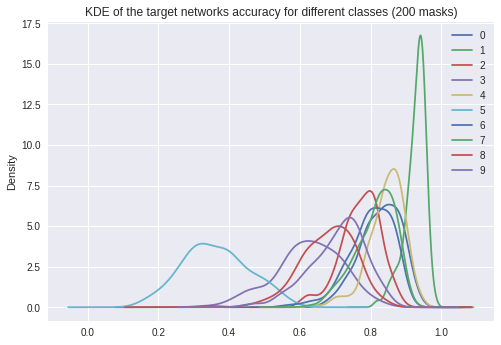

In [72]:
plt.style.use("seaborn")
pd.DataFrame(class_precision).plot.kde()
plt.title("KDE of the target networks accuracy for different classes (200 masks)");

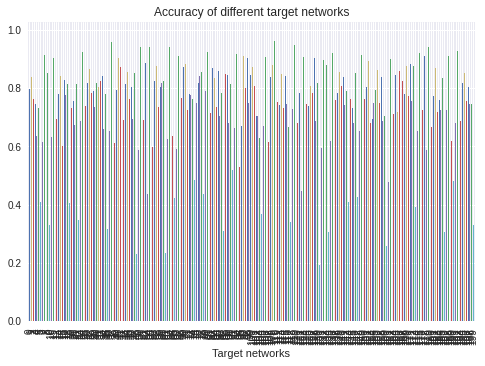

In [73]:
pd.DataFrame(class_precision).plot.bar()
plt.title("Accuracy of different target networks")
plt.xlabel("Target networks");
plt.legend([]);

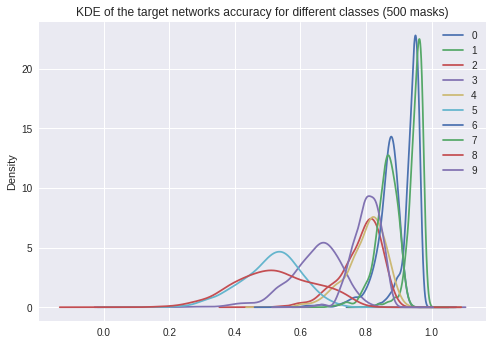

In [576]:
plt.style.use("seaborn")
pd.DataFrame(class_precision).plot.kde()
plt.title("KDE of the target networks accuracy for different classes (500 masks)");

### Generalizability

In [333]:
preds = []
labels = []

for data, y_true, mask in testloader:
    masked_data = data[mask.bool()].reshape((y_true.shape[0], -1))
    y_hat = nn(masked_data.cuda()).argmax(axis=1)
    preds.extend(y_hat.cpu().tolist())
    labels.extend(y_true.tolist())
    
print("Accuracy", accuracy_score(preds, labels))

(10, 10)

In [334]:
matrix.shape

(10, 10)